In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-CosineAnnealingWarmRestarts
Time: Tue Nov 17 02:35:47 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

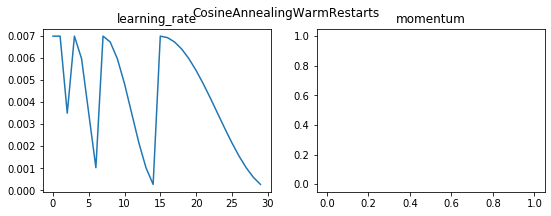

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': 1, 
    'T_mult': 2, 
    'eta_min': 1e-5, 
}

CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [34]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [46]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate (default: 1.0)
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 100)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
            weight_decay_type (str, optional): type of weight decay:
                ``'L2'`` | ``'decoupled'`` | ``'stable'`` (default: 'L2')
        """
    def __init__(self,
                 params,
                 lr=1.0,
                 beta=0.9,
                 eps=1e-4,
                 warmup=100,
                 init_lr=0.01,
                 weight_decay=0,
                 weight_decay_type='L2'):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError(
                "Invalid initial learning rate: {}".format(init_lr))
        if weight_decay_type not in ['L2', 'decoupled', 'stable']:
            raise ValueError(
                "Invalid weight decay type: {}".format(weight_decay_type))

        defaults = dict(lr=lr,
                        beta=beta,
                        eps=eps,
                        warmup=warmup,
                        init_lr=init_lr,
                        base_lr=lr,
                        weight_decay=weight_decay,
                        weight_decay_type=weight_decay_type)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state[
                        'step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0 and group[
                        'weight_decay_type'] == 'L2':
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta**state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(
                    -alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                # Perform step weight decay
                if group['weight_decay'] != 0 and group[
                        'weight_decay_type'] != 'L2':
                    if group['weight_decay_type'] == 'stable':
                        weight_decay = group['weight_decay'] / denom.mean(
                        ).item()
                    else:
                        weight_decay = group['weight_decay']
                    d_p.add_(p, alpha=weight_decay)

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [23]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: AggMo
fold 0


epoch1 save best model... 0.22790434126294556
epoch2 save best model... 0.025394335347556578
epoch3 save best model... 0.0233830047223997
epoch4 save best model... 0.021755888989377675
epoch5 save best model... 0.0211590482825774
epoch6 save best model... 0.02087630611464619
epoch7 save best model... 0.020826555672260785
epoch8 save best model... 0.020539829406488457
epoch9 save best model... 0.02026330495681741
epoch10 save best model... 0.020103024334088816
epoch11 save best model... 0.019952154893572348
epoch12 save best model... 0.01985072042360257
epoch14 save best model... 0.019809773859646433
epoch15 save best model... 0.0197575090491215
epoch16 save best model... 0.01960324036352048
epoch17 save best model... 0.019522565279945153
epoch18 save best model... 0.019314692174519383
epoch19 save best model... 0.019197339988006004
epoch20 save best model... 0.019088201101759027
epoch21 save best model... 0.018993679608021077
epoch22 save best model... 0.018903250173413128
epoch23 save

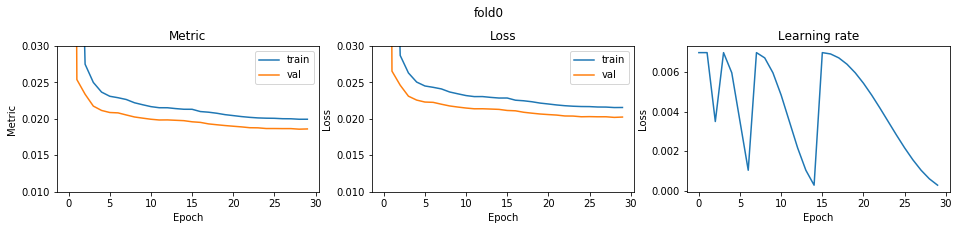

fold 1


epoch1 save best model... 0.24065871487502546
epoch2 save best model... 0.02567844070183522
epoch3 save best model... 0.023360617296279196
epoch4 save best model... 0.02181013862057709
epoch5 save best model... 0.021232507675614545
epoch6 save best model... 0.021006756821402413
epoch7 save best model... 0.020967678274508624
epoch8 save best model... 0.02071199837947291
epoch9 save best model... 0.020347474173889477
epoch10 save best model... 0.020264438647792968
epoch11 save best model... 0.02010691964667393
epoch12 save best model... 0.020055015682393255
epoch13 save best model... 0.019955966375915873
epoch14 save best model... 0.019902460196446547
epoch16 save best model... 0.019779194987958944
epoch17 save best model... 0.01962755647216117
epoch18 save best model... 0.019554032304800163
epoch19 save best model... 0.019400210101322937
epoch20 save best model... 0.019297225394015242
epoch21 save best model... 0.019175402556140104
epoch22 save best model... 0.0190924957286805
epoch23 s

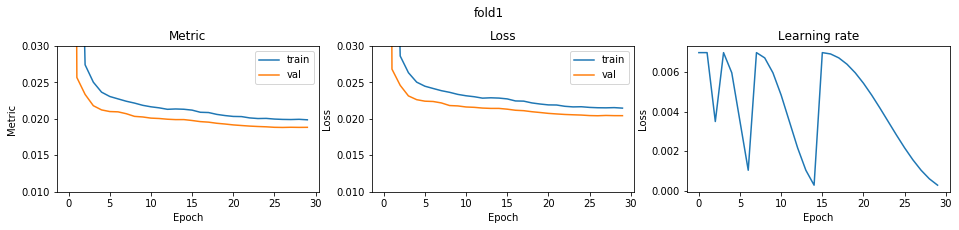

fold 2


epoch1 save best model... 0.24352102595137204
epoch2 save best model... 0.025613978842099778
epoch3 save best model... 0.023354771276471228
epoch4 save best model... 0.021791597743815512
epoch5 save best model... 0.021290274768962517
epoch6 save best model... 0.021083791669577828
epoch7 save best model... 0.02094632722471333
epoch8 save best model... 0.020698632230130434
epoch9 save best model... 0.02047384824450167
epoch10 save best model... 0.020416252974545555
epoch11 save best model... 0.020207188970021654
epoch12 save best model... 0.020113303440018868
epoch13 save best model... 0.02006796851039517
epoch14 save best model... 0.02004612427001989
epoch15 save best model... 0.020022831908979945
epoch16 save best model... 0.019920108539401793
epoch17 save best model... 0.019729533594964876
epoch18 save best model... 0.019642138133055938
epoch19 save best model... 0.019523987965011112
epoch20 save best model... 0.019378391841643354
epoch21 save best model... 0.019277896489341157
epoch2

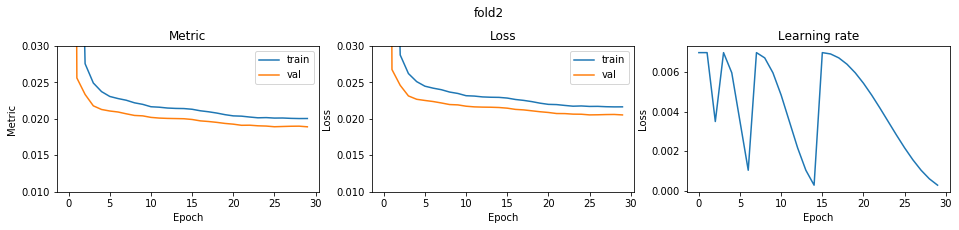

fold 3


epoch1 save best model... 0.2056085157570915
epoch2 save best model... 0.025008508227850418
epoch3 save best model... 0.02327023321054112
epoch4 save best model... 0.0218300448319024
epoch5 save best model... 0.021232035692467233
epoch6 save best model... 0.021069795720635623
epoch7 save best model... 0.020978000340028613
epoch8 save best model... 0.02063560639221671
epoch9 save best model... 0.02045236219204368
epoch10 save best model... 0.020277668664694375
epoch11 save best model... 0.020151916434797447
epoch12 save best model... 0.020070566940874474
epoch13 save best model... 0.020038778182110646
epoch14 save best model... 0.0200276845030843
epoch15 save best model... 0.01993754437163574
epoch16 save best model... 0.019841161427556927
epoch17 save best model... 0.019700082386833254
epoch18 save best model... 0.01956343285204813
epoch19 save best model... 0.01946574904423436
epoch20 save best model... 0.019368220102423825
epoch21 save best model... 0.01930241352604842
epoch22 save b

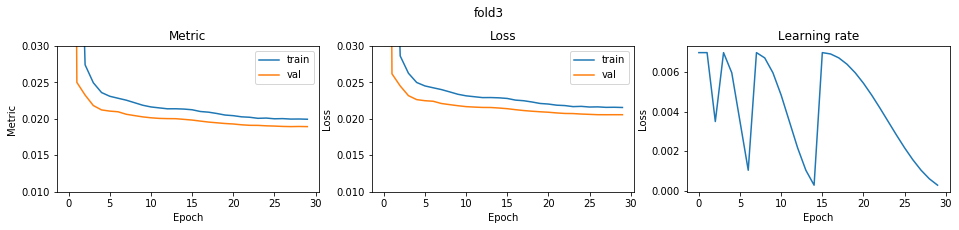

fold 4


epoch1 save best model... 0.21300618601687132
epoch2 save best model... 0.025084986995931095
epoch3 save best model... 0.023061410698335373
epoch4 save best model... 0.021610270825836272
epoch5 save best model... 0.020989177272504447
epoch6 save best model... 0.02075444727643883
epoch7 save best model... 0.02070183652391602
epoch8 save best model... 0.02042080314325037
epoch9 save best model... 0.02015012092209487
epoch10 save best model... 0.020023974716018435
epoch11 save best model... 0.019911668966428837
epoch12 save best model... 0.019804944971190227
epoch13 save best model... 0.019741104101096037
epoch14 save best model... 0.019706718653338645
epoch15 save best model... 0.019691178209417775
epoch16 save best model... 0.019516533173637673
epoch17 save best model... 0.019378797220308035
epoch18 save best model... 0.019254124756045383
epoch19 save best model... 0.019135240973705312
epoch20 save best model... 0.01904869422672957
epoch21 save best model... 0.018927392497624786
epoch22

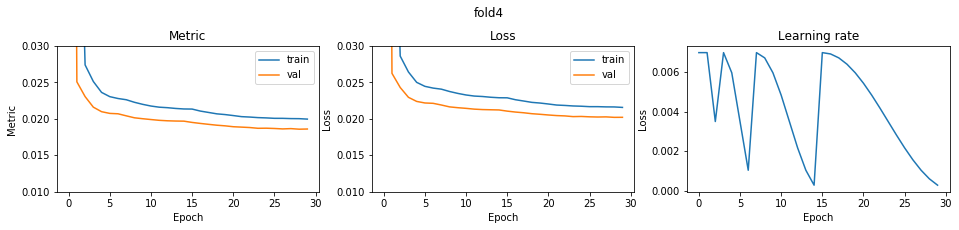

CV score: 0.01877274967449856

optimizer: Apollo
fold 0


epoch1 save best model... 0.7039063529979124
epoch2 save best model... 0.6988165043209571
epoch3 save best model... 0.69094486366915
epoch4 save best model... 0.684121062625242
epoch5 save best model... 0.6798031938646268
epoch6 save best model... 0.6762890587906631
epoch7 save best model... 0.6734898028178204
epoch8 save best model... 0.6677071186567494
epoch9 save best model... 0.6575661506359561
epoch10 save best model... 0.6510327408416939
epoch11 save best model... 0.6414268959899155
epoch12 save best model... 0.6384008057839778
epoch13 save best model... 0.6339209000993699
epoch14 save best model... 0.632234190075164
epoch16 save best model... 0.6229046161462615
epoch17 save best model... 0.6092692299421393
epoch18 save best model... 0.5946900032918926
epoch19 save best model... 0.5792196630888485
epoch20 save best model... 0.5645113308771867
epoch21 save best model... 0.5498647283041396
epoch22 save best model... 0.5320296587324903
epoch23 save best model... 0.5189083247358544
e

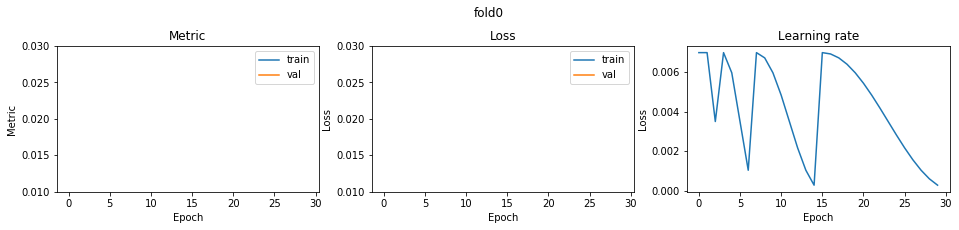

fold 1


epoch1 save best model... 0.7026041042671629
epoch2 save best model... 0.6946050419191424
epoch3 save best model... 0.6902151456534333
epoch4 save best model... 0.6821972612070043
epoch5 save best model... 0.6780162374205729
epoch6 save best model... 0.6718999107624409
epoch7 save best model... 0.6703619036486546
epoch8 save best model... 0.6616967541667915
epoch9 save best model... 0.6516545447789338
epoch10 save best model... 0.6432813910233129
epoch11 save best model... 0.6384471609804836
epoch12 save best model... 0.6330307595385971
epoch13 save best model... 0.6307444754155304
epoch14 save best model... 0.62734643388756
epoch16 save best model... 0.6142267097669573
epoch17 save best model... 0.6020554120379283
epoch18 save best model... 0.5892245920651267
epoch19 save best model... 0.5714105339413162
epoch20 save best model... 0.5541131484342833
epoch21 save best model... 0.5405409538574766
epoch22 save best model... 0.5213893067595029
epoch23 save best model... 0.5067315447246276

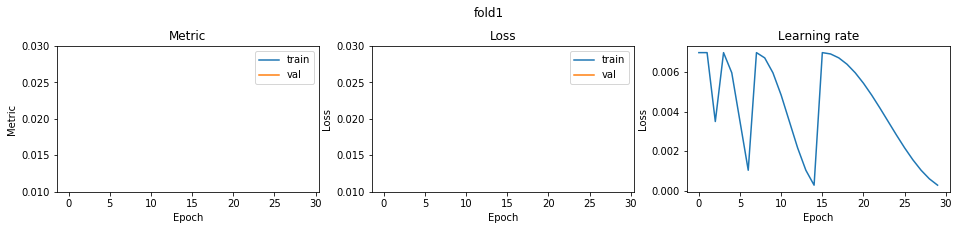

fold 2


epoch1 save best model... 0.7012703710711609
epoch2 save best model... 0.697018890153794
epoch3 save best model... 0.6903359452285862
epoch4 save best model... 0.6820412522895267
epoch5 save best model... 0.6771317240751313
epoch6 save best model... 0.6707874021814798
epoch7 save best model... 0.6700529174887256
epoch8 save best model... 0.6622332134070823
epoch9 save best model... 0.6539656454567813
epoch10 save best model... 0.6451914679029043
epoch11 save best model... 0.638538656147283
epoch12 save best model... 0.6325250998882912
epoch13 save best model... 0.6317730790581728
epoch14 save best model... 0.6298087656321409
epoch15 save best model... 0.6261813467036187
epoch16 save best model... 0.6148230594392518
epoch17 save best model... 0.6002159713340746
epoch18 save best model... 0.586420297514037
epoch19 save best model... 0.5687943728482379
epoch20 save best model... 0.5539618669704577
epoch21 save best model... 0.5351381403597538
epoch22 save best model... 0.5192340993207635


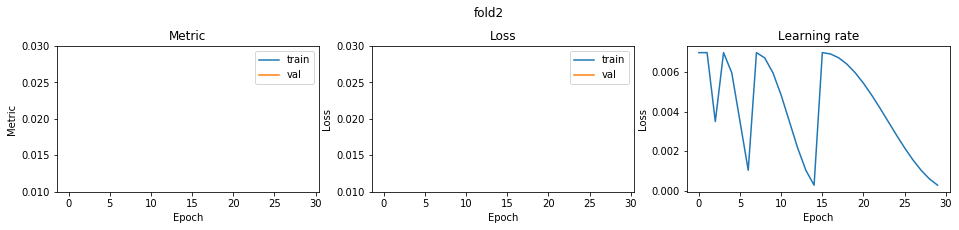

fold 3


epoch1 save best model... 0.6988382389170705
epoch2 save best model... 0.6927108961248724
epoch3 save best model... 0.6893386797101189
epoch4 save best model... 0.6822726521513728
epoch5 save best model... 0.6734148025784242
epoch6 save best model... 0.6725611215028785
epoch7 save best model... 0.6695737311943245
epoch8 save best model... 0.6620439134860636
epoch9 save best model... 0.6550859558826698
epoch10 save best model... 0.6480349599364679
epoch11 save best model... 0.6407041361228751
epoch12 save best model... 0.6340942595977175
epoch13 save best model... 0.6325521282563177
epoch14 save best model... 0.6311513621334606
epoch15 save best model... 0.6287481557535419
epoch16 save best model... 0.6171584905144294
epoch17 save best model... 0.6029417175095282
epoch18 save best model... 0.5904360577565934
epoch19 save best model... 0.5750917768424084
epoch20 save best model... 0.5606842099398307
epoch21 save best model... 0.5417823205233163
epoch22 save best model... 0.52807014420255

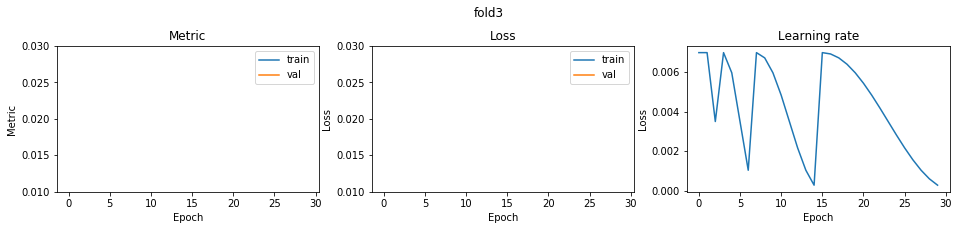

fold 4


epoch1 save best model... 0.7072412000158653
epoch2 save best model... 0.698019442308465
epoch3 save best model... 0.6963286377845973
epoch4 save best model... 0.6866894677451096
epoch5 save best model... 0.678390854719288
epoch6 save best model... 0.6728351072461296
epoch8 save best model... 0.6657444818416326
epoch9 save best model... 0.6563590853523827
epoch10 save best model... 0.6480256201194468
epoch11 save best model... 0.6400476362004639
epoch12 save best model... 0.6367287930432105
epoch13 save best model... 0.6338225265570273
epoch14 save best model... 0.6305320882036909
epoch15 save best model... 0.6283615673593074
epoch16 save best model... 0.6171366799665203
epoch17 save best model... 0.6024333374103815
epoch18 save best model... 0.5887905712008205
epoch19 save best model... 0.571451469841742
epoch20 save best model... 0.5538015891316268
epoch21 save best model... 0.5372316037603826
epoch22 save best model... 0.5199105038186683
epoch23 save best model... 0.5046175933373002

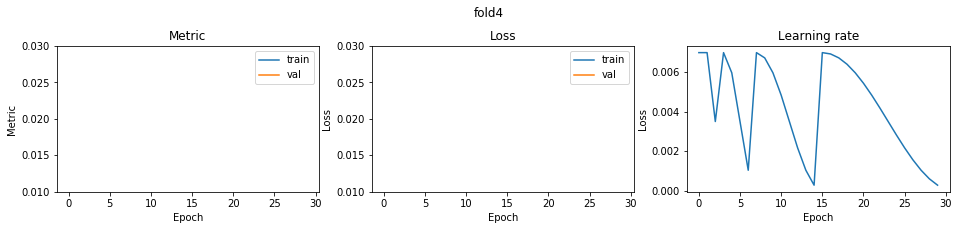

CV score: 0.4615170908800863

optimizer: PID
fold 0


epoch1 save best model... 0.7030631851769797
epoch2 save best model... 0.6924268961767401
epoch3 save best model... 0.6899520906880667
epoch4 save best model... 0.6820294860012167
epoch5 save best model... 0.6763755041265813
epoch6 save best model... 0.6737176594538677
epoch7 save best model... 0.6710482698638238
epoch8 save best model... 0.6608289170916911
epoch9 save best model... 0.6535511898016876
epoch10 save best model... 0.6432709987451384
epoch11 save best model... 0.6395170927319277
epoch12 save best model... 0.6339940145509932
epoch13 save best model... 0.6307258790880781
epoch14 save best model... 0.6281398186922617
epoch15 save best model... 0.6279061701683357
epoch16 save best model... 0.6152750084503364
epoch17 save best model... 0.6006791943841209
epoch18 save best model... 0.5870353113002821
epoch19 save best model... 0.5690527912424475
epoch20 save best model... 0.5534359640032392
epoch21 save best model... 0.5380305623953869
epoch22 save best model... 0.52141082142914

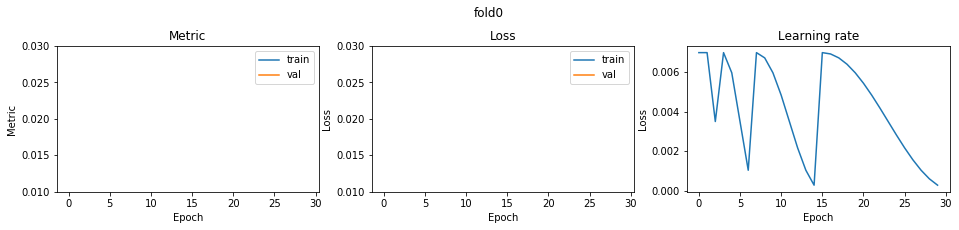

fold 1


epoch1 save best model... 0.703469315974526
epoch2 save best model... 0.6928486288558054
epoch3 save best model... 0.6907441812975039
epoch4 save best model... 0.6837500783027671
epoch5 save best model... 0.6763018868756636
epoch6 save best model... 0.6702134602432182
epoch8 save best model... 0.6630200133505104
epoch9 save best model... 0.6538294752574668
epoch10 save best model... 0.6458581964419354
epoch11 save best model... 0.6386421995327016
epoch12 save best model... 0.6332770432554581
epoch13 save best model... 0.630045091530054
epoch14 save best model... 0.6272111973313814
epoch16 save best model... 0.616302863561257
epoch17 save best model... 0.6003888130296632
epoch18 save best model... 0.5881238596318223
epoch19 save best model... 0.5701681040880973
epoch20 save best model... 0.5542518986903825
epoch21 save best model... 0.5378137644398155
epoch22 save best model... 0.5212716900778132
epoch23 save best model... 0.5048491789936667
epoch24 save best model... 0.4892514993237808

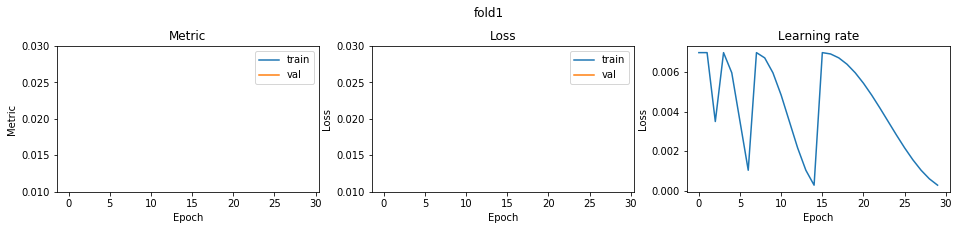

fold 2


epoch1 save best model... 0.7090766421752847
epoch2 save best model... 0.6970108508058767
epoch3 save best model... 0.6931779381489531
epoch4 save best model... 0.6863506071305161
epoch5 save best model... 0.6788424004669693
epoch6 save best model... 0.6752379686692821
epoch7 save best model... 0.6751395880592035
epoch8 save best model... 0.6662432278009286
epoch9 save best model... 0.6571044050688406
epoch10 save best model... 0.6497110268417267
epoch11 save best model... 0.6435820353033874
epoch12 save best model... 0.6357105093084888
epoch13 save best model... 0.6325233332060768
epoch14 save best model... 0.6311233572493818
epoch15 save best model... 0.6294806788928635
epoch16 save best model... 0.6200175936115062
epoch17 save best model... 0.6061407127747587
epoch18 save best model... 0.5917050893063913
epoch19 save best model... 0.5751189186839749
epoch20 save best model... 0.5573639152913192
epoch21 save best model... 0.5438418464281478
epoch22 save best model... 0.52394153165176

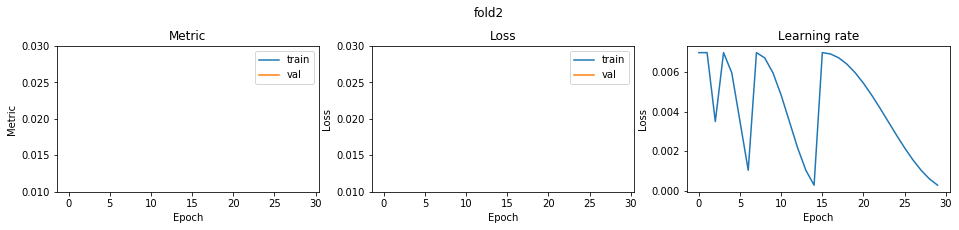

fold 3


epoch1 save best model... 0.6942561561534508
epoch2 save best model... 0.687098095493056
epoch3 save best model... 0.6836252267648527
epoch4 save best model... 0.6779889925737316
epoch5 save best model... 0.6695724187787954
epoch6 save best model... 0.6653902563255849
epoch7 save best model... 0.6641304879633875
epoch8 save best model... 0.657993838971731
epoch9 save best model... 0.6487150086085726
epoch10 save best model... 0.6416429581837665
epoch11 save best model... 0.6337561122648808
epoch12 save best model... 0.6295344280219024
epoch13 save best model... 0.6260193405770496
epoch14 save best model... 0.6247446060995306
epoch15 save best model... 0.6239405667863294
epoch16 save best model... 0.6120520650661616
epoch17 save best model... 0.5986062789832269
epoch18 save best model... 0.5849235082270072
epoch19 save best model... 0.5709863248610008
epoch20 save best model... 0.5544963212925643
epoch21 save best model... 0.5369215238338723
epoch22 save best model... 0.5220470215302122

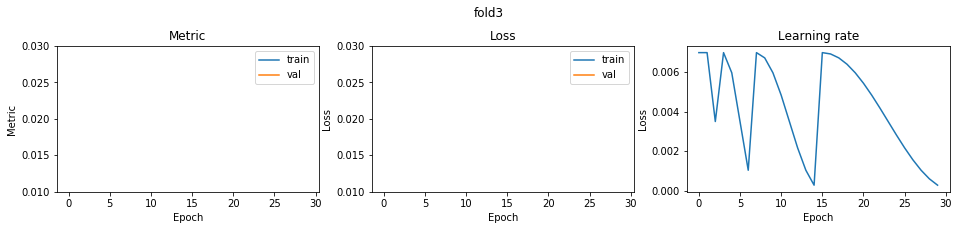

fold 4


epoch1 save best model... 0.7030464104204894
epoch2 save best model... 0.6970071276662562
epoch3 save best model... 0.6928043745916362
epoch4 save best model... 0.685142872192322
epoch5 save best model... 0.6770339606563159
epoch6 save best model... 0.6726831392709649
epoch7 save best model... 0.67204910454283
epoch8 save best model... 0.6634651458616408
epoch9 save best model... 0.6556379026866991
epoch10 save best model... 0.648207106188381
epoch11 save best model... 0.6420491199015484
epoch12 save best model... 0.637837895825675
epoch13 save best model... 0.633780567711198
epoch14 save best model... 0.6318126378406967
epoch15 save best model... 0.6314935523176519
epoch16 save best model... 0.6199480624568218
epoch17 save best model... 0.6087196955919809
epoch18 save best model... 0.5929521401270647
epoch19 save best model... 0.5777071326088525
epoch20 save best model... 0.5612750626642231
epoch21 save best model... 0.5458029087149201
epoch22 save best model... 0.5302895790352093
epo

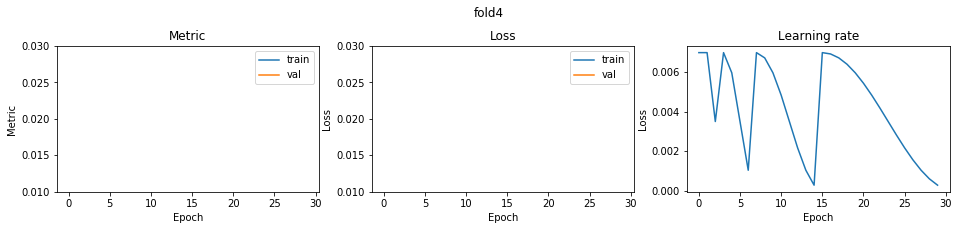

CV score: 0.46037302371875766

optimizer: QHM
fold 0


epoch1 save best model... 0.7100165212887566
epoch2 save best model... 0.7004199772869536
epoch3 save best model... 0.69519680542935
epoch4 save best model... 0.6896514606095664
epoch5 save best model... 0.6806864829975815
epoch6 save best model... 0.6775861051468208
epoch7 save best model... 0.6774460038454495
epoch8 save best model... 0.6675666367274482
epoch9 save best model... 0.6591375827246212
epoch10 save best model... 0.6512647403671421
epoch11 save best model... 0.6435883773758091
epoch12 save best model... 0.6383093581927393
epoch13 save best model... 0.6366730044805922
epoch14 save best model... 0.6328914292309442
epoch15 save best model... 0.632087642212392
epoch16 save best model... 0.622128217774263
epoch17 save best model... 0.6100380370448554
epoch18 save best model... 0.5943700192729542
epoch19 save best model... 0.580851423115828
epoch20 save best model... 0.5644734444542192
epoch21 save best model... 0.545208367752866
epoch22 save best model... 0.5289755806021376
epo

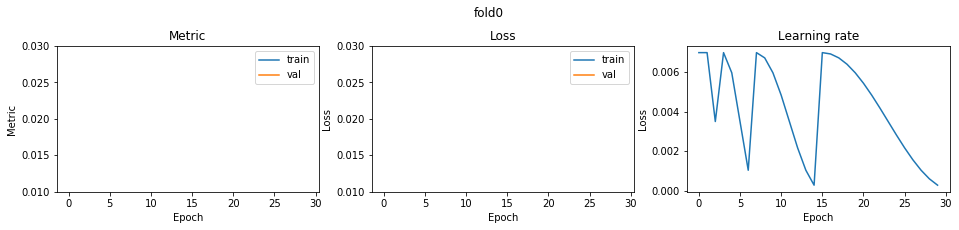

fold 1


epoch1 save best model... 0.7024340213200693
epoch2 save best model... 0.6935882085573974
epoch3 save best model... 0.6898503148846378
epoch4 save best model... 0.6850129428391143
epoch5 save best model... 0.6757866568977128
epoch6 save best model... 0.6716259084820178
epoch7 save best model... 0.671398773324275
epoch8 save best model... 0.6625111969762904
epoch9 save best model... 0.6519792290286883
epoch10 save best model... 0.6443328308228019
epoch11 save best model... 0.6380029258110931
epoch12 save best model... 0.6344073057500613
epoch13 save best model... 0.6296380067175845
epoch14 save best model... 0.6276885167860882
epoch15 save best model... 0.6263389246532765
epoch16 save best model... 0.614931867534953
epoch17 save best model... 0.601445661288618
epoch18 save best model... 0.585303234521662
epoch19 save best model... 0.5662872777845627
epoch20 save best model... 0.5529538620085943
epoch21 save best model... 0.5374244289915338
epoch22 save best model... 0.5204460994071204
e

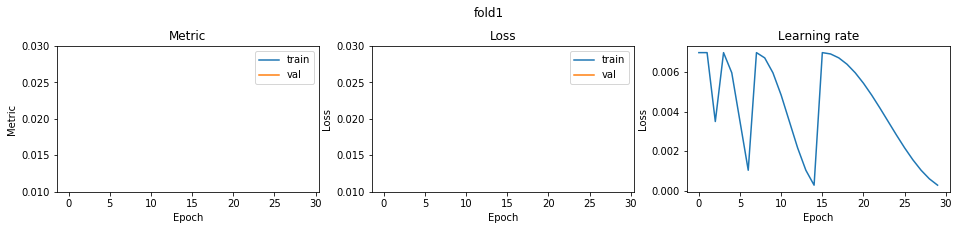

fold 2


epoch1 save best model... 0.7019058965990228
epoch2 save best model... 0.6967187674449175
epoch3 save best model... 0.6941086568276141
epoch4 save best model... 0.6840512324612622
epoch5 save best model... 0.6796106334073746
epoch6 save best model... 0.6758188708248429
epoch7 save best model... 0.6737377233319468
epoch8 save best model... 0.6656174056349107
epoch9 save best model... 0.6582948656879598
epoch10 save best model... 0.6524489737909621
epoch11 save best model... 0.6446669572685487
epoch12 save best model... 0.6403458496654568
epoch13 save best model... 0.6387794964214099
epoch14 save best model... 0.6360255003410039
epoch16 save best model... 0.6250289494965772
epoch17 save best model... 0.6136848439005628
epoch18 save best model... 0.59935355115844
epoch19 save best model... 0.5858603895158696
epoch20 save best model... 0.5707688326036015
epoch21 save best model... 0.5591304988300483
epoch22 save best model... 0.5403174348099136
epoch23 save best model... 0.5287114501841439

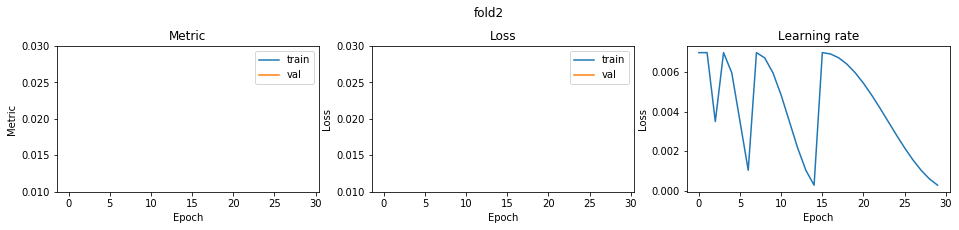

fold 3


epoch1 save best model... 0.7021031109510087
epoch2 save best model... 0.6937654688852523
epoch3 save best model... 0.6909112772800384
epoch4 save best model... 0.6830025903184757
epoch5 save best model... 0.6770695003941825
epoch6 save best model... 0.6716934773264822
epoch7 save best model... 0.6704718122449714
epoch8 save best model... 0.6628346017933109
epoch9 save best model... 0.6554946531195847
epoch10 save best model... 0.6480135226575552
epoch11 save best model... 0.6402294038640068
epoch12 save best model... 0.6361486846873864
epoch13 save best model... 0.632158667650201
epoch14 save best model... 0.6290596954643319
epoch15 save best model... 0.6282856947740281
epoch16 save best model... 0.6182598531381959
epoch17 save best model... 0.6050467484361218
epoch18 save best model... 0.5892694297303914
epoch19 save best model... 0.5761589459243288
epoch20 save best model... 0.5600146707478308
epoch21 save best model... 0.5435688109224098
epoch22 save best model... 0.528318509425552

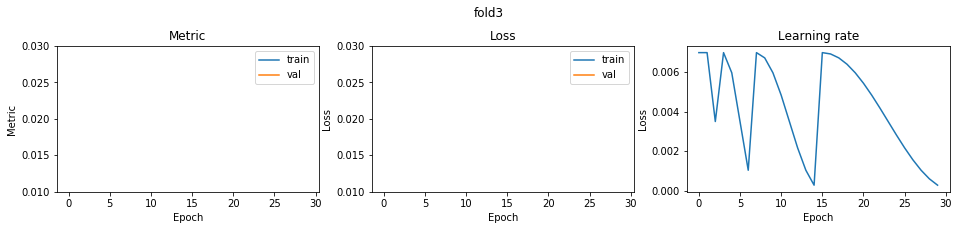

fold 4


epoch1 save best model... 0.7064377536806268
epoch2 save best model... 0.6990525558760606
epoch3 save best model... 0.6943570534569256
epoch4 save best model... 0.6861396880790693
epoch5 save best model... 0.6794740992689459
epoch6 save best model... 0.673645732044359
epoch7 save best model... 0.6732316526302172
epoch8 save best model... 0.6630699503394629
epoch9 save best model... 0.6556252264216169
epoch10 save best model... 0.6469810965935571
epoch11 save best model... 0.6414435644899251
epoch12 save best model... 0.6363016366143976
epoch13 save best model... 0.6314728838979248
epoch15 save best model... 0.630814086739186
epoch16 save best model... 0.6184150441904003
epoch17 save best model... 0.6036301888474571
epoch18 save best model... 0.5899427582028244
epoch19 save best model... 0.5740173744177764
epoch20 save best model... 0.5565942430550526
epoch21 save best model... 0.5398430805543017
epoch22 save best model... 0.5217652379244498
epoch23 save best model... 0.507441464439883


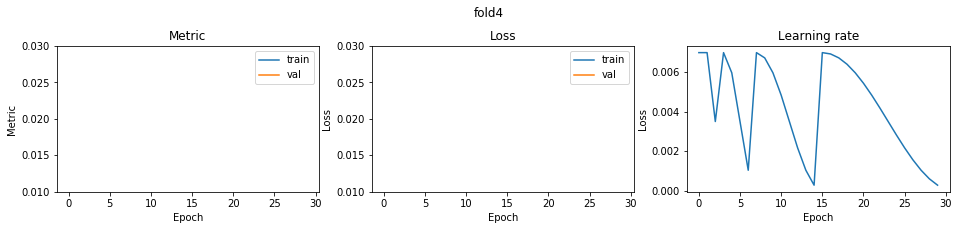

CV score: 0.46617101250686627

optimizer: SGDP
fold 0


epoch1 save best model... 0.7023057885484978
epoch2 save best model... 0.6927497441513392
epoch3 save best model... 0.6924417404487627
epoch4 save best model... 0.683518993420047
epoch5 save best model... 0.6748145701673417
epoch6 save best model... 0.6726735859905669
epoch7 save best model... 0.6696998989391979
epoch8 save best model... 0.6589861205064083
epoch9 save best model... 0.6540391469056079
epoch10 save best model... 0.641560357116621
epoch11 save best model... 0.6335871411618991
epoch12 save best model... 0.630298114338877
epoch13 save best model... 0.6265023324103997
epoch14 save best model... 0.6259003181663896
epoch15 save best model... 0.6248070553114854
epoch16 save best model... 0.6088819563524598
epoch17 save best model... 0.5953491045022065
epoch18 save best model... 0.5789506091343787
epoch19 save best model... 0.5613811782117857
epoch20 save best model... 0.5429674153175875
epoch21 save best model... 0.5241867070860634
epoch22 save best model... 0.5061598666708127


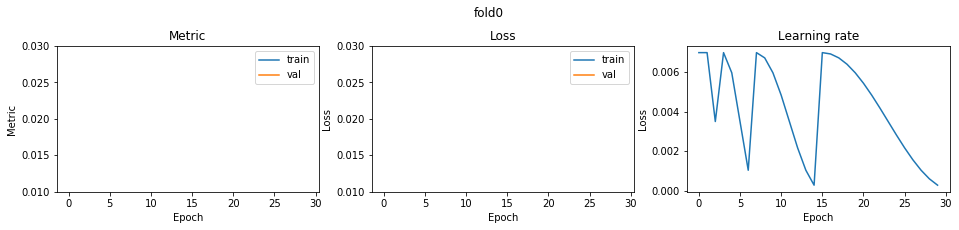

fold 1


epoch1 save best model... 0.7013997035896786
epoch2 save best model... 0.6917171196612717
epoch3 save best model... 0.6910470434570399
epoch4 save best model... 0.6807841134250612
epoch5 save best model... 0.6733560127559026
epoch6 save best model... 0.6701961283831532
epoch7 save best model... 0.6679127584641222
epoch8 save best model... 0.6606631171162837
epoch9 save best model... 0.6530609535828732
epoch10 save best model... 0.6455598985260672
epoch11 save best model... 0.6392382494434732
epoch12 save best model... 0.6335242765317557
epoch13 save best model... 0.6302131825222408
epoch14 save best model... 0.6283844943251906
epoch15 save best model... 0.6278390316464522
epoch16 save best model... 0.6172233998952028
epoch17 save best model... 0.6039336527580823
epoch18 save best model... 0.5890066120124238
epoch19 save best model... 0.575041198029717
epoch20 save best model... 0.5589120564848612
epoch21 save best model... 0.5398187928358388
epoch22 save best model... 0.524578299560968

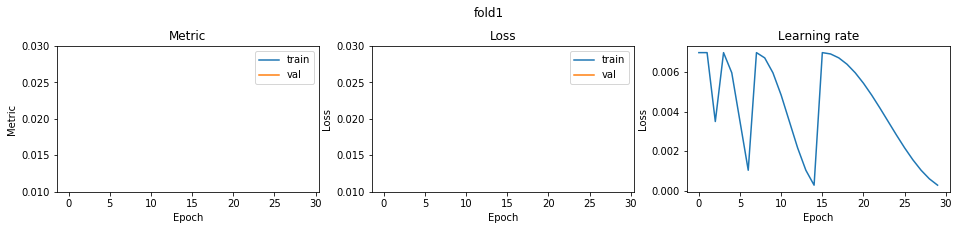

fold 2


epoch1 save best model... 0.7083552843564517
epoch2 save best model... 0.6988507798359589
epoch3 save best model... 0.6938005297540885
epoch4 save best model... 0.6862812353093088
epoch5 save best model... 0.6801837672946067
epoch6 save best model... 0.676566800812595
epoch7 save best model... 0.6748065516356049
epoch8 save best model... 0.6688394175897999
epoch9 save best model... 0.6581665598115771
epoch10 save best model... 0.653042893103897
epoch11 save best model... 0.645701628063773
epoch12 save best model... 0.6388370437485179
epoch13 save best model... 0.6375592686397172
epoch14 save best model... 0.6345795083763008
epoch16 save best model... 0.6211715806152533
epoch17 save best model... 0.6098983383689336
epoch18 save best model... 0.594971757023121
epoch19 save best model... 0.580406313226065
epoch20 save best model... 0.5626074062933218
epoch21 save best model... 0.5463312788796224
epoch22 save best model... 0.5298160394956267
epoch23 save best model... 0.5172533715034732
ep

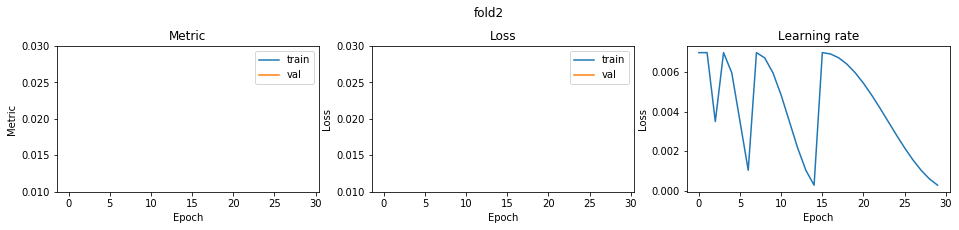

fold 3


epoch1 save best model... 0.7019993710083408
epoch2 save best model... 0.6945912260944045
epoch3 save best model... 0.692792750355323
epoch4 save best model... 0.6830889572315173
epoch5 save best model... 0.6755909151802845
epoch6 save best model... 0.6711071180862827
epoch8 save best model... 0.6614733776361904
epoch9 save best model... 0.655227461789898
epoch10 save best model... 0.646050263673135
epoch11 save best model... 0.6406978804049568
epoch12 save best model... 0.6340036682496039
epoch13 save best model... 0.6312693449522205
epoch14 save best model... 0.6293047837624517
epoch16 save best model... 0.6179144483220876
epoch17 save best model... 0.6030137460432726
epoch18 save best model... 0.5903899388324155
epoch19 save best model... 0.5728261316827327
epoch20 save best model... 0.5575370013578063
epoch21 save best model... 0.5405931642495418
epoch22 save best model... 0.5260902524809088
epoch23 save best model... 0.5076560315347206
epoch24 save best model... 0.4950243252420751

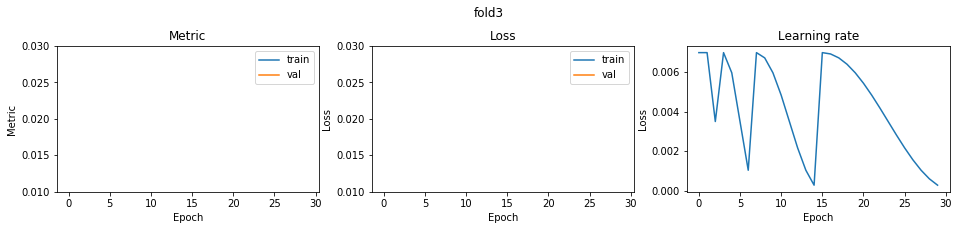

fold 4


epoch1 save best model... 0.705800934207195
epoch2 save best model... 0.6989052660644461
epoch3 save best model... 0.6930937528067135
epoch4 save best model... 0.687704427448655
epoch5 save best model... 0.6812356190692319
epoch6 save best model... 0.6750746775053629
epoch7 save best model... 0.6747648491403236
epoch8 save best model... 0.6664177790589647
epoch9 save best model... 0.6593784685015407
epoch10 save best model... 0.6505552529745602
epoch11 save best model... 0.6441712304508496
epoch12 save best model... 0.6391407371110417
epoch13 save best model... 0.6377234753552222
epoch14 save best model... 0.6345451001968905
epoch16 save best model... 0.6217904950600278
epoch17 save best model... 0.6111291311596412
epoch18 save best model... 0.5977607398206932
epoch19 save best model... 0.5840755843355878
epoch20 save best model... 0.5677792425579253
epoch21 save best model... 0.5522329755959043
epoch22 save best model... 0.5369296113831036
epoch23 save best model... 0.5212470768524465

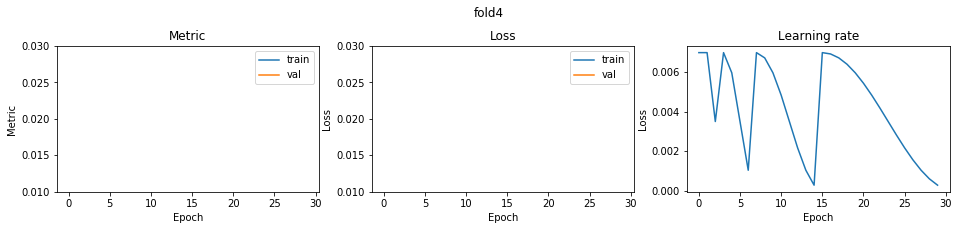

CV score: 0.46113182102361594

optimizer: SGDW
fold 0


epoch1 save best model... 0.7064299943235306
epoch2 save best model... 0.6953980601458452
epoch3 save best model... 0.693203082578872
epoch4 save best model... 0.6850244211716098
epoch5 save best model... 0.6795587121761469
epoch6 save best model... 0.6758123899375116
epoch7 save best model... 0.6742325105265224
epoch8 save best model... 0.6684453649238464
epoch9 save best model... 0.6581102061380286
epoch10 save best model... 0.6492995183940358
epoch11 save best model... 0.6427328815492791
epoch12 save best model... 0.6388212908644882
epoch13 save best model... 0.6362111831037222
epoch14 save best model... 0.6336525256106956
epoch15 save best model... 0.633544518980187
epoch16 save best model... 0.6222286871734133
epoch17 save best model... 0.61008096200187
epoch18 save best model... 0.5959585398367706
epoch19 save best model... 0.5809086074318592
epoch20 save best model... 0.5669758151223828
epoch21 save best model... 0.5473613733854272
epoch22 save best model... 0.5303904404672783
e

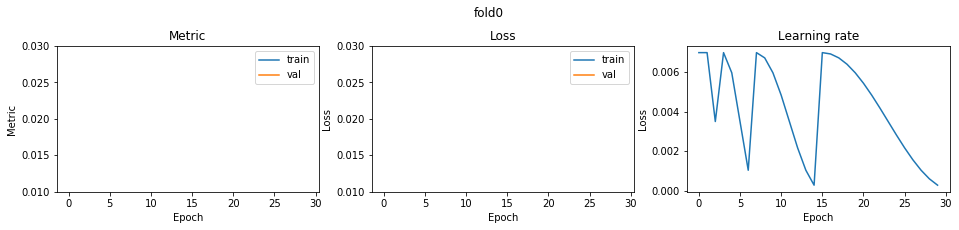

fold 1


epoch1 save best model... 0.7021474371224771
epoch2 save best model... 0.6972645283370063
epoch3 save best model... 0.6907574020395737
epoch4 save best model... 0.684032185877828
epoch5 save best model... 0.6782958198718151
epoch6 save best model... 0.6736534396074008
epoch7 save best model... 0.673174206557049
epoch8 save best model... 0.6648911489226819
epoch9 save best model... 0.6559879812001367
epoch10 save best model... 0.6491293123844518
epoch11 save best model... 0.641110032450558
epoch12 save best model... 0.6364075055451566
epoch13 save best model... 0.6339950962147046
epoch14 save best model... 0.6308427793774851
epoch16 save best model... 0.6180513805369631
epoch17 save best model... 0.6072917460145861
epoch18 save best model... 0.5942492599258067
epoch19 save best model... 0.5793994797691177
epoch20 save best model... 0.5634747637678968
epoch21 save best model... 0.5477180614724575
epoch22 save best model... 0.53084998491767
epoch23 save best model... 0.5169137081406768
ep

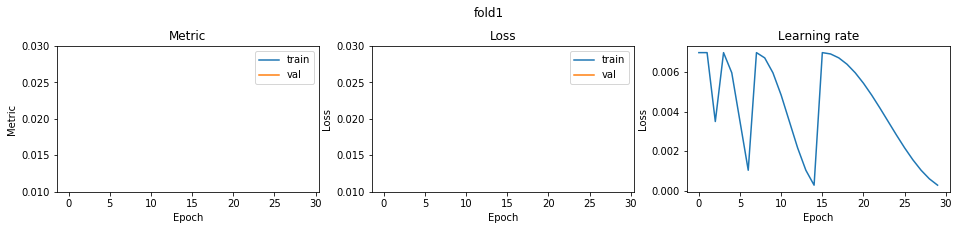

fold 2


epoch1 save best model... 0.7025834206134373
epoch2 save best model... 0.6967423015559934
epoch3 save best model... 0.6909057802316348
epoch4 save best model... 0.6864599949353701
epoch5 save best model... 0.677223755099774
epoch6 save best model... 0.6724771942818564
epoch7 save best model... 0.6715034989024328
epoch8 save best model... 0.6664492205298009
epoch9 save best model... 0.6578114710410382
epoch10 save best model... 0.6488836440254545
epoch11 save best model... 0.6412922175171218
epoch12 save best model... 0.6355551230823241
epoch13 save best model... 0.6330892539942392
epoch14 save best model... 0.6315087049581598
epoch15 save best model... 0.6303488119204241
epoch16 save best model... 0.6195009768647467
epoch17 save best model... 0.6049010702297448
epoch18 save best model... 0.5935626064191024
epoch19 save best model... 0.5729919275055444
epoch20 save best model... 0.5581011662425635
epoch21 save best model... 0.5401633145000321
epoch22 save best model... 0.525376499093021

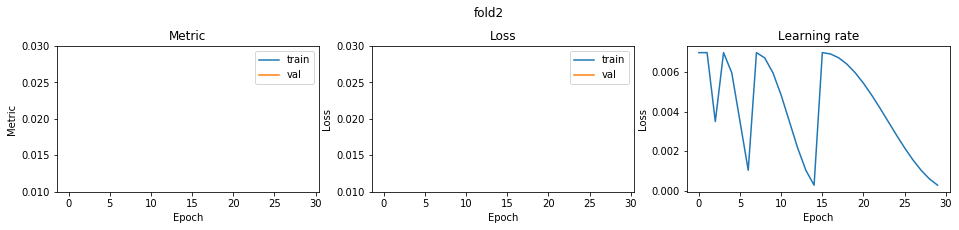

fold 3


epoch1 save best model... 0.7066791858108277
epoch2 save best model... 0.6966558208769709
epoch3 save best model... 0.6944237945563158
epoch4 save best model... 0.6877123395239845
epoch5 save best model... 0.6801985934817981
epoch6 save best model... 0.6761110468986095
epoch7 save best model... 0.6751455841683581
epoch8 save best model... 0.6674434004177536
epoch9 save best model... 0.6603381354336315
epoch10 save best model... 0.6521160391305737
epoch11 save best model... 0.6465965064620103
epoch12 save best model... 0.6422873894554607
epoch13 save best model... 0.6394441325463576
epoch14 save best model... 0.6382598099513043
epoch15 save best model... 0.6368947752515928
epoch16 save best model... 0.628526680263137
epoch17 save best model... 0.6144915170441456
epoch18 save best model... 0.6017948649195712
epoch19 save best model... 0.5885553510151039
epoch20 save best model... 0.5754290460454032
epoch21 save best model... 0.5617671632821033
epoch22 save best model... 0.544451775664892

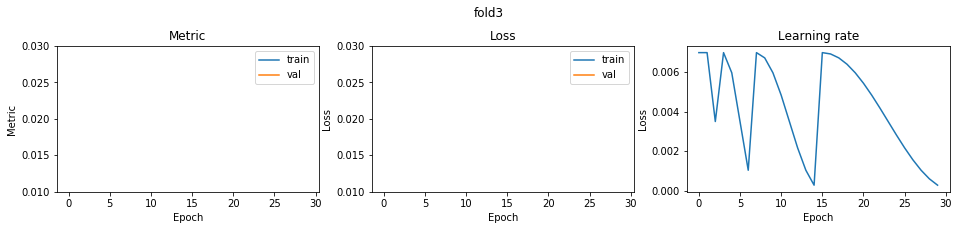

fold 4


epoch1 save best model... 0.704513961280397
epoch2 save best model... 0.695943126347179
epoch3 save best model... 0.6931518903625853
epoch4 save best model... 0.6842969820276751
epoch5 save best model... 0.6777777178412417
epoch6 save best model... 0.6729723892342256
epoch7 save best model... 0.6718330144339107
epoch8 save best model... 0.6630988866158661
epoch9 save best model... 0.654522447433993
epoch10 save best model... 0.6461448610507817
epoch11 save best model... 0.639166385301968
epoch12 save best model... 0.6346387360525022
epoch13 save best model... 0.6313807005219688
epoch14 save best model... 0.6294012013220298
epoch16 save best model... 0.6170226713247886
epoch17 save best model... 0.606116424579012
epoch18 save best model... 0.5889644220369552
epoch19 save best model... 0.5724809511104314
epoch20 save best model... 0.5568280727553748
epoch21 save best model... 0.5403381631966332
epoch22 save best model... 0.5230852557477755
epoch23 save best model... 0.5083771466665767
ep

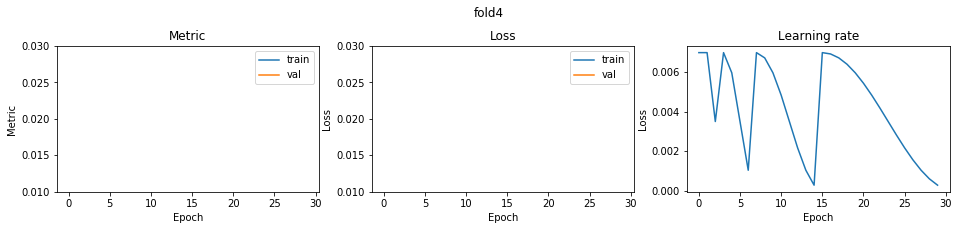

CV score: 0.47079680819910785

optimizer: SGD
fold 0


epoch1 save best model... 0.7047862804832111
epoch2 save best model... 0.6962169581230789
epoch3 save best model... 0.6917964622480179
epoch4 save best model... 0.6823370050460711
epoch5 save best model... 0.6784471672868403
epoch6 save best model... 0.6718087177070236
epoch7 save best model... 0.6696998734952105
epoch8 save best model... 0.6637661764181828
epoch9 save best model... 0.6527611330592822
epoch10 save best model... 0.644374088192855
epoch11 save best model... 0.6383460975453631
epoch12 save best model... 0.6334510665548146
epoch13 save best model... 0.6295592405529935
epoch14 save best model... 0.6280732990397407
epoch16 save best model... 0.6154066679689498
epoch17 save best model... 0.6012316459675313
epoch18 save best model... 0.5880099765260561
epoch19 save best model... 0.5708426557260656
epoch20 save best model... 0.5519908854793036
epoch21 save best model... 0.5365262454897505
epoch22 save best model... 0.5187044110276433
epoch23 save best model... 0.503274495332822

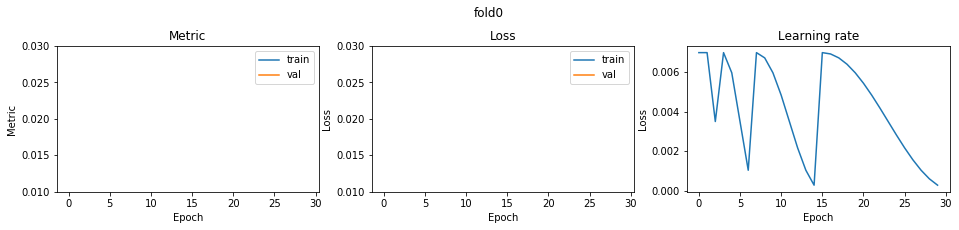

fold 1


epoch1 save best model... 0.7042755928797884
epoch2 save best model... 0.6970991577964134
epoch3 save best model... 0.69471663323533
epoch4 save best model... 0.686720722233361
epoch5 save best model... 0.6783504639543197
epoch6 save best model... 0.6751528673466421
epoch7 save best model... 0.6727446539170053
epoch8 save best model... 0.6649952065458491
epoch9 save best model... 0.6573040339120512
epoch10 save best model... 0.6487558239493345
epoch11 save best model... 0.6419383661843129
epoch12 save best model... 0.63623195181786
epoch13 save best model... 0.633143044829939
epoch14 save best model... 0.6315587502618835
epoch16 save best model... 0.6185106523869711
epoch17 save best model... 0.6040074186461964
epoch18 save best model... 0.588690631792686
epoch19 save best model... 0.5753895075426039
epoch20 save best model... 0.5563734188441617
epoch21 save best model... 0.5392748823902498
epoch22 save best model... 0.5240598213675354
epoch23 save best model... 0.5046034232851421
epoc

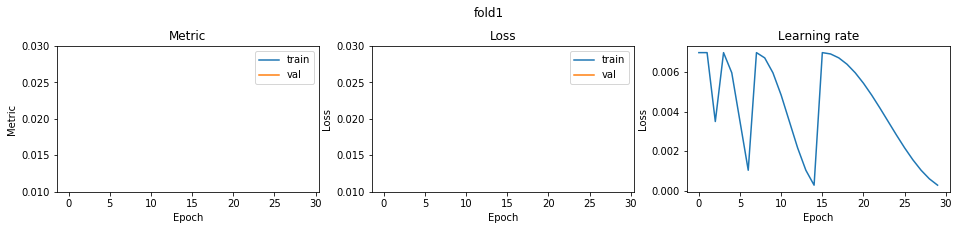

fold 2


epoch1 save best model... 0.7010165892964101
epoch2 save best model... 0.6932666854316266
epoch3 save best model... 0.687850784809993
epoch4 save best model... 0.6820029460180591
epoch5 save best model... 0.6726383524756954
epoch6 save best model... 0.6670711732149722
epoch8 save best model... 0.6613298245648583
epoch9 save best model... 0.6496962596925252
epoch10 save best model... 0.6424510398169644
epoch11 save best model... 0.6350889236081241
epoch12 save best model... 0.6310692429949956
epoch13 save best model... 0.6266171591894099
epoch14 save best model... 0.6241406235045196
epoch15 save best model... 0.6237652571767901
epoch16 save best model... 0.6114144810893645
epoch17 save best model... 0.5961264223437506
epoch18 save best model... 0.5805015232873196
epoch19 save best model... 0.5634229840083936
epoch20 save best model... 0.5465168269437276
epoch21 save best model... 0.5278371577383473
epoch22 save best model... 0.5130114837425068
epoch23 save best model... 0.49504838896438

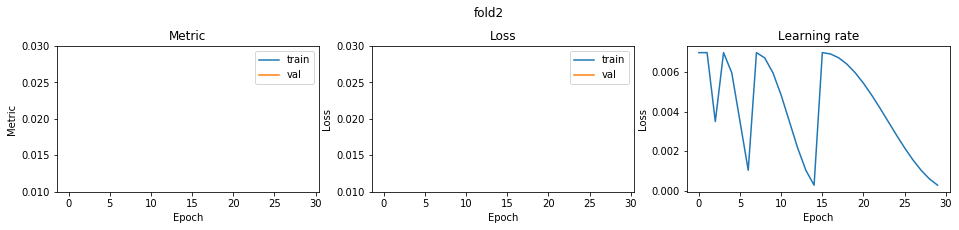

fold 3


epoch1 save best model... 0.7070768105141937
epoch2 save best model... 0.6977918754134471
epoch3 save best model... 0.6930933847785811
epoch4 save best model... 0.685329224444196
epoch5 save best model... 0.6809398080058956
epoch6 save best model... 0.675493384819639
epoch8 save best model... 0.6667165773333069
epoch9 save best model... 0.6573541969264558
epoch10 save best model... 0.6506432261988351
epoch11 save best model... 0.6434739146525876
epoch12 save best model... 0.6404145345057877
epoch13 save best model... 0.6363619632492847
epoch14 save best model... 0.6337553220077636
epoch16 save best model... 0.6239318232601487
epoch17 save best model... 0.6109842567617638
epoch18 save best model... 0.5969227725389606
epoch19 save best model... 0.582047459069037
epoch20 save best model... 0.5680978447538302
epoch21 save best model... 0.5536545573714654
epoch22 save best model... 0.5379667964503
epoch23 save best model... 0.5221736454474899
epoch24 save best model... 0.512378129899366
epo

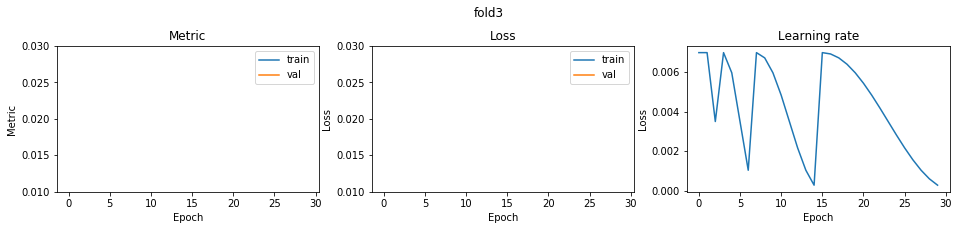

fold 4


epoch1 save best model... 0.7063460730474468
epoch2 save best model... 0.6996765344180931
epoch3 save best model... 0.696849394822175
epoch4 save best model... 0.6879852334839336
epoch5 save best model... 0.6807281288850824
epoch6 save best model... 0.6766662228351845
epoch7 save best model... 0.6759688932423168
epoch8 save best model... 0.6683612293697435
epoch9 save best model... 0.6594233910695295
epoch10 save best model... 0.6518778942983623
epoch11 save best model... 0.6438133282922124
epoch12 save best model... 0.6391333583275658
epoch13 save best model... 0.6355286001344477
epoch14 save best model... 0.6343311515375802
epoch15 save best model... 0.6326345292745256
epoch16 save best model... 0.6214359503129077
epoch17 save best model... 0.6099991197195032
epoch18 save best model... 0.5952467421192786
epoch19 save best model... 0.5774749702364546
epoch20 save best model... 0.5608905189129649
epoch21 save best model... 0.5444104036872099
epoch22 save best model... 0.528629303928931

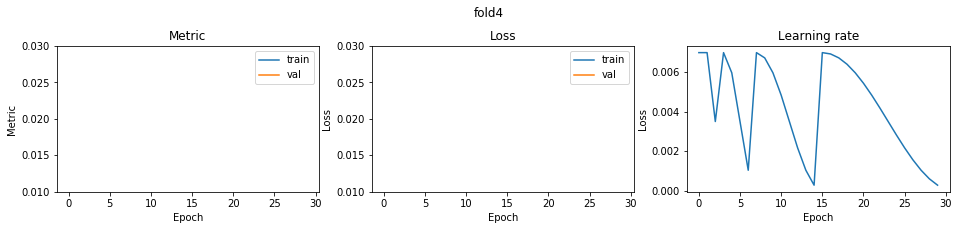

CV score: 0.4600020986042192

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019207456188620086
epoch2 save best model... 0.01825399353404387
epoch3 save best model... 0.017497688626917186
epoch5 save best model... 0.01725659714184345
epoch6 save best model... 0.016948053292539778
epoch7 save best model... 0.016537549647084673
epoch12 save best model... 0.01642424608909595
epoch13 save best model... 0.016190574510799454
epoch14 save best model... 0.01613727431566134
epoch15 save best model... 0.01610712215881413
fold0 score: 0.016107122017761676


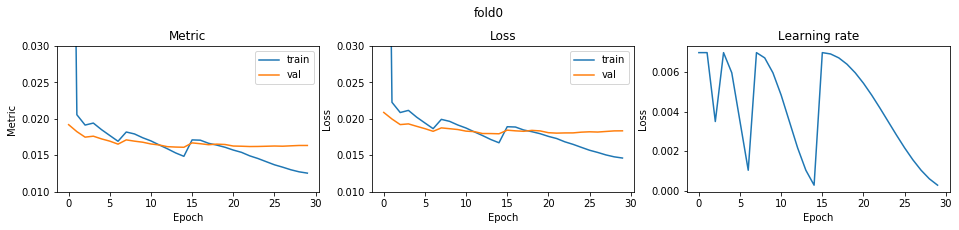

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01961196964366014
epoch2 save best model... 0.018505186145952472
epoch3 save best model... 0.017725217551855323
epoch5 save best model... 0.017590037793834352
epoch6 save best model... 0.01711019540218754
epoch7 save best model... 0.016782676037184523
epoch12 save best model... 0.016639857077205077
epoch13 save best model... 0.016559232935805097
epoch14 save best model... 0.016521252333773283
epoch15 save best model... 0.016486547936766655
fold1 score: 0.016486547955012348


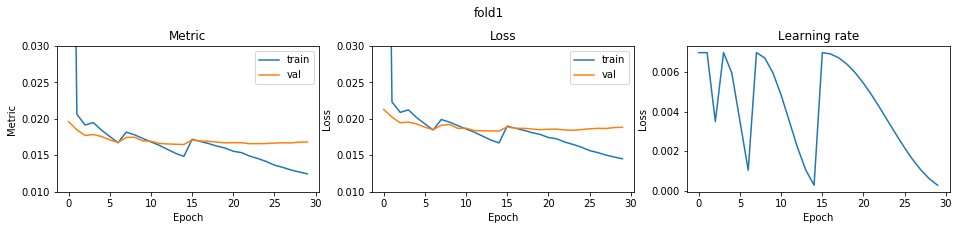

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01931642720572978
epoch2 save best model... 0.01843772965041366
epoch3 save best model... 0.01761669310064013
epoch5 save best model... 0.01735209022969259
epoch6 save best model... 0.016879867151206436
epoch7 save best model... 0.016638072773705558
epoch12 save best model... 0.016496661360216224
epoch13 save best model... 0.016304775102135734
epoch14 save best model... 0.016225269971227398
epoch15 save best model... 0.01618513310237731
fold2 score: 0.016185133046361554


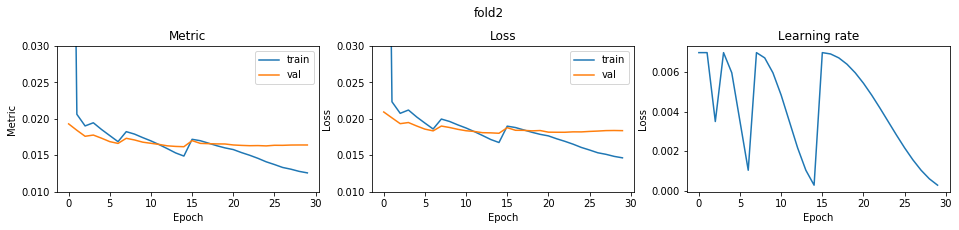

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019342106799669308
epoch2 save best model... 0.01857741132404036
epoch3 save best model... 0.01771733429503536
epoch5 save best model... 0.01754459323645792
epoch6 save best model... 0.017121081512446828
epoch7 save best model... 0.01685256031013024
epoch12 save best model... 0.016700624278269217
epoch13 save best model... 0.01658532107567122
epoch14 save best model... 0.016409943518833445
epoch15 save best model... 0.016370919896692784
fold3 score: 0.016370919852550833


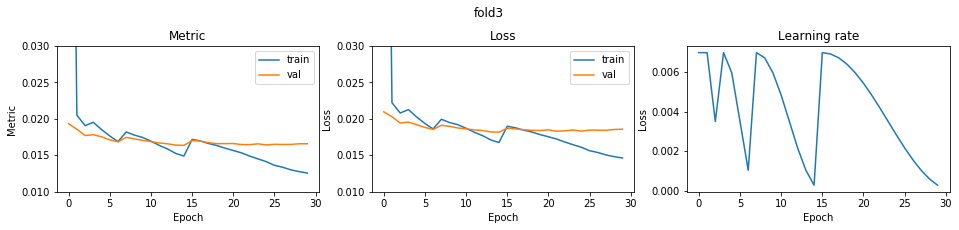

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.019347576043464598
epoch2 save best model... 0.01827010081737283
epoch3 save best model... 0.017606191841168392
epoch5 save best model... 0.017250929197937182
epoch6 save best model... 0.016937320877570904
epoch7 save best model... 0.016688002466069267
epoch12 save best model... 0.016589846338542148
epoch13 save best model... 0.016468216435971048
epoch14 save best model... 0.016379081014891692
epoch15 save best model... 0.016314930170095592
fold4 score: 0.016314930195534497


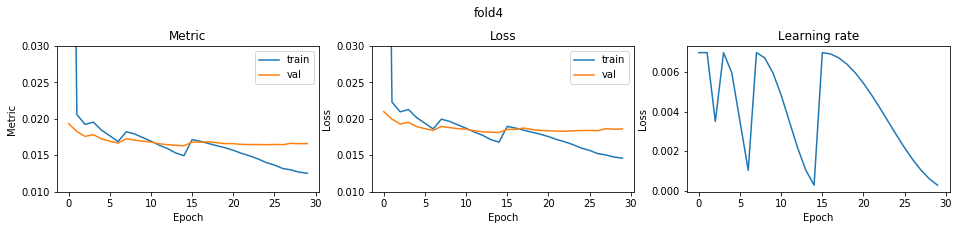

CV score: 0.016292926703303193

optimizer: AdaBound
fold 0


epoch1 save best model... 0.022285758261834026
epoch2 save best model... 0.02161738666915812
epoch3 save best model... 0.021407807035401363
epoch4 save best model... 0.021210204526476546
epoch5 save best model... 0.021064297505283137
epoch6 save best model... 0.02100611772379734
epoch8 save best model... 0.020909436960155167
epoch9 save best model... 0.02082617802626044
epoch10 save best model... 0.02074175739071092
epoch11 save best model... 0.02074020357637036
epoch12 save best model... 0.020688298727324177
epoch13 save best model... 0.020661783944772968
epoch14 save best model... 0.020647650211200897
epoch17 save best model... 0.020595061474380026
epoch18 save best model... 0.020567773363143544
epoch19 save best model... 0.020551450391870698
epoch20 save best model... 0.02050018682906188
epoch21 save best model... 0.020464655644937095
epoch24 save best model... 0.02040453252206495
epoch26 save best model... 0.020398679746480356
epoch27 save best model... 0.020383520759557266
epoch29

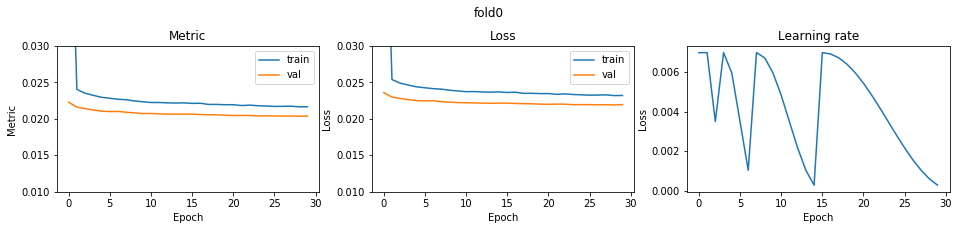

fold 1


epoch1 save best model... 0.02242248769069511
epoch2 save best model... 0.02162146424133255
epoch3 save best model... 0.021468897637656296
epoch4 save best model... 0.02122158680164643
epoch5 save best model... 0.0211299273600697
epoch6 save best model... 0.021019703177465723
epoch7 save best model... 0.021003693814554282
epoch8 save best model... 0.02089517913830052
epoch9 save best model... 0.02082858981908821
epoch10 save best model... 0.02077645242747236
epoch11 save best model... 0.020757750252600845
epoch12 save best model... 0.020734848554326123
epoch13 save best model... 0.02067042253809642
epoch16 save best model... 0.020631951546666968
epoch17 save best model... 0.020566080070269843
epoch19 save best model... 0.020562795970964932
epoch20 save best model... 0.020487426620806017
epoch22 save best model... 0.020417379383417898
epoch23 save best model... 0.020400083849813868
epoch24 save best model... 0.020381122992193
epoch25 save best model... 0.02037946575916039
epoch27 save b

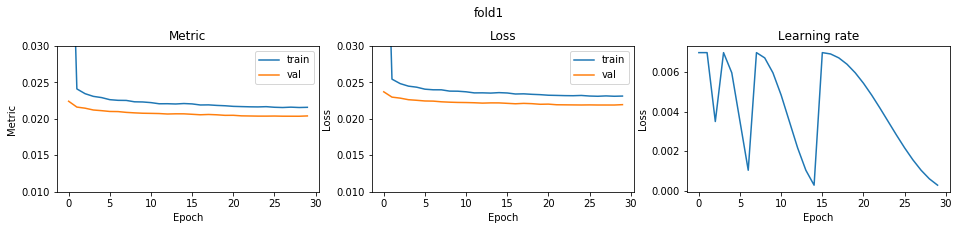

fold 2


epoch1 save best model... 0.022582083008971212
epoch2 save best model... 0.02167687552780979
epoch3 save best model... 0.02152502446336297
epoch4 save best model... 0.021250791170380333
epoch5 save best model... 0.021102079354764713
epoch6 save best model... 0.021020341545299262
epoch7 save best model... 0.021003063524548896
epoch8 save best model... 0.020852375833292598
epoch9 save best model... 0.020799915248765358
epoch11 save best model... 0.020700091639129194
epoch13 save best model... 0.020637780112611404
epoch16 save best model... 0.02061502172342803
epoch17 save best model... 0.02054647329917161
epoch18 save best model... 0.020494783074376684
epoch19 save best model... 0.02048441542341786
epoch20 save best model... 0.020434992372612797
epoch23 save best model... 0.020358624722741546
epoch25 save best model... 0.02035382651870548
epoch26 save best model... 0.02034031153387267
epoch27 save best model... 0.02033681663992017
epoch28 save best model... 0.020334277122085635
epoch29 s

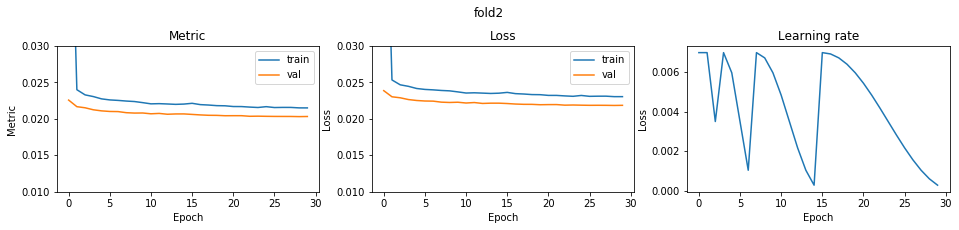

fold 3


epoch1 save best model... 0.022498222231729155
epoch2 save best model... 0.021698706358637247
epoch3 save best model... 0.021587562339554344
epoch4 save best model... 0.021335199971710902
epoch5 save best model... 0.02120829671536464
epoch6 save best model... 0.021104441715535924
epoch8 save best model... 0.021018371491741752
epoch9 save best model... 0.02097665684335867
epoch10 save best model... 0.020880287071023823
epoch11 save best model... 0.02081871856054915
epoch12 save best model... 0.02080452568099276
epoch13 save best model... 0.02079104712712398
epoch14 save best model... 0.02077322904071463
epoch16 save best model... 0.02075584054646636
epoch17 save best model... 0.020676767741646066
epoch18 save best model... 0.02064626551443257
epoch19 save best model... 0.020633232927454767
epoch20 save best model... 0.020571051221892477
epoch21 save best model... 0.020560369423775166
epoch22 save best model... 0.02056030183139518
epoch23 save best model... 0.020543063481196184
epoch24 s

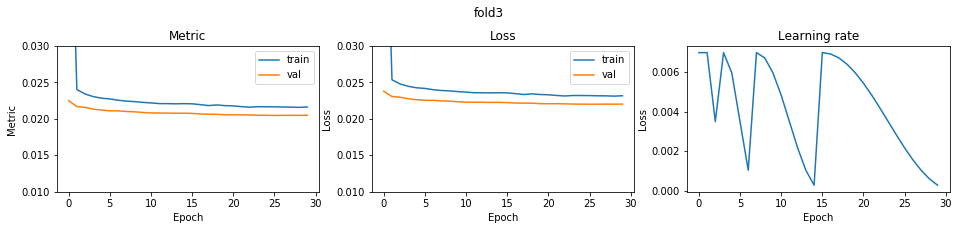

fold 4


epoch1 save best model... 0.02235848114216925
epoch2 save best model... 0.02156207610965454
epoch3 save best model... 0.021347444619907063
epoch4 save best model... 0.021150004757665826
epoch5 save best model... 0.020981471618989604
epoch6 save best model... 0.020958469433875453
epoch7 save best model... 0.020916397670169354
epoch8 save best model... 0.020838515317928817
epoch9 save best model... 0.020794291274117173
epoch10 save best model... 0.02069143584944257
epoch11 save best model... 0.02066769799247282
epoch12 save best model... 0.02064781216968165
epoch13 save best model... 0.020614920696561862
epoch14 save best model... 0.020599724872542677
epoch16 save best model... 0.02055906893808505
epoch17 save best model... 0.020526320791054424
epoch18 save best model... 0.02049264485495916
epoch19 save best model... 0.02044886705425307
epoch20 save best model... 0.020420647090076044
epoch22 save best model... 0.020406654934507024
epoch23 save best model... 0.020404079645566627
epoch24 s

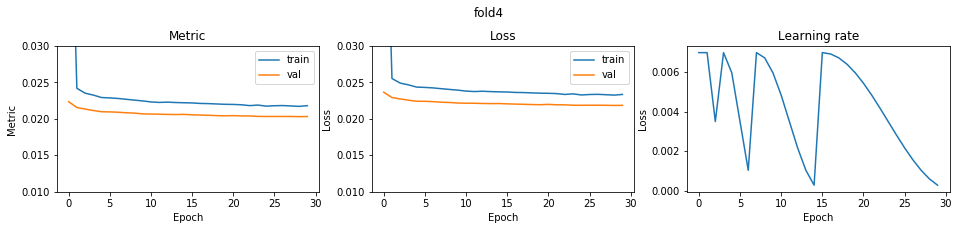

CV score: 0.020365119479579013

optimizer: AdaMod
fold 0


epoch1 save best model... 0.019727686352196207
epoch2 save best model... 0.01858988045067749
epoch3 save best model... 0.017845366559158967
epoch4 save best model... 0.01757863065936435
epoch5 save best model... 0.017431188088784456
epoch6 save best model... 0.016928183237315583
epoch7 save best model... 0.0165736861823971
epoch12 save best model... 0.016555707101500117
epoch13 save best model... 0.016249433849728188
epoch14 save best model... 0.016127906852997923
epoch15 save best model... 0.016082508605321476
fold0 score: 0.01608250848262131


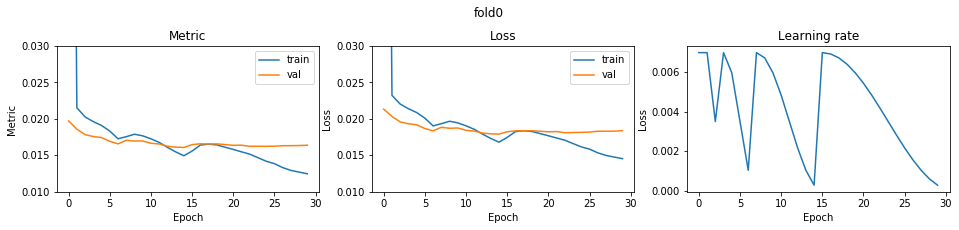

fold 1


epoch1 save best model... 0.020107851819724937
epoch2 save best model... 0.018892066226030815
epoch3 save best model... 0.01791815039964669
epoch4 save best model... 0.017897305671888703
epoch5 save best model... 0.017620198488894127
epoch6 save best model... 0.01728451457197145
epoch7 save best model... 0.0168615869263611
epoch12 save best model... 0.01676181613113905
epoch13 save best model... 0.016584701466253786
epoch14 save best model... 0.01645099010091894
epoch15 save best model... 0.016394811472330326
fold1 score: 0.016394811489101078


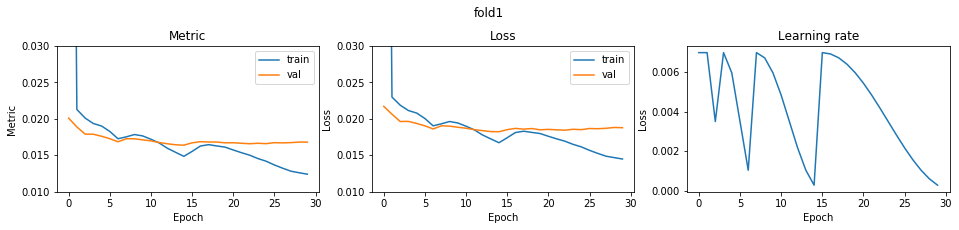

fold 2


epoch1 save best model... 0.019880531933332637
epoch2 save best model... 0.018589188187752546
epoch3 save best model... 0.017811492565653474
epoch4 save best model... 0.017747006531211505
epoch5 save best model... 0.017416225617047417
epoch6 save best model... 0.017098897974492544
epoch7 save best model... 0.016733511177473674
epoch11 save best model... 0.016659706205004003
epoch12 save best model... 0.016619821917244433
epoch13 save best model... 0.016327456904095244
epoch14 save best model... 0.01622942345538133
epoch15 save best model... 0.016152284324540925
fold2 score: 0.016152284164283572


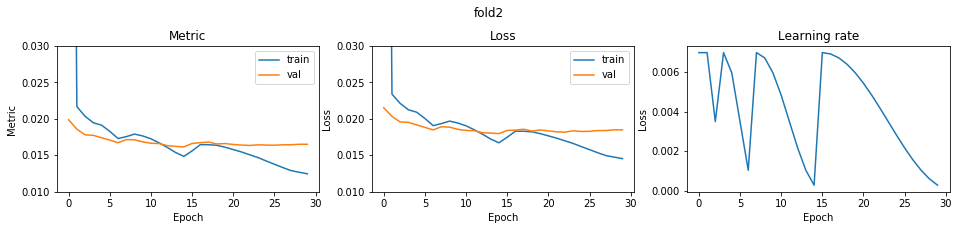

fold 3


epoch1 save best model... 0.020100376917927574
epoch2 save best model... 0.018684304679970943
epoch3 save best model... 0.018038166991110407
epoch4 save best model... 0.017877270793860485
epoch5 save best model... 0.01761330044648031
epoch6 save best model... 0.01724131609395927
epoch7 save best model... 0.016872282725480938
epoch12 save best model... 0.016754391611233387
epoch13 save best model... 0.01658082902134483
epoch14 save best model... 0.016408353777080435
epoch15 save best model... 0.016352866508983127
fold3 score: 0.01635286645671973


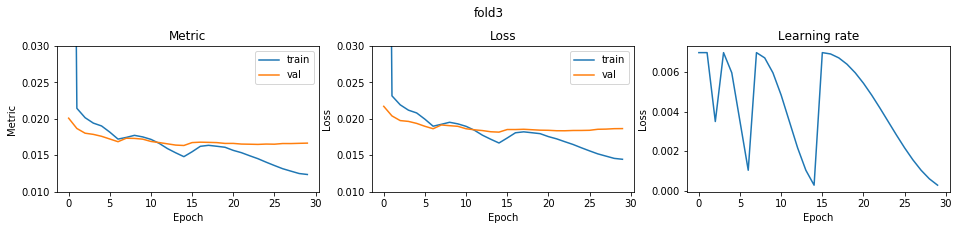

fold 4


epoch1 save best model... 0.019733937380831172
epoch2 save best model... 0.018391288491072036
epoch3 save best model... 0.017695354237931872
epoch5 save best model... 0.01747100166679447
epoch6 save best model... 0.017039310119638818
epoch7 save best model... 0.01674252841706496
epoch13 save best model... 0.01652236546396123
epoch14 save best model... 0.016426058690188823
epoch15 save best model... 0.016354181536458484
fold4 score: 0.01635418145700842


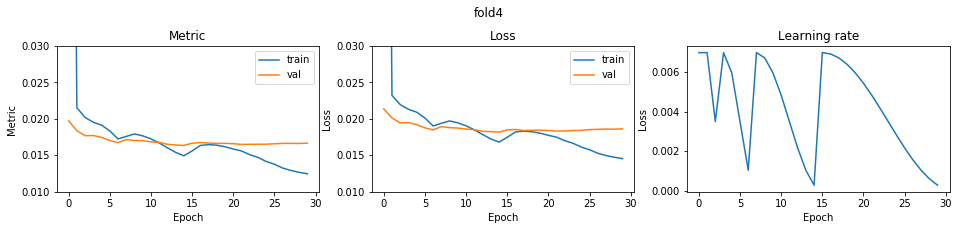

CV score: 0.016267329843387978

optimizer: AdamW
fold 0


epoch1 save best model... 0.01995389378355956
epoch2 save best model... 0.018522652362500888
epoch3 save best model... 0.017625736617451378
epoch4 save best model... 0.0175806317614192
epoch5 save best model... 0.01733208903979196
epoch6 save best model... 0.016909933187797294
epoch7 save best model... 0.016670422110036186
epoch11 save best model... 0.016638109300938987
epoch12 save best model... 0.01638492094374056
epoch13 save best model... 0.016237958524893792
epoch14 save best model... 0.016143478246953058
epoch15 save best model... 0.01610316137543504
fold0 score: 0.016103161448657734


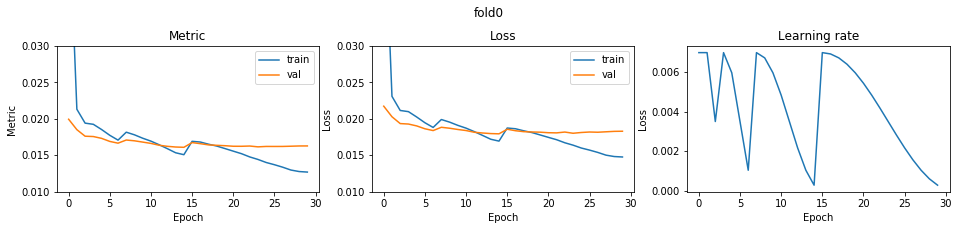

fold 1


epoch1 save best model... 0.019863268304900553
epoch2 save best model... 0.01878354764709198
epoch3 save best model... 0.017968264369577963
epoch4 save best model... 0.017776169117958568
epoch5 save best model... 0.017481443753364582
epoch6 save best model... 0.01712405682543764
epoch7 save best model... 0.016866306314492284
epoch12 save best model... 0.01673105766109343
epoch13 save best model... 0.016587542455900595
epoch14 save best model... 0.016548848959858583
epoch15 save best model... 0.016482765115814497
fold1 score: 0.016482764997627568


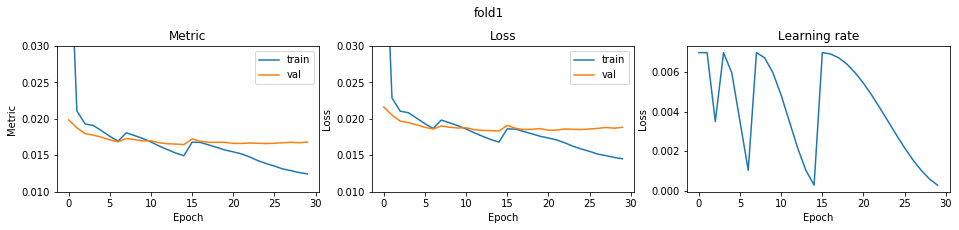

fold 2


epoch1 save best model... 0.020031227513988187
epoch2 save best model... 0.018517921740046177
epoch3 save best model... 0.017794409080767758
epoch4 save best model... 0.017671045338182007
epoch5 save best model... 0.017428477688364245
epoch6 save best model... 0.0169894218637497
epoch7 save best model... 0.016689068699961344
epoch11 save best model... 0.016628269186359273
epoch12 save best model... 0.016445363520570973
epoch13 save best model... 0.016312793233977427
epoch14 save best model... 0.016282540475484938
epoch15 save best model... 0.016196772927877964
fold2 score: 0.01619677286265067


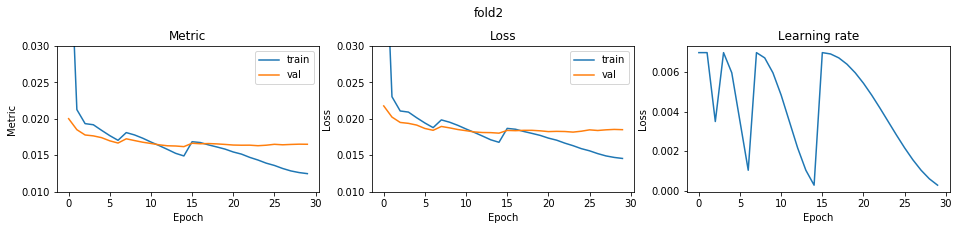

fold 3


epoch1 save best model... 0.0199067949268602
epoch2 save best model... 0.01873005282405365
epoch3 save best model... 0.018014858483606292
epoch5 save best model... 0.01754494618310472
epoch6 save best model... 0.01720579966249322
epoch7 save best model... 0.01693344275193429
epoch11 save best model... 0.01680245464604034
epoch12 save best model... 0.016676993598919658
epoch13 save best model... 0.01654970330867178
epoch14 save best model... 0.016413978576778957
fold3 score: 0.016413978551440125


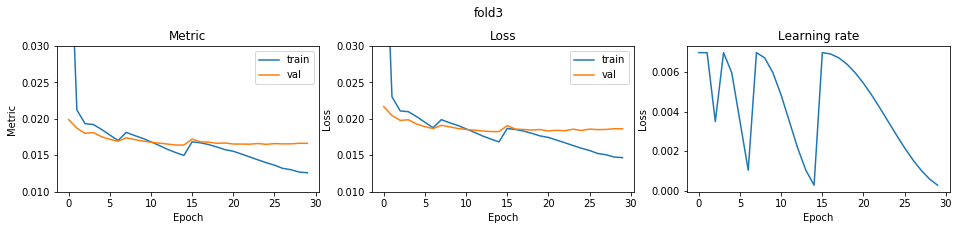

fold 4


epoch1 save best model... 0.020504870205472706
epoch2 save best model... 0.01838134840249608
epoch3 save best model... 0.017717026031081797
epoch4 save best model... 0.017641412713278536
epoch5 save best model... 0.017323605193499823
epoch6 save best model... 0.017086739145677564
epoch7 save best model... 0.01682351919480839
epoch12 save best model... 0.01656450548406546
epoch13 save best model... 0.01643950284367474
epoch15 save best model... 0.016416496765250362
fold4 score: 0.016416496734157147


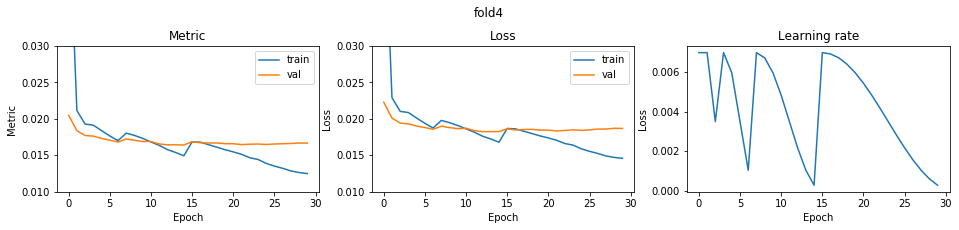

CV score: 0.01632263335757885

optimizer: AdamP
fold 0


epoch1 save best model... 0.02078800522690482
epoch2 save best model... 0.01876420739418689
epoch3 save best model... 0.017657589219120206
epoch5 save best model... 0.017379599890262228
epoch6 save best model... 0.01702228167130355
epoch7 save best model... 0.016676381738657018
epoch11 save best model... 0.01663646342016434
epoch12 save best model... 0.016597063186873335
epoch13 save best model... 0.016290840624507034
epoch14 save best model... 0.01624196953477512
epoch15 save best model... 0.016165825851040982
fold0 score: 0.016165825719423522


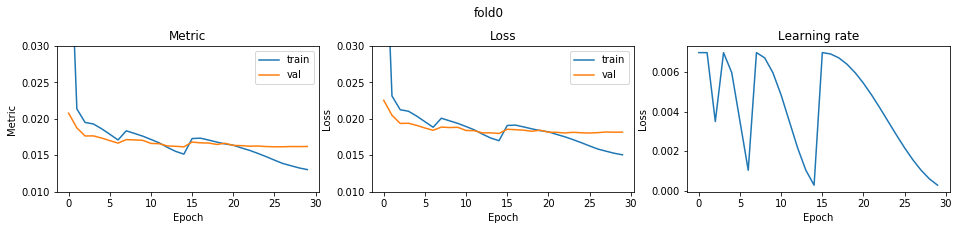

fold 1


epoch1 save best model... 0.019764554045379745
epoch2 save best model... 0.018609238732041733
epoch3 save best model... 0.017774156507169993
epoch4 save best model... 0.017769056259244714
epoch5 save best model... 0.017607407140640824
epoch6 save best model... 0.017178699443374388
epoch7 save best model... 0.016806516606860604
epoch12 save best model... 0.01670370598472816
epoch13 save best model... 0.01648722246363946
epoch14 save best model... 0.01647300387128566
epoch15 save best model... 0.016355660489589946
fold1 score: 0.01635566037493802


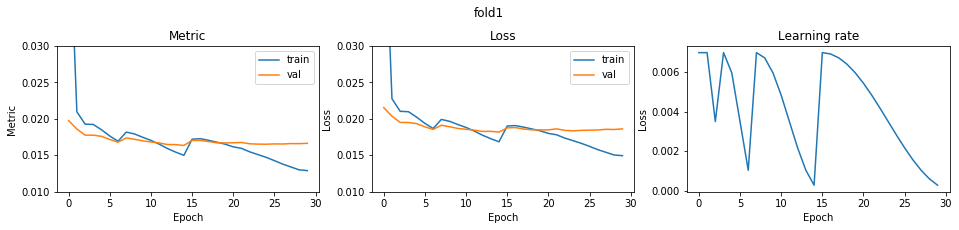

fold 2


epoch1 save best model... 0.02055298665054202
epoch2 save best model... 0.018698090722194076
epoch3 save best model... 0.01791256460057532
epoch4 save best model... 0.017843637592949636
epoch5 save best model... 0.017334782924374924
epoch6 save best model... 0.017017135865974465
epoch7 save best model... 0.016677174337995936
epoch12 save best model... 0.016506574950996836
epoch13 save best model... 0.016417608917222923
epoch14 save best model... 0.01623554635172513
epoch15 save best model... 0.016199644642894143
fold2 score: 0.016199644646343436


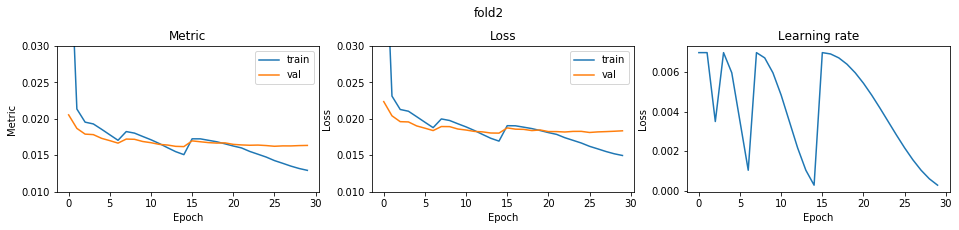

fold 3


epoch1 save best model... 0.020021967316186374
epoch2 save best model... 0.01858424391079872
epoch3 save best model... 0.01789609816324195
epoch5 save best model... 0.017489874957379692
epoch6 save best model... 0.017141935918777162
epoch7 save best model... 0.016863151588360513
epoch12 save best model... 0.01666331563806819
epoch13 save best model... 0.016548532459265415
epoch14 save best model... 0.016429655742248125
epoch15 save best model... 0.01638964537089873
fold3 score: 0.016389645242635337


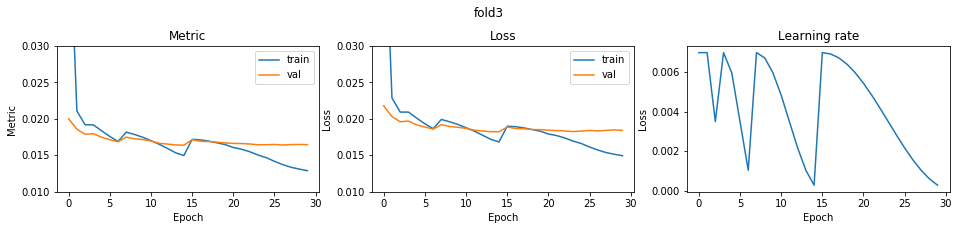

fold 4


epoch1 save best model... 0.019717208022816034
epoch2 save best model... 0.018376326467205426
epoch3 save best model... 0.017694853259789374
epoch5 save best model... 0.017492885538005612
epoch6 save best model... 0.017064988222779336
epoch7 save best model... 0.016805460254379585
epoch11 save best model... 0.016788759276033263
epoch12 save best model... 0.016687332823499188
epoch13 save best model... 0.01647576066179536
epoch14 save best model... 0.016385878964936137
epoch15 save best model... 0.016338328128269023
fold4 score: 0.016338328082759025


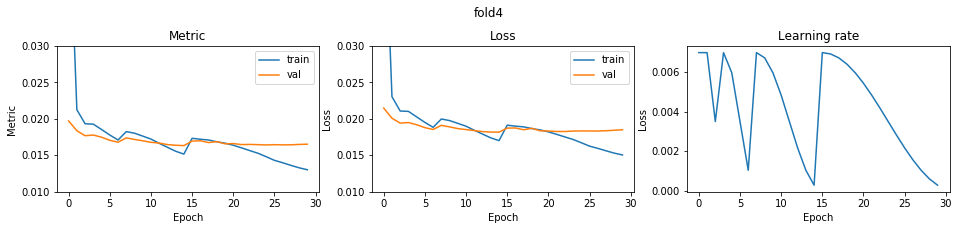

CV score: 0.016289821922050064

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.020084545521197122
epoch2 save best model... 0.01878751601964439
epoch3 save best model... 0.018026214655582073
epoch4 save best model... 0.01784027690207904
epoch5 save best model... 0.01741481031246636
epoch6 save best model... 0.017045975488383568
epoch7 save best model... 0.016774156015018395
epoch10 save best model... 0.016756811457132426
epoch11 save best model... 0.01660312862561884
epoch12 save best model... 0.016483026650439363
epoch13 save best model... 0.016319076881525455
epoch14 save best model... 0.01620047121968519
epoch15 save best model... 0.01615983065989946
fold0 score: 0.016159830601619653


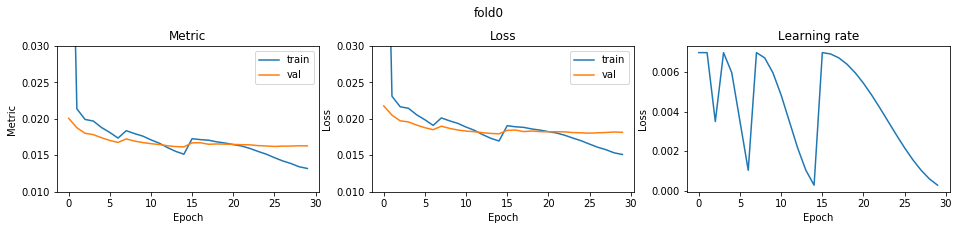

fold 1


epoch1 save best model... 0.020384076222230752
epoch2 save best model... 0.01876320878769901
epoch3 save best model... 0.018005575703982816
epoch4 save best model... 0.01789326109348587
epoch5 save best model... 0.01751051824578095
epoch6 save best model... 0.017179087417420465
epoch7 save best model... 0.01688932593148834
epoch12 save best model... 0.01675537591182607
epoch13 save best model... 0.016609765005277374
epoch14 save best model... 0.016513951773137553
epoch15 save best model... 0.01642842259403173
fold1 score: 0.01642842260111887


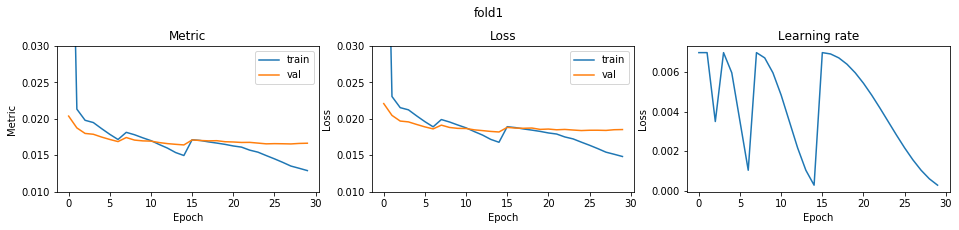

fold 2


epoch1 save best model... 0.02030810342299949
epoch2 save best model... 0.01884306163995385
epoch3 save best model... 0.01798061008220736
epoch4 save best model... 0.017905675225964805
epoch5 save best model... 0.017460114178946932
epoch6 save best model... 0.01706375110759486
epoch7 save best model... 0.0167702616916621
epoch12 save best model... 0.016566501034894356
epoch13 save best model... 0.016353984157123837
epoch14 save best model... 0.01629726171275394
epoch15 save best model... 0.016231507806866635
fold2 score: 0.016231507695952035


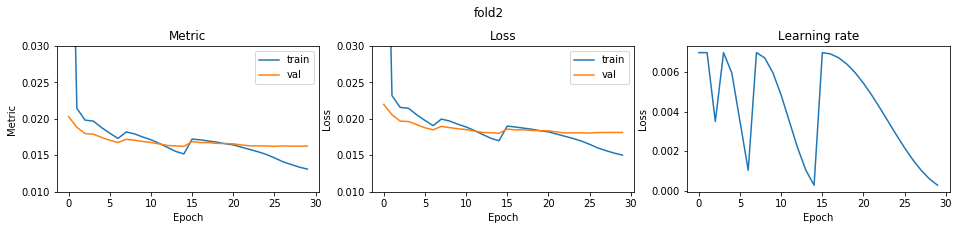

fold 3


epoch1 save best model... 0.020294850838533975
epoch2 save best model... 0.019104080129168706
epoch3 save best model... 0.018291308828852305
epoch4 save best model... 0.018162864381723223
epoch5 save best model... 0.0175773765153521
epoch6 save best model... 0.01730371399873821
epoch7 save best model... 0.01709171234924932
epoch11 save best model... 0.01697203113500173
epoch12 save best model... 0.016691993369141716
epoch13 save best model... 0.016590763139697578
epoch14 save best model... 0.016494171487714815
epoch15 save best model... 0.016444314395105106
fold3 score: 0.01644431432101226


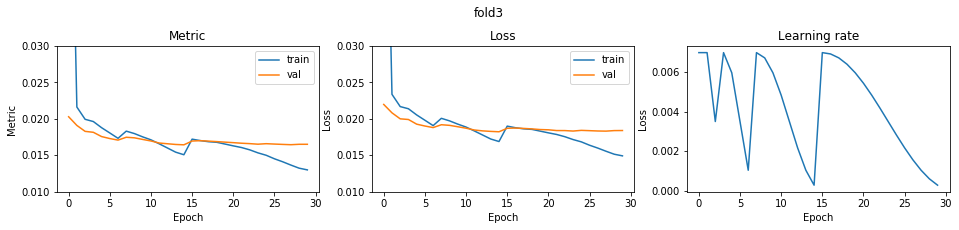

fold 4


epoch1 save best model... 0.019996864281611727
epoch2 save best model... 0.018711131000742825
epoch3 save best model... 0.017884899012252247
epoch4 save best model... 0.01783948742735766
epoch5 save best model... 0.017412061955788278
epoch6 save best model... 0.017060884610582184
epoch7 save best model... 0.01686448280260408
epoch11 save best model... 0.01675794590434276
epoch12 save best model... 0.016701197413757342
epoch13 save best model... 0.01644889754041656
epoch14 save best model... 0.016365681595862727
epoch15 save best model... 0.016318456086506197
fold4 score: 0.01631845615852105


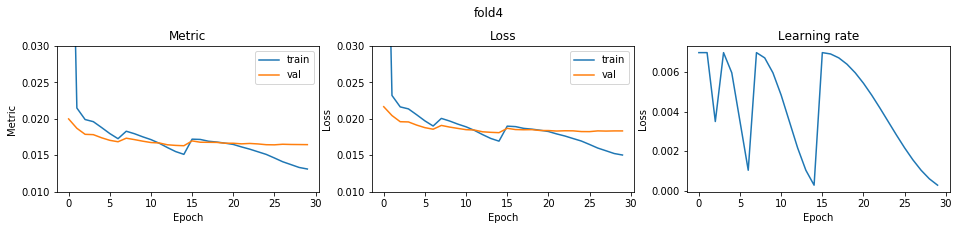

CV score: 0.016316505049212036

optimizer: Lamb
fold 0


epoch1 save best model... 0.020170473498302876
epoch2 save best model... 0.01836798859077054
epoch3 save best model... 0.017682953464007323
epoch5 save best model... 0.01726105426923968
epoch6 save best model... 0.01690660918169657
epoch7 save best model... 0.016789682474250403
epoch9 save best model... 0.016759666287104742
epoch10 save best model... 0.016619226286412644
epoch11 save best model... 0.01649235026796342
epoch12 save best model... 0.016359293579647917
epoch13 save best model... 0.016319938048991907
epoch14 save best model... 0.01624696011780199
epoch15 save best model... 0.01622478916205822
fold0 score: 0.016224789167847573


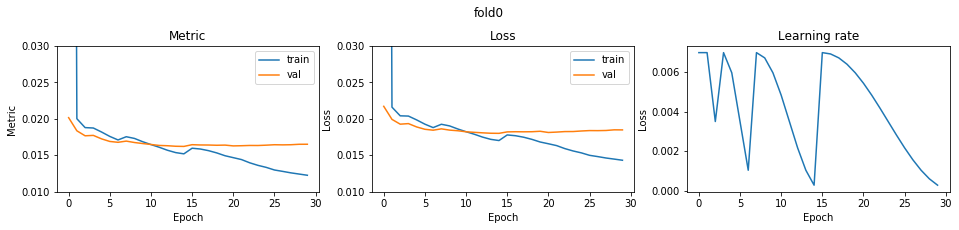

fold 1


epoch1 save best model... 0.02003333178610051
epoch2 save best model... 0.01838154188429652
epoch3 save best model... 0.018043517168398245
epoch4 save best model... 0.01778618382800546
epoch5 save best model... 0.017459373211576826
epoch6 save best model... 0.017208807583321984
epoch7 save best model... 0.01702831573313279
epoch11 save best model... 0.016783595128007374
epoch12 save best model... 0.01664133711598557
epoch13 save best model... 0.016597712607271282
epoch14 save best model... 0.016525926010071634
epoch15 save best model... 0.01650870579837442
fold1 score: 0.016508705811868286


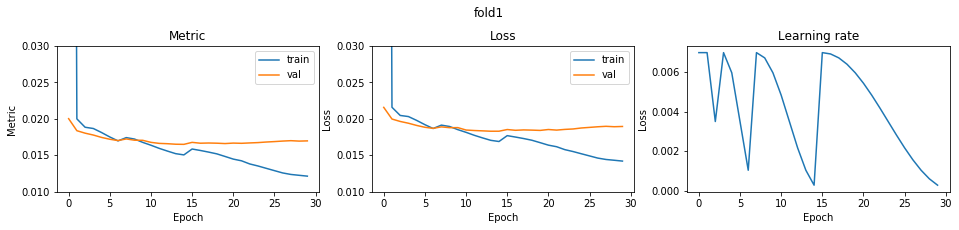

fold 2


epoch1 save best model... 0.020073322249938453
epoch2 save best model... 0.018440485761116187
epoch3 save best model... 0.017789065768260243
epoch4 save best model... 0.017664743675859882
epoch5 save best model... 0.01734416642285481
epoch6 save best model... 0.01706294854773995
epoch7 save best model... 0.01684453769267203
epoch9 save best model... 0.016787400732517554
epoch10 save best model... 0.01666945751118148
epoch11 save best model... 0.01654059088397003
epoch12 save best model... 0.016459037022702065
epoch13 save best model... 0.016358428156628482
epoch14 save best model... 0.01631003282993937
epoch15 save best model... 0.01627957009290014
fold2 score: 0.01627957002126497


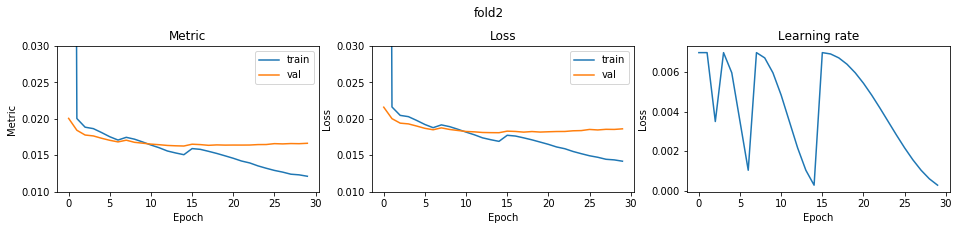

fold 3


epoch1 save best model... 0.02048412424751933
epoch2 save best model... 0.018571609740224
epoch3 save best model... 0.01789549188582324
epoch4 save best model... 0.017789285098348907
epoch5 save best model... 0.017556008783111813
epoch6 save best model... 0.017214523228246015
epoch7 save best model... 0.017076297895240348
epoch10 save best model... 0.01694400264692741
epoch11 save best model... 0.016836545484008984
epoch12 save best model... 0.01666000218752237
epoch13 save best model... 0.016567061554241695
epoch14 save best model... 0.016564427764666243
epoch15 save best model... 0.016500626806093377
epoch20 save best model... 0.016447340902832074
fold3 score: 0.016447340923653186


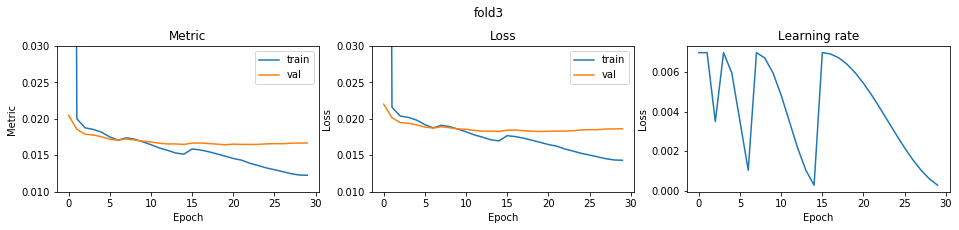

fold 4


epoch1 save best model... 0.01986548883632538
epoch2 save best model... 0.018252723320792502
epoch3 save best model... 0.017835109151797986
epoch4 save best model... 0.017559618196091645
epoch5 save best model... 0.017305137441495692
epoch6 save best model... 0.01710250388898787
epoch7 save best model... 0.01693854024230687
epoch9 save best model... 0.016904679256022518
epoch10 save best model... 0.01680921082319119
epoch11 save best model... 0.016648601401164483
epoch12 save best model... 0.016602219792256866
epoch13 save best model... 0.016535743794367907
epoch14 save best model... 0.016477172513299353
epoch15 save best model... 0.01645776088856551
fold4 score: 0.01645776086072584


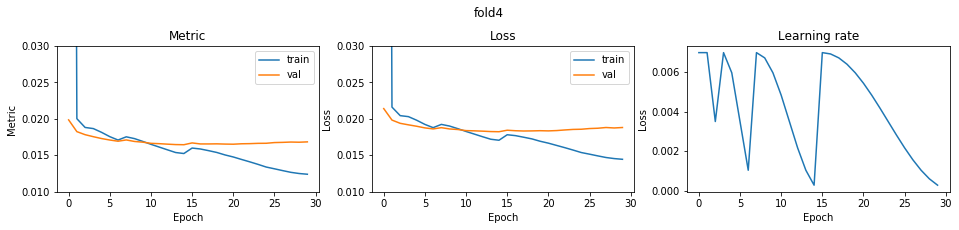

CV score: 0.01638363239984949

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018501669087008083
epoch2 save best model... 0.01772869570278361
epoch3 save best model... 0.017274039113949265
epoch4 save best model... 0.01714400230378659
epoch5 save best model... 0.016968520034045184
epoch6 save best model... 0.01661668827837855
epoch7 save best model... 0.01652014693478653
epoch9 save best model... 0.01647080706182129
epoch10 save best model... 0.01637509592250838
epoch11 save best model... 0.016229761446611892
epoch12 save best model... 0.016178339966710715
epoch13 save best model... 0.016096913054636373
epoch14 save best model... 0.01605954383603872
epoch15 save best model... 0.016045703538661665
fold0 score: 0.01604570345959129


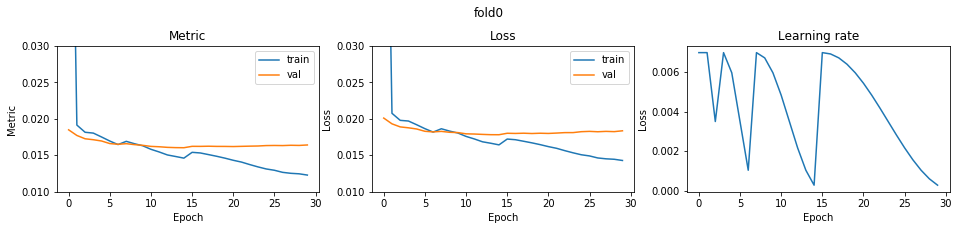

fold 1


epoch1 save best model... 0.018617009714765247
epoch2 save best model... 0.017873448426254886
epoch3 save best model... 0.017452036086822133
epoch4 save best model... 0.01732899474162981
epoch5 save best model... 0.01702078431165688
epoch6 save best model... 0.016886466281863275
epoch7 save best model... 0.01670992883560149
epoch10 save best model... 0.01661272480719744
epoch11 save best model... 0.01651457213985741
epoch13 save best model... 0.01643620501235246
epoch14 save best model... 0.01642437751994206
epoch15 save best model... 0.01640443709558209
fold1 score: 0.016404437047907696


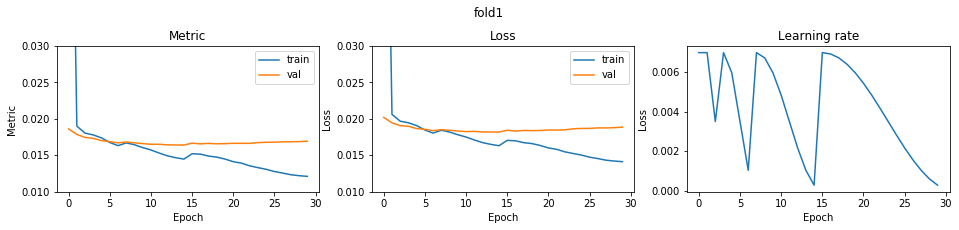

fold 2


epoch1 save best model... 0.01847165915499681
epoch2 save best model... 0.017696845147221446
epoch3 save best model... 0.017278739835368415
epoch4 save best model... 0.017130880226591406
epoch5 save best model... 0.017025548771641662
epoch6 save best model... 0.016642347129694583
epoch7 save best model... 0.016540014698098193
epoch10 save best model... 0.016465586825940435
epoch11 save best model... 0.01637233152758949
epoch12 save best model... 0.016237518272268648
epoch13 save best model... 0.01619401416452939
epoch14 save best model... 0.016179035431316036
epoch15 save best model... 0.016160788297174485
fold2 score: 0.016160788277231074


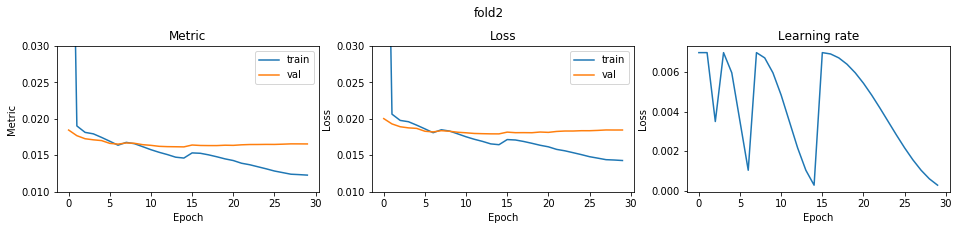

fold 3


epoch1 save best model... 0.01880167521078114
epoch2 save best model... 0.01780090039269256
epoch3 save best model... 0.017476378545453582
epoch4 save best model... 0.017373380809598063
epoch5 save best model... 0.01705255033596841
epoch6 save best model... 0.01682232065011741
epoch7 save best model... 0.01671800032291977
epoch10 save best model... 0.016551161279524242
epoch11 save best model... 0.016464713578598238
epoch12 save best model... 0.01641512733623216
epoch13 save best model... 0.016332081710423316
epoch14 save best model... 0.016289502906704275
epoch15 save best model... 0.016277104422263378
fold3 score: 0.01627710441161678


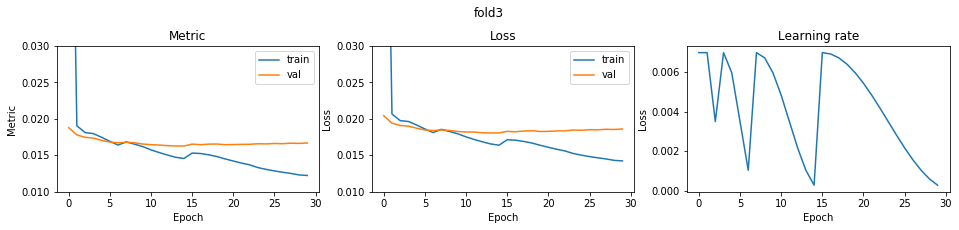

fold 4


epoch1 save best model... 0.018485726282883072
epoch2 save best model... 0.01766435648049472
epoch3 save best model... 0.017360468887233926
epoch4 save best model... 0.0173007831028355
epoch5 save best model... 0.017084721402861262
epoch6 save best model... 0.016737880058382937
epoch7 save best model... 0.01661985442381785
epoch10 save best model... 0.016596170684963395
epoch11 save best model... 0.016506251907888334
epoch12 save best model... 0.01641099369004878
epoch13 save best model... 0.016370120799011956
epoch14 save best model... 0.016357552480792674
fold4 score: 0.016357552425180284


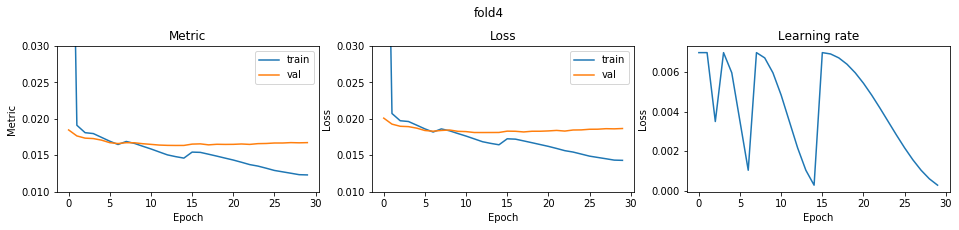

CV score: 0.01624911407204205

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.0201660403213835
epoch2 save best model... 0.018846071517447133
epoch3 save best model... 0.018078937182088375
epoch4 save best model... 0.017832552304741733
epoch5 save best model... 0.017543411179358703
epoch6 save best model... 0.017011297339730492
epoch7 save best model... 0.016671399832416774
epoch12 save best model... 0.016529697081358395
epoch13 save best model... 0.016359631254301663
epoch14 save best model... 0.016286402384502335
epoch15 save best model... 0.01622498441012343
fold0 score: 0.016224984319449114


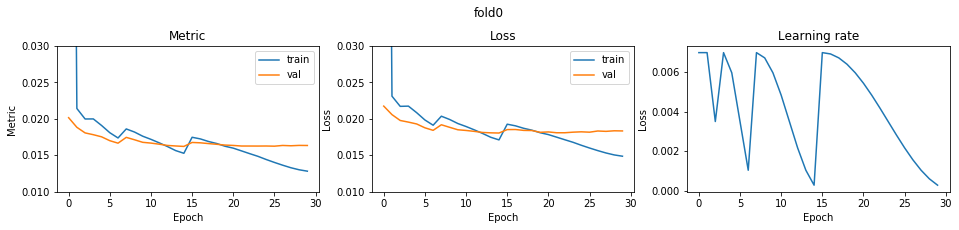

fold 1


epoch1 save best model... 0.020665349191367477
epoch2 save best model... 0.019065509596744058
epoch3 save best model... 0.01815770171653996
epoch5 save best model... 0.017872533672479676
epoch6 save best model... 0.017235422165507157
epoch7 save best model... 0.01700405911987023
epoch11 save best model... 0.016986405808163695
epoch12 save best model... 0.016810065877616853
epoch13 save best model... 0.016637295031507144
epoch14 save best model... 0.016482299209230104
epoch15 save best model... 0.016454468568030293
fold1 score: 0.0164544685386858


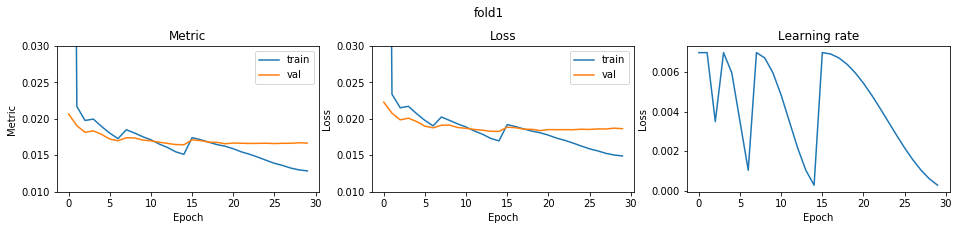

fold 2


epoch1 save best model... 0.02059398761019535
epoch2 save best model... 0.018976091382837047
epoch3 save best model... 0.01799133159563974
epoch5 save best model... 0.017632277013373675
epoch6 save best model... 0.017203842825961834
epoch7 save best model... 0.01682614404911854
epoch11 save best model... 0.016744473731999557
epoch12 save best model... 0.016547697578639803
epoch13 save best model... 0.016445884169570595
epoch14 save best model... 0.01624265437558256
epoch15 save best model... 0.01619838415688563
fold2 score: 0.01619838403952673


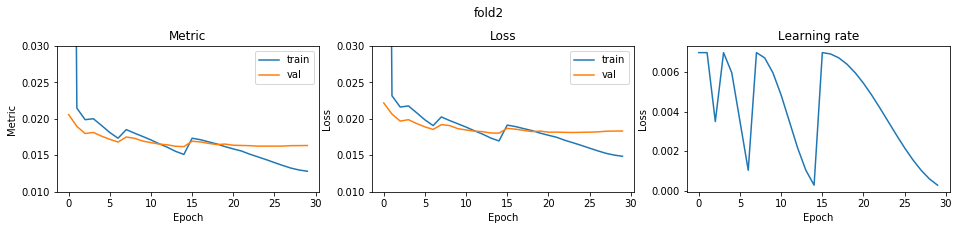

fold 3


epoch1 save best model... 0.020584172861553
epoch2 save best model... 0.019028153864068566
epoch3 save best model... 0.01821575692105945
epoch5 save best model... 0.017761377168390772
epoch6 save best model... 0.017410017556780292
epoch7 save best model... 0.017135104262492786
epoch11 save best model... 0.01704555669914006
epoch12 save best model... 0.016831845064182897
epoch13 save best model... 0.016649974034017204
epoch14 save best model... 0.01652597927897829
epoch15 save best model... 0.01644984331270489
fold3 score: 0.016449843365218937


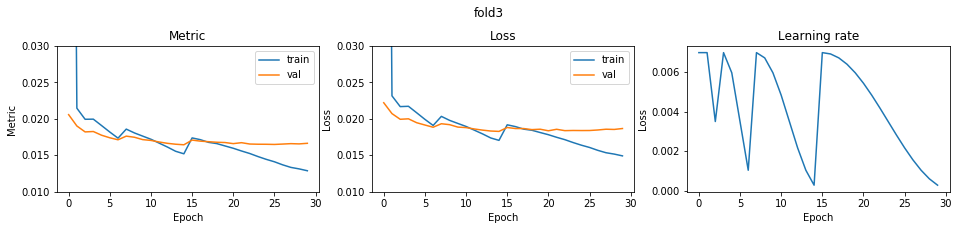

fold 4


epoch1 save best model... 0.019968820282667537
epoch2 save best model... 0.018857354274473593
epoch3 save best model... 0.017919678266472044
epoch5 save best model... 0.01748727053268081
epoch6 save best model... 0.017135859498062546
epoch7 save best model... 0.01685670671819079
epoch12 save best model... 0.016723984283456634
epoch13 save best model... 0.01658483427017927
epoch14 save best model... 0.016476059036333632
epoch15 save best model... 0.016452330556657836
fold4 score: 0.016451564509983425


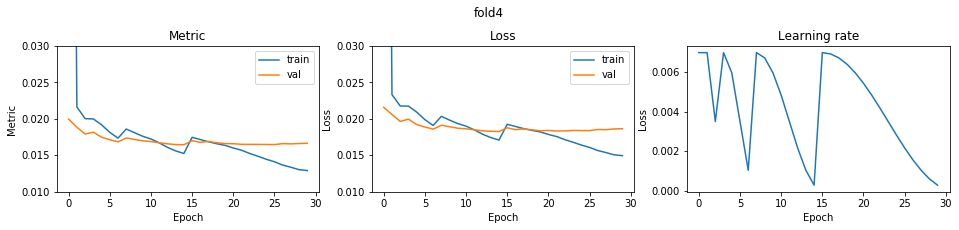

CV score: 0.016355851635697777

optimizer: QHAdam
fold 0


epoch1 save best model... 0.0201504300125707
epoch2 save best model... 0.018420173211663893
epoch3 save best model... 0.017732837907375943
epoch5 save best model... 0.017312301426345232
epoch6 save best model... 0.017010597439147616
epoch7 save best model... 0.016642080585139215
epoch13 save best model... 0.016556656849411464
epoch14 save best model... 0.01630717708913775
epoch15 save best model... 0.016224683733372727
epoch28 save best model... 0.01622225443295846
epoch29 save best model... 0.016201570404349806
epoch30 save best model... 0.016136573383622805
fold0 score: 0.016136573251464812


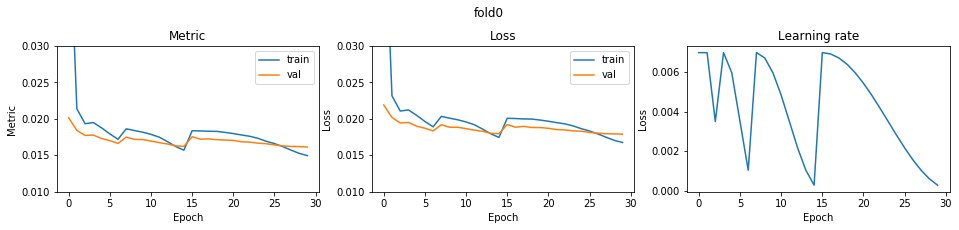

fold 1


epoch1 save best model... 0.0201515352235049
epoch2 save best model... 0.01860007434093713
epoch3 save best model... 0.018070267801979158
epoch4 save best model... 0.01793190221796413
epoch5 save best model... 0.017534314708452774
epoch6 save best model... 0.017203867315777506
epoch7 save best model... 0.016849053650797363
epoch13 save best model... 0.01680687896582247
epoch14 save best model... 0.016586304610218674
epoch15 save best model... 0.016492318287941652
epoch28 save best model... 0.01646862457970853
epoch29 save best model... 0.016430954676351493
epoch30 save best model... 0.01640585798211693
fold1 score: 0.01640585803460127


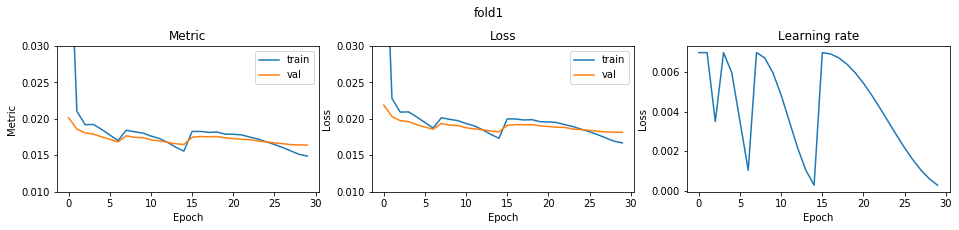

fold 2


epoch1 save best model... 0.020170826498842588
epoch2 save best model... 0.018824111701236088
epoch3 save best model... 0.017732378418560953
epoch5 save best model... 0.01761167674474155
epoch6 save best model... 0.017087405510153388
epoch7 save best model... 0.01669920919436302
epoch13 save best model... 0.016563244451089462
epoch14 save best model... 0.01638707996991765
epoch15 save best model... 0.01627382504000265
epoch29 save best model... 0.01622015519051094
epoch30 save best model... 0.016179617117274715
fold2 score: 0.016179617012014067


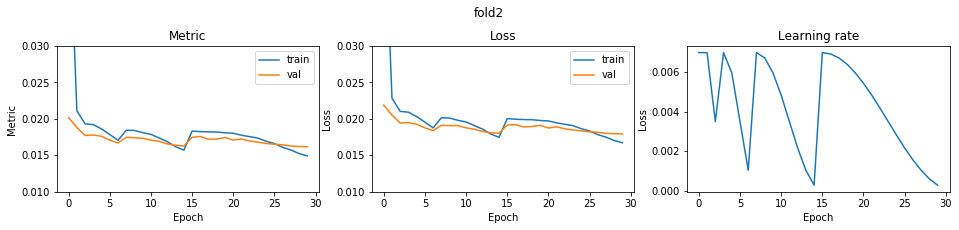

fold 3


epoch1 save best model... 0.02029732412749855
epoch2 save best model... 0.01866816375828889
epoch3 save best model... 0.018000199155275263
epoch4 save best model... 0.017864725421817128
epoch5 save best model... 0.01764652330241673
epoch6 save best model... 0.01730868121893368
epoch7 save best model... 0.016933821296162378
epoch13 save best model... 0.016758822308585965
epoch14 save best model... 0.016552576225819512
epoch15 save best model... 0.01647376351075455
epoch29 save best model... 0.016438203398774724
epoch30 save best model... 0.016397282829537885
fold3 score: 0.016397282716451914


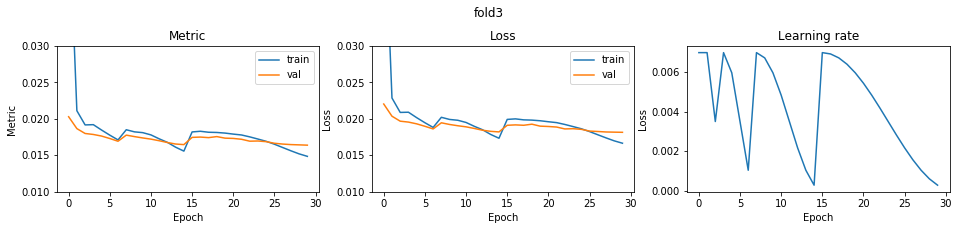

fold 4


epoch1 save best model... 0.019707174635659862
epoch2 save best model... 0.018346688438181453
epoch3 save best model... 0.017674398936484016
epoch5 save best model... 0.01733716449197509
epoch6 save best model... 0.017039950848355516
epoch7 save best model... 0.01680569027196234
epoch13 save best model... 0.016698834439633513
epoch14 save best model... 0.016483067113541253
epoch15 save best model... 0.01640581027318242
epoch30 save best model... 0.01639813356449433
fold4 score: 0.016397367580841055


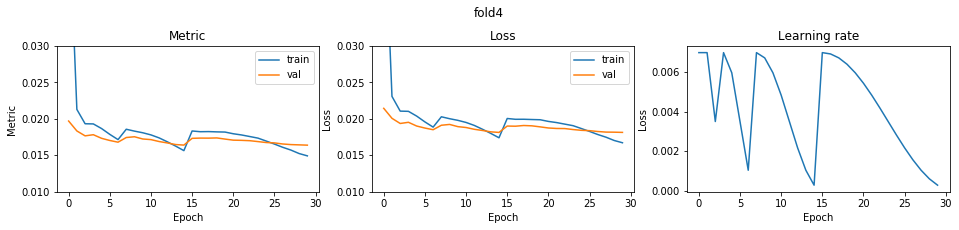

CV score: 0.01630334068519416

optimizer: RAdam
fold 0


epoch1 save best model... 0.02045595294844724
epoch2 save best model... 0.01889260104838292
epoch3 save best model... 0.018047246212194883
epoch4 save best model... 0.017861577821789407
epoch5 save best model... 0.017706026108023246
epoch6 save best model... 0.017046335427799094
epoch7 save best model... 0.016790516665184146
epoch11 save best model... 0.016657246954756066
epoch12 save best model... 0.016447043701463247
epoch13 save best model... 0.016367506040663275
epoch14 save best model... 0.016196111295211018
epoch15 save best model... 0.016169006433889507
epoch25 save best model... 0.01615312678870959
fold0 score: 0.0161531267658032


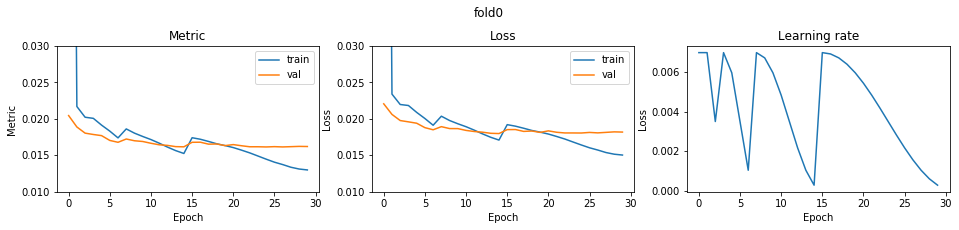

fold 1


epoch1 save best model... 0.020975953959375043
epoch2 save best model... 0.019383817182471442
epoch3 save best model... 0.018191715259564156
epoch5 save best model... 0.017848128706681943
epoch6 save best model... 0.017224036054428956
epoch7 save best model... 0.016918700489714847
epoch12 save best model... 0.01674500901925113
epoch13 save best model... 0.01662068629833004
epoch14 save best model... 0.016565443431217148
epoch15 save best model... 0.01647740709078688
fold1 score: 0.016477407001602946


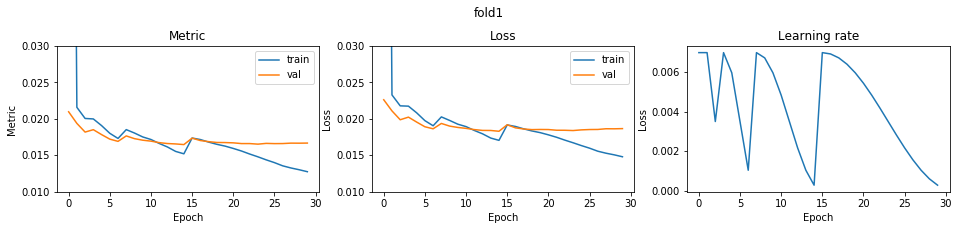

fold 2


epoch1 save best model... 0.021107302544484462
epoch2 save best model... 0.018855312828965083
epoch3 save best model... 0.01798968132174478
epoch5 save best model... 0.01783393892124516
epoch6 save best model... 0.017049855207797334
epoch7 save best model... 0.016762939265847043
epoch11 save best model... 0.016737174840487402
epoch12 save best model... 0.01652270072732035
epoch13 save best model... 0.016443838607914547
epoch14 save best model... 0.01631348343609772
epoch15 save best model... 0.016272614210738792
fold2 score: 0.01627261415480348


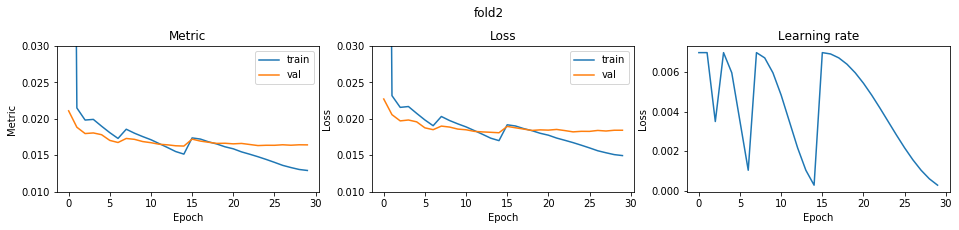

fold 3


epoch1 save best model... 0.020609166628441398
epoch2 save best model... 0.019120348964081674
epoch3 save best model... 0.018243578805721836
epoch5 save best model... 0.017803720544794562
epoch6 save best model... 0.017400731891817955
epoch7 save best model... 0.01698643052801999
epoch11 save best model... 0.016979748664046203
epoch12 save best model... 0.01682742595978098
epoch13 save best model... 0.016584228445905215
epoch14 save best model... 0.016514669448680377
epoch15 save best model... 0.01650927059165709
epoch25 save best model... 0.01642376300719713
fold3 score: 0.01642376287736052


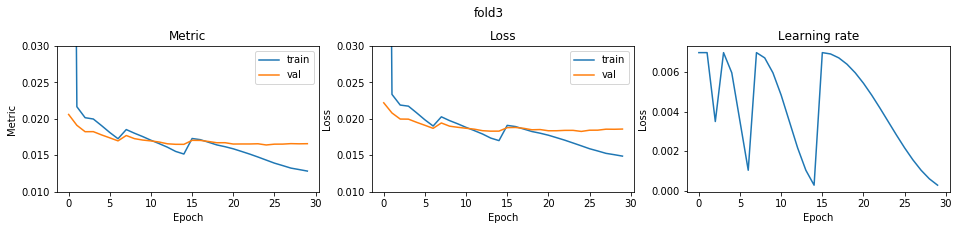

fold 4


epoch1 save best model... 0.019930497577290873
epoch2 save best model... 0.018734040992983654
epoch3 save best model... 0.017759634720708895
epoch5 save best model... 0.017550968562501032
epoch6 save best model... 0.017119849062098322
epoch7 save best model... 0.016927333291967935
epoch11 save best model... 0.01684845042179481
epoch12 save best model... 0.016772302260499337
epoch13 save best model... 0.0165566711807475
epoch14 save best model... 0.016477253892223494
epoch15 save best model... 0.016401257004444583
fold4 score: 0.016401256952680524


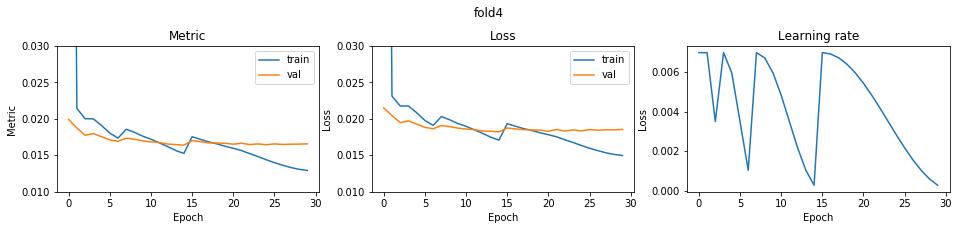

CV score: 0.016345630873483875

optimizer: Ranger
fold 0


epoch1 save best model... 0.02151327611186917
epoch2 save best model... 0.01963745720752415
epoch3 save best model... 0.0186170550440873
epoch4 save best model... 0.018165503903069365
epoch5 save best model... 0.01758009624627158
epoch6 save best model... 0.01726248494279412
epoch7 save best model... 0.016957723528384348
epoch10 save best model... 0.016744667767697695
epoch11 save best model... 0.016648006358593363
epoch12 save best model... 0.016483232789675034
epoch13 save best model... 0.016325916386801316
epoch14 save best model... 0.01621681512174343
epoch15 save best model... 0.016182964680406663
fold0 score: 0.016182964547061675


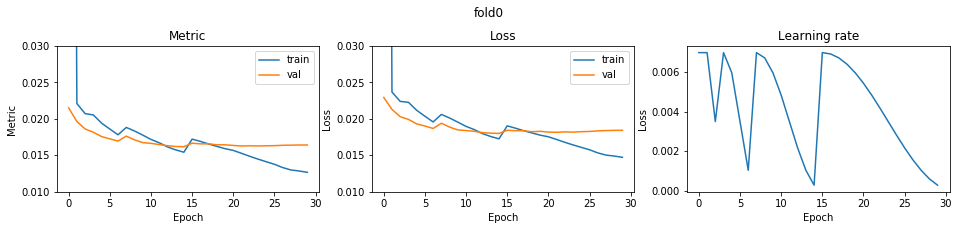

fold 1


epoch1 save best model... 0.021192501914660083
epoch2 save best model... 0.01965827399075004
epoch3 save best model... 0.0187702273954649
epoch4 save best model... 0.0185820959919228
epoch5 save best model... 0.01797278149498639
epoch6 save best model... 0.017534359108073532
epoch7 save best model... 0.01726628185136765
epoch10 save best model... 0.017038233871458197
epoch11 save best model... 0.016935835175061722
epoch12 save best model... 0.016722974593214916
epoch13 save best model... 0.016609800376013298
epoch14 save best model... 0.016494033113588814
epoch15 save best model... 0.016459206337315884
fold1 score: 0.01645920640412909


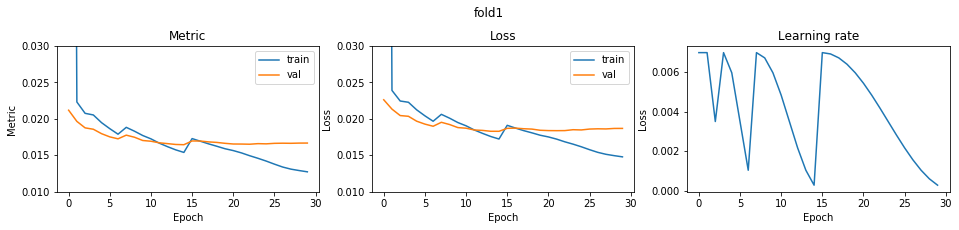

fold 2


epoch1 save best model... 0.0213765499336311
epoch2 save best model... 0.01979082017393448
epoch3 save best model... 0.018708005067114678
epoch4 save best model... 0.018432992947406475
epoch5 save best model... 0.017822116737521966
epoch6 save best model... 0.017266341707675353
epoch7 save best model... 0.017058088556848726
epoch10 save best model... 0.016944097197771846
epoch11 save best model... 0.016718484951689497
epoch12 save best model... 0.016582275339966483
epoch13 save best model... 0.016403491230243143
epoch14 save best model... 0.016291820215632958
epoch15 save best model... 0.016224094894225546
fold2 score: 0.01622409481318196


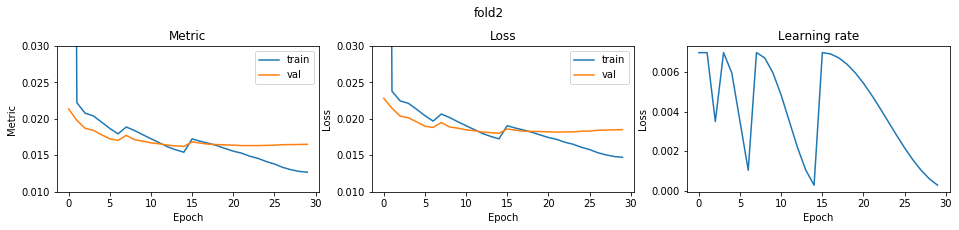

fold 3


epoch1 save best model... 0.021409080036680357
epoch2 save best model... 0.01954600687577879
epoch3 save best model... 0.018780298444924022
epoch4 save best model... 0.018333208474387883
epoch5 save best model... 0.0179520791786848
epoch6 save best model... 0.017568983933156472
epoch7 save best model... 0.01722903589724408
epoch10 save best model... 0.017132072070515918
epoch11 save best model... 0.01695489214907203
epoch12 save best model... 0.016688072434912916
epoch13 save best model... 0.01662039330827416
epoch14 save best model... 0.016433581906309298
epoch15 save best model... 0.01638916607963129
fold3 score: 0.01638916608971934


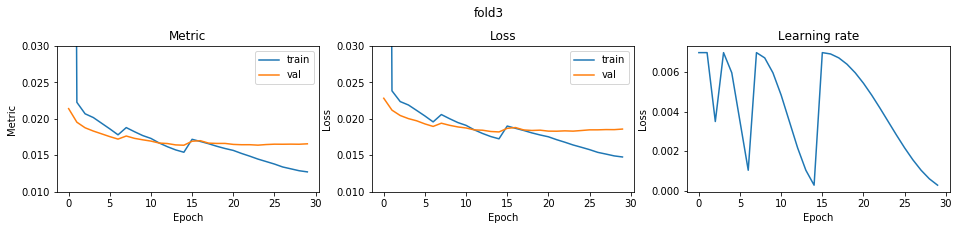

fold 4


epoch1 save best model... 0.020800554082815902
epoch2 save best model... 0.01916444629668375
epoch3 save best model... 0.018458710635475526
epoch4 save best model... 0.01814326052691847
epoch5 save best model... 0.0176447359857771
epoch6 save best model... 0.0173008023194782
epoch7 save best model... 0.017074595810527275
epoch10 save best model... 0.016979314841262163
epoch11 save best model... 0.01679246277847499
epoch12 save best model... 0.01661738960203929
epoch13 save best model... 0.016501050019861626
epoch14 save best model... 0.016430317715726842
epoch15 save best model... 0.01639881799663661
fold4 score: 0.016398817940709774


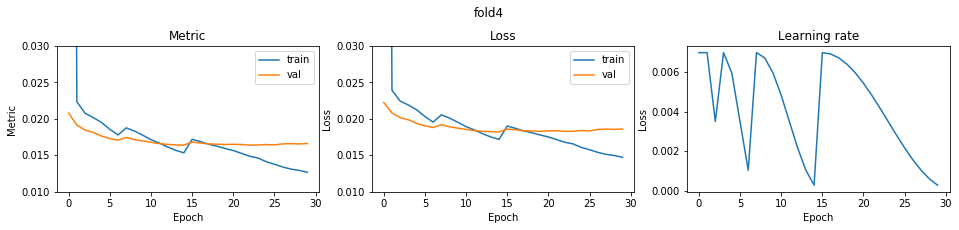

CV score: 0.016330848974756822

optimizer: RangerQH
fold 0


epoch1 save best model... 0.020216503259906194
epoch2 save best model... 0.018826810133925603
epoch3 save best model... 0.01797445646671744
epoch4 save best model... 0.01781150214034631
epoch5 save best model... 0.017498861637670792
epoch6 save best model... 0.016995045141336044
epoch7 save best model... 0.016707343884779815
epoch10 save best model... 0.016675673657710024
epoch11 save best model... 0.016644983519301465
epoch12 save best model... 0.01639056475090546
epoch13 save best model... 0.016256420765335167
epoch14 save best model... 0.016161502551940824
epoch15 save best model... 0.016095036859274048
fold0 score: 0.01609503672540341


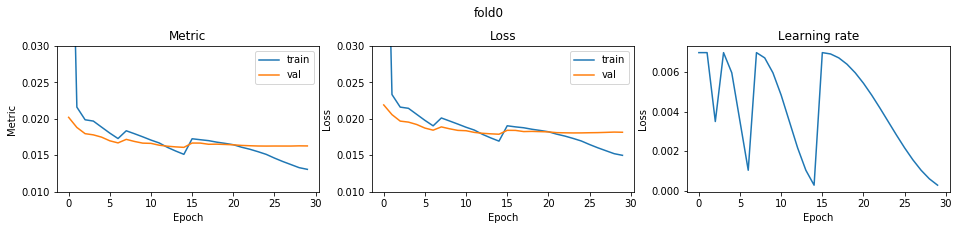

fold 1


epoch1 save best model... 0.0199579531846767
epoch2 save best model... 0.019112337631461803
epoch3 save best model... 0.018148346862435938
epoch4 save best model... 0.01780376266658401
epoch5 save best model... 0.017594960373464533
epoch6 save best model... 0.017196802366809275
epoch7 save best model... 0.01688172240985787
epoch11 save best model... 0.01680640333923508
epoch12 save best model... 0.016638611090248785
epoch13 save best model... 0.016531325911088343
epoch14 save best model... 0.016430090796681982
epoch15 save best model... 0.016345121281755814
fold1 score: 0.01634512117707041


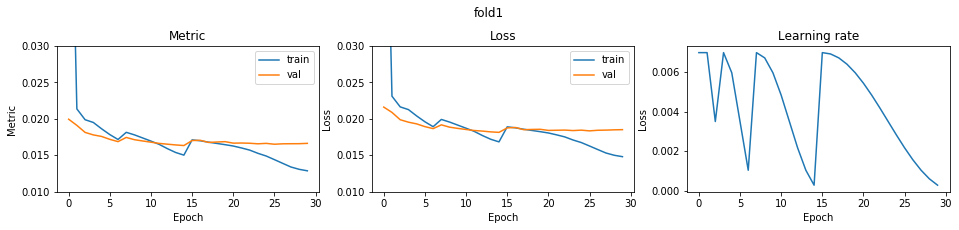

fold 2


epoch1 save best model... 0.020365449334041733
epoch2 save best model... 0.018908753650130117
epoch3 save best model... 0.018151879579034216
epoch4 save best model... 0.017824060421740038
epoch5 save best model... 0.01758004599699645
epoch6 save best model... 0.017011425060029724
epoch7 save best model... 0.016773073828770038
epoch11 save best model... 0.01675141938701255
epoch12 save best model... 0.01647515839089271
epoch13 save best model... 0.01643473144508618
epoch14 save best model... 0.016279542382817574
epoch15 save best model... 0.016216409564320414
fold2 score: 0.016216409594372164


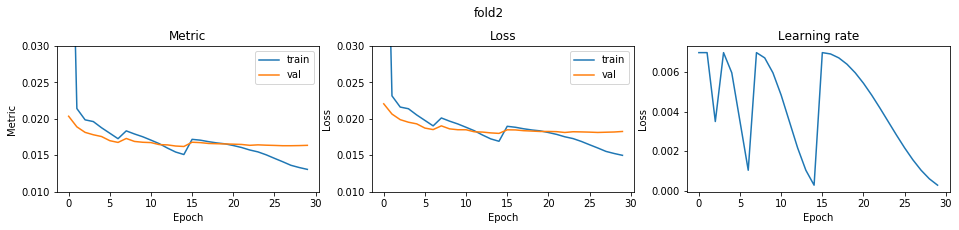

fold 3


epoch1 save best model... 0.020099987894092987
epoch2 save best model... 0.01887183529505154
epoch3 save best model... 0.018116320502903984
epoch4 save best model... 0.01794621348762906
epoch5 save best model... 0.017646888116955892
epoch6 save best model... 0.017223978900098177
epoch7 save best model... 0.016981912051711512
epoch10 save best model... 0.016979795817820387
epoch12 save best model... 0.016606293252514406
epoch13 save best model... 0.016558081405088815
epoch14 save best model... 0.016437297013581886
epoch15 save best model... 0.016371061063556167
fold3 score: 0.016371061023763255


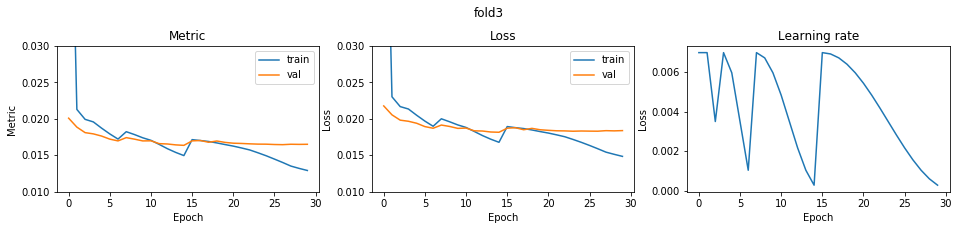

fold 4


epoch1 save best model... 0.01981989337483544
epoch2 save best model... 0.01904852066044791
epoch3 save best model... 0.018053726542630745
epoch4 save best model... 0.017764951007394014
epoch5 save best model... 0.01753939126442125
epoch6 save best model... 0.01714570192929892
epoch7 save best model... 0.01685067282179222
epoch11 save best model... 0.016815249164056262
epoch12 save best model... 0.016685447122706504
epoch13 save best model... 0.01647916957523869
epoch14 save best model... 0.016413023660133395
epoch15 save best model... 0.016361131476649932
fold4 score: 0.016361131449436517


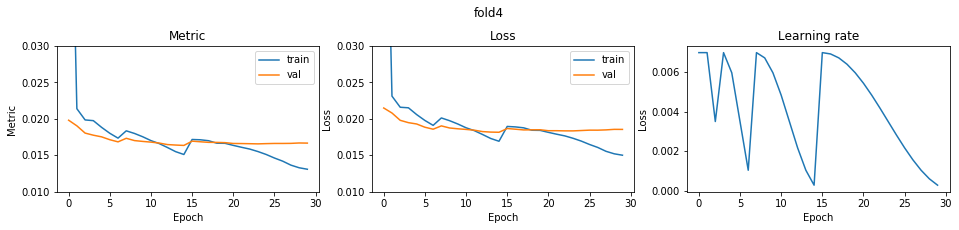

CV score: 0.01627775171941541

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5351057974515581
epoch2 save best model... 0.05886515974828757
epoch3 save best model... 0.035246947507855564
epoch4 save best model... 0.02487712686707463
epoch5 save best model... 0.022668036968703967
epoch6 save best model... 0.022054625203268674
epoch7 save best model... 0.02181648633831047
epoch8 save best model... 0.021067400090820698
epoch9 save best model... 0.02067946805311091
epoch10 save best model... 0.020451693093416903
epoch11 save best model... 0.020273594866275516
epoch12 save best model... 0.020127565526575325
epoch13 save best model... 0.020059895753045832
epoch14 save best model... 0.020030718626866038
epoch15 save best model... 0.020009497603176666
epoch16 save best model... 0.01980656249054065
epoch17 save best model... 0.019611619568190162
epoch18 save best model... 0.01944154228904796
epoch19 save best model... 0.019314793861367165
epoch20 save best model... 0.019154727430950536
epoch21 save best model... 0.01905686196304671
epoch22 sa

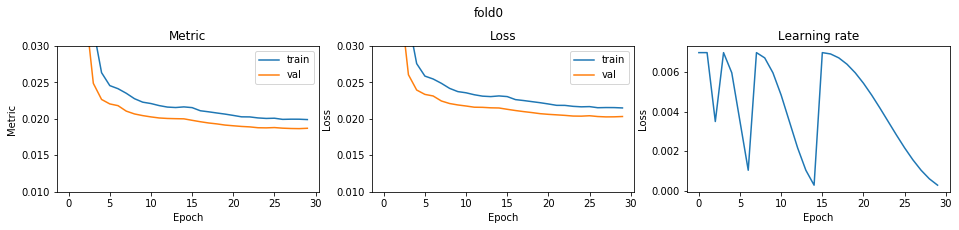

fold 1


epoch1 save best model... 0.5410839644616979
epoch2 save best model... 0.059133750511943195
epoch3 save best model... 0.03537403883641226
epoch4 save best model... 0.024861082814482762
epoch5 save best model... 0.022667373685256634
epoch6 save best model... 0.02211054309134835
epoch7 save best model... 0.021861675518568487
epoch8 save best model... 0.02116543541525105
epoch9 save best model... 0.020787106880374502
epoch10 save best model... 0.02054188295852543
epoch11 save best model... 0.020457631695525853
epoch12 save best model... 0.020189869104899207
epoch13 save best model... 0.020087619182032206
epoch16 save best model... 0.01993423170609772
epoch17 save best model... 0.019768707861618398
epoch18 save best model... 0.01963351860151839
epoch19 save best model... 0.01951830696733021
epoch20 save best model... 0.01931234156574114
epoch21 save best model... 0.019300881917950204
epoch22 save best model... 0.019153307075957065
epoch23 save best model... 0.01914227359407677
epoch24 save

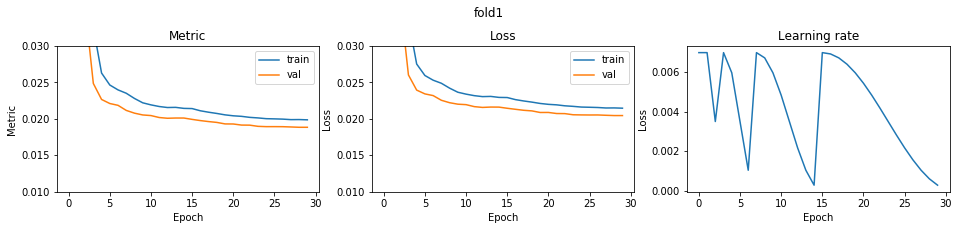

fold 2


epoch1 save best model... 0.5322257395647848
epoch2 save best model... 0.058343736383971445
epoch3 save best model... 0.034744908763692
epoch4 save best model... 0.02464825996658435
epoch5 save best model... 0.02246331059691995
epoch6 save best model... 0.021914841166696807
epoch7 save best model... 0.021723658597195685
epoch8 save best model... 0.021052125352906948
epoch9 save best model... 0.020705567415244326
epoch10 save best model... 0.020422281687631508
epoch11 save best model... 0.020293701529217677
epoch12 save best model... 0.020193372589342277
epoch13 save best model... 0.020106909729966434
epoch14 save best model... 0.020072845265517125
epoch15 save best model... 0.020021295388424197
epoch16 save best model... 0.019849448922939224
epoch17 save best model... 0.019623441507924822
epoch18 save best model... 0.019502300900651373
epoch19 save best model... 0.019356606966132835
epoch20 save best model... 0.019218690809236758
epoch21 save best model... 0.01903369564793904
epoch22 s

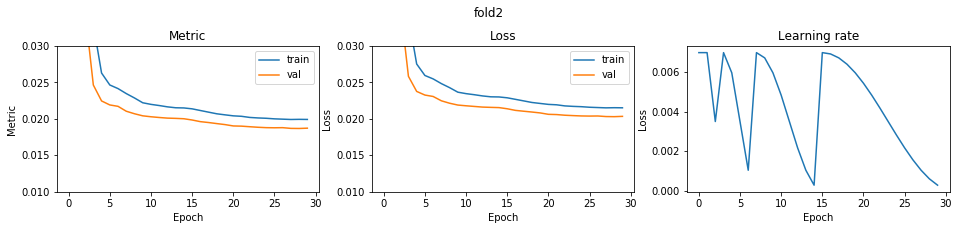

fold 3


epoch1 save best model... 0.5448750358236135
epoch2 save best model... 0.06045227134960931
epoch3 save best model... 0.036177096259621115
epoch4 save best model... 0.02506758650522976
epoch5 save best model... 0.023010410084166398
epoch6 save best model... 0.022278895154425656
epoch7 save best model... 0.022120746904835613
epoch8 save best model... 0.02132112810935545
epoch9 save best model... 0.020997476180196487
epoch10 save best model... 0.020700279593993835
epoch11 save best model... 0.020557217280845027
epoch12 save best model... 0.020373238976578098
epoch13 save best model... 0.020325045141652395
epoch14 save best model... 0.02027950126991728
epoch15 save best model... 0.020266701750762776
epoch16 save best model... 0.020072866918981618
epoch17 save best model... 0.019913343560366396
epoch18 save best model... 0.01974450921414925
epoch19 save best model... 0.01957907178110373
epoch20 save best model... 0.019533916540308123
epoch21 save best model... 0.01935924241713891
epoch22 sa

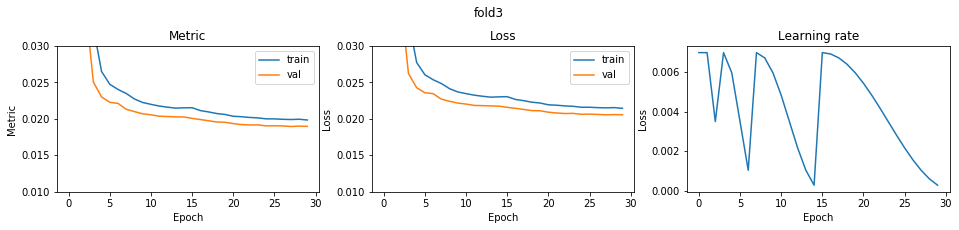

fold 4


epoch1 save best model... 0.5319957133849281
epoch2 save best model... 0.05750637646586314
epoch3 save best model... 0.03442718240099371
epoch4 save best model... 0.024322744451276534
epoch5 save best model... 0.02218615954364215
epoch6 save best model... 0.021519331307339233
epoch8 save best model... 0.02083095576707486
epoch9 save best model... 0.020422918992732273
epoch10 save best model... 0.020145489717568514
epoch11 save best model... 0.019899252130902437
epoch12 save best model... 0.019873005471665386
epoch13 save best model... 0.01973154669572389
epoch14 save best model... 0.019729463048364145
epoch15 save best model... 0.019726694175858976
epoch16 save best model... 0.019509344718552667
epoch17 save best model... 0.01937181719818528
epoch18 save best model... 0.01921102047000496
epoch19 save best model... 0.019081278244597766
epoch20 save best model... 0.0189731642323841
epoch21 save best model... 0.018845434372306957
epoch22 save best model... 0.018801607502993527
epoch23 sav

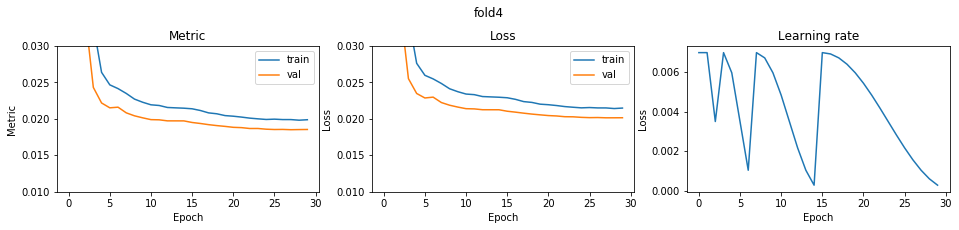

CV score: 0.018735586882880875

optimizer: SWATS
fold 0


epoch1 save best model... 0.02047952175191296
epoch2 save best model... 0.018912082510853953
epoch3 save best model... 0.01831997751867174
epoch4 save best model... 0.017981145760057184
epoch5 save best model... 0.017579722607291914
epoch6 save best model... 0.017280630147029435
epoch7 save best model... 0.017184292963771722
epoch8 save best model... 0.017066710492371157
epoch9 save best model... 0.01698766376118861
epoch10 save best model... 0.01685048200207039
epoch11 save best model... 0.0166858343742703
epoch12 save best model... 0.016520834382377343
epoch13 save best model... 0.016491922902490665
epoch14 save best model... 0.016448684297247464
epoch15 save best model... 0.016410828697026317
epoch18 save best model... 0.016346337174432426
epoch19 save best model... 0.016336245135168688
epoch20 save best model... 0.01624592061033621
epoch21 save best model... 0.016222420692919057
epoch22 save best model... 0.01617695297961015
epoch23 save best model... 0.01613447875811258
epoch24 sa

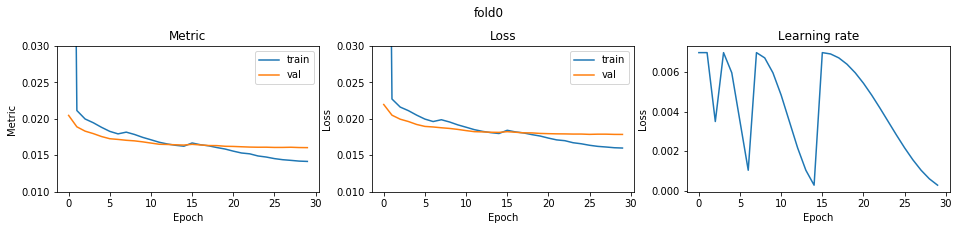

fold 1


epoch1 save best model... 0.020409318255835633
epoch2 save best model... 0.0191425207211267
epoch3 save best model... 0.018528444890682342
epoch4 save best model... 0.01803100827591624
epoch5 save best model... 0.017707548232179997
epoch6 save best model... 0.017532598369857343
epoch7 save best model... 0.017399379063892485
epoch9 save best model... 0.017325567170268015
epoch10 save best model... 0.017143483685979295
epoch12 save best model... 0.0169239353119485
epoch13 save best model... 0.016819462421190822
epoch18 save best model... 0.016764663242178807
epoch19 save best model... 0.016692903003169238
epoch20 save best model... 0.01666577983313166
epoch21 save best model... 0.016613812646498628
epoch22 save best model... 0.016570539611369867
epoch24 save best model... 0.016527704770620984
epoch25 save best model... 0.01652314806750435
epoch26 save best model... 0.016489097265847914
epoch29 save best model... 0.016476301485695934
fold1 score: 0.016476301457358122


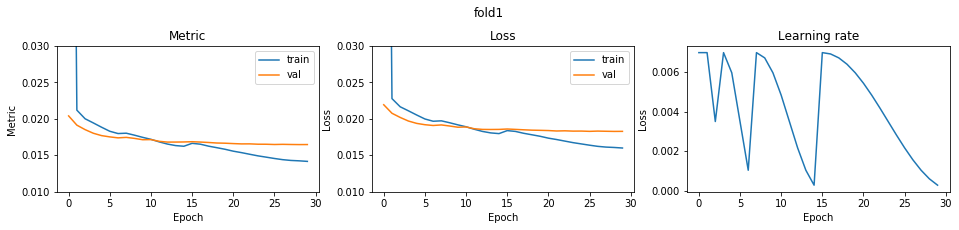

fold 2


epoch1 save best model... 0.020461430050828212
epoch2 save best model... 0.01888586786200243
epoch3 save best model... 0.018333946590435534
epoch4 save best model... 0.017900692485315322
epoch5 save best model... 0.017443287992452292
epoch6 save best model... 0.017332954117703626
epoch7 save best model... 0.01719683017153068
epoch8 save best model... 0.01716954662154967
epoch9 save best model... 0.017015535583455216
epoch10 save best model... 0.016855744284905085
epoch11 save best model... 0.016702264627769817
epoch12 save best model... 0.01666279530755736
epoch13 save best model... 0.016530909607987736
epoch14 save best model... 0.016480609494068134
epoch15 save best model... 0.016464142743977648
epoch19 save best model... 0.016432019071108146
epoch20 save best model... 0.016409774938771
epoch21 save best model... 0.01635943938982048
epoch22 save best model... 0.01634955078581555
epoch23 save best model... 0.01629324603378501
epoch24 save best model... 0.016274061621187774
epoch25 sav

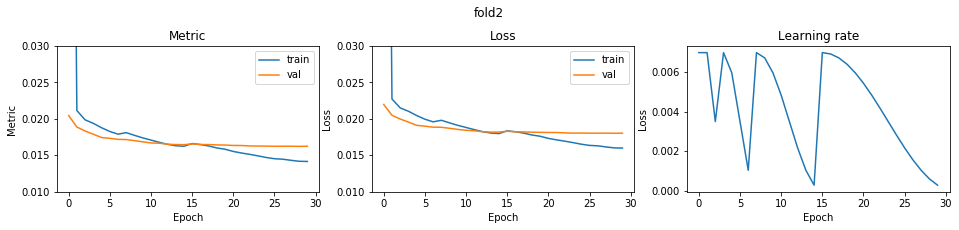

fold 3


epoch1 save best model... 0.020445616362968582
epoch2 save best model... 0.01919378944606879
epoch3 save best model... 0.01867638358587488
epoch4 save best model... 0.01816720570774923
epoch5 save best model... 0.017872591910709824
epoch6 save best model... 0.017619068234955258
epoch7 save best model... 0.017593600964576753
epoch8 save best model... 0.017455085363145707
epoch9 save best model... 0.01729375668557399
epoch10 save best model... 0.017067798393394517
epoch11 save best model... 0.01696859739576562
epoch12 save best model... 0.016906824624823548
epoch13 save best model... 0.016776886686326296
epoch15 save best model... 0.01672818569810149
epoch17 save best model... 0.016722839620549886
epoch18 save best model... 0.016664112279094027
epoch19 save best model... 0.016579267186174224
epoch20 save best model... 0.016553629882599744
epoch21 save best model... 0.01650390221200595
epoch22 save best model... 0.016449055551277614
epoch24 save best model... 0.01641730795782017
epoch26 s

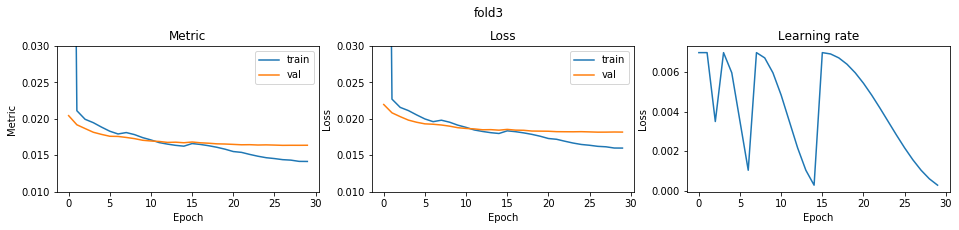

fold 4


epoch1 save best model... 0.02015846303339564
epoch2 save best model... 0.01886587939341818
epoch3 save best model... 0.018345436512371673
epoch4 save best model... 0.017892098414090066
epoch5 save best model... 0.017604840148859796
epoch6 save best model... 0.01742023839604678
epoch7 save best model... 0.017292991302194655
epoch9 save best model... 0.01716174683098709
epoch10 save best model... 0.017074585818008844
epoch11 save best model... 0.016918317006650575
epoch12 save best model... 0.016806353235316034
epoch13 save best model... 0.01674387415994069
epoch14 save best model... 0.016718923231344968
epoch15 save best model... 0.01667538668603927
epoch18 save best model... 0.01661403343285135
epoch20 save best model... 0.01651668168290397
epoch21 save best model... 0.016505035623517694
epoch22 save best model... 0.01642616921590306
epoch25 save best model... 0.016405956856142687
epoch26 save best model... 0.01640363413212579
epoch30 save best model... 0.016372273239075866
fold4 scor

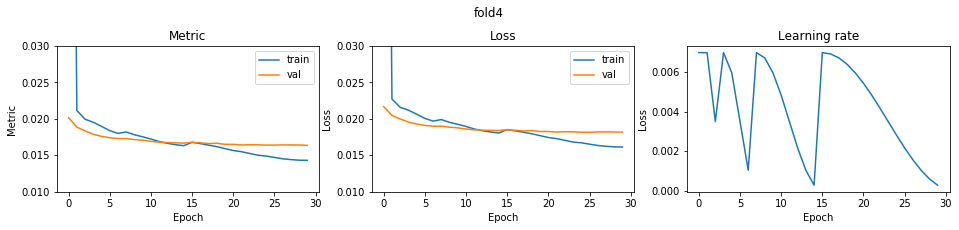

CV score: 0.016301794844580195

optimizer: Yogi
fold 0


epoch1 save best model... 0.02071255784659967
epoch2 save best model... 0.01932397713473147
epoch3 save best model... 0.018776404694707084
epoch4 save best model... 0.018237572989017112
epoch5 save best model... 0.017913822992651773
epoch6 save best model... 0.017696837082097905
epoch7 save best model... 0.017617943661461386
epoch8 save best model... 0.017505199127832688
epoch9 save best model... 0.017275594028056618
epoch10 save best model... 0.017187594451807897
epoch11 save best model... 0.017013910169244355
epoch12 save best model... 0.016939167595194794
epoch13 save best model... 0.016863189153967253
epoch14 save best model... 0.01682797274668966
epoch15 save best model... 0.016795765867367692
epoch16 save best model... 0.01674862199108666
epoch17 save best model... 0.016740721263042345
epoch18 save best model... 0.016583716343231244
epoch19 save best model... 0.016548033017062654
epoch20 save best model... 0.016406003984883597
epoch22 save best model... 0.01634525129983121
epoch2

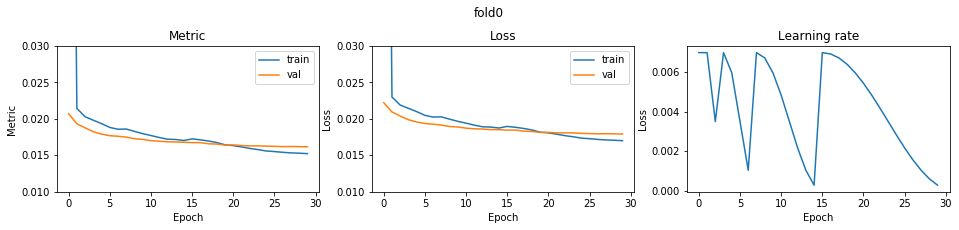

fold 1


epoch1 save best model... 0.020715069880899602
epoch2 save best model... 0.019334098823685992
epoch3 save best model... 0.01878461059828803
epoch4 save best model... 0.018256488258914974
epoch5 save best model... 0.01794799837699904
epoch6 save best model... 0.01771485334693856
epoch7 save best model... 0.017712170121086623
epoch8 save best model... 0.01758646711326862
epoch9 save best model... 0.01742137670746138
epoch10 save best model... 0.017387658431888386
epoch11 save best model... 0.017165147214975165
epoch12 save best model... 0.01712068842159952
epoch13 save best model... 0.01705138148783646
epoch14 save best model... 0.017022259751541462
epoch15 save best model... 0.01697181406865687
epoch17 save best model... 0.016953516637791422
epoch18 save best model... 0.016860806183305124
epoch19 save best model... 0.016845711660107753
epoch20 save best model... 0.01679857040372015
epoch21 save best model... 0.016745012813292513
epoch22 save best model... 0.016682173802983546
epoch23 sa

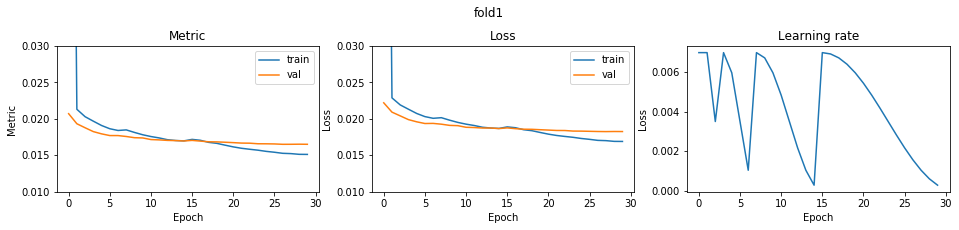

fold 2


epoch1 save best model... 0.020712124929426198
epoch2 save best model... 0.01925886126999453
epoch3 save best model... 0.01874973188502611
epoch4 save best model... 0.018199315765059045
epoch5 save best model... 0.01788897125577093
epoch6 save best model... 0.01765271235621513
epoch7 save best model... 0.01758424880984202
epoch8 save best model... 0.017483491789635316
epoch9 save best model... 0.017209176170198542
epoch10 save best model... 0.01711885134018338
epoch11 save best model... 0.017028546533709672
epoch12 save best model... 0.01691746945357331
epoch13 save best model... 0.016832790854409266
epoch14 save best model... 0.0167991631501158
epoch15 save best model... 0.016794786587362612
epoch16 save best model... 0.016786186889027863
epoch18 save best model... 0.016616969667273235
epoch19 save best model... 0.016531567163315577
epoch20 save best model... 0.016501220967854027
epoch21 save best model... 0.016447419883998646
epoch22 save best model... 0.01644020021389546
epoch23 sav

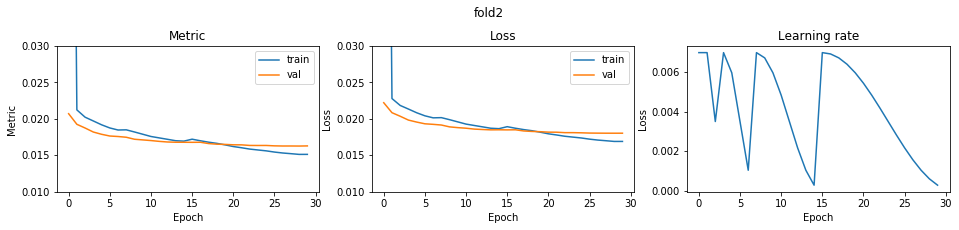

fold 3


epoch1 save best model... 0.020643666219432966
epoch2 save best model... 0.01950015898556332
epoch3 save best model... 0.018922387267588076
epoch4 save best model... 0.018363796425283227
epoch5 save best model... 0.018104191138016607
epoch6 save best model... 0.017851100408881562
epoch7 save best model... 0.017717149621618227
epoch8 save best model... 0.017654172008207965
epoch9 save best model... 0.017480292051165008
epoch10 save best model... 0.017281845348180697
epoch11 save best model... 0.017232569805632827
epoch12 save best model... 0.01708719734492837
epoch13 save best model... 0.017086274425895855
epoch14 save best model... 0.016993535272267928
epoch18 save best model... 0.01692960465704526
epoch19 save best model... 0.016850517639690896
epoch21 save best model... 0.016700767347236974
epoch22 save best model... 0.016632141829691062
epoch23 save best model... 0.016604792163760353
epoch24 save best model... 0.01657261203185301
epoch25 save best model... 0.016514660339963735
epoch

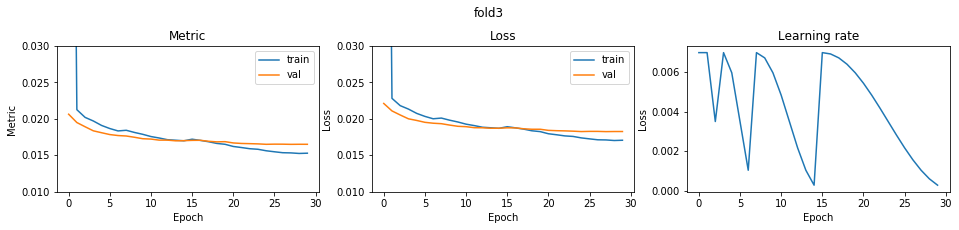

fold 4


epoch1 save best model... 0.020321210113975616
epoch2 save best model... 0.019042274489964876
epoch3 save best model... 0.01855767503940842
epoch4 save best model... 0.018136333183710017
epoch5 save best model... 0.01776692123875735
epoch6 save best model... 0.0176135019354675
epoch7 save best model... 0.017553987140620897
epoch8 save best model... 0.01753846836617908
epoch9 save best model... 0.017323078914356665
epoch10 save best model... 0.017187515394613655
epoch11 save best model... 0.01705378709967696
epoch12 save best model... 0.01696879967987741
epoch13 save best model... 0.016956842910065602
epoch14 save best model... 0.016881503300117603
epoch17 save best model... 0.016820846524742986
epoch18 save best model... 0.01677699182267409
epoch19 save best model... 0.016728558295018174
epoch20 save best model... 0.01668955339140053
epoch21 save best model... 0.016596245850544585
epoch23 save best model... 0.01652766416965218
epoch24 save best model... 0.016489658407561465
epoch25 sav

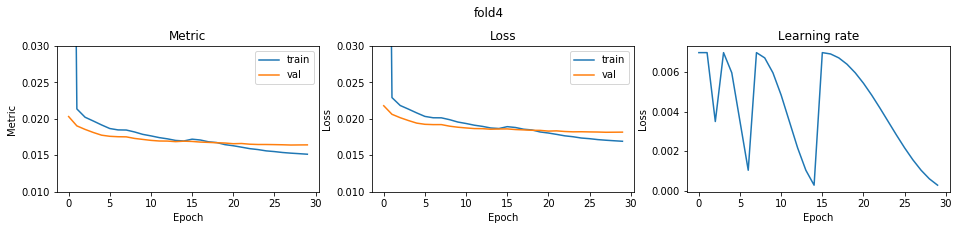

CV score: 0.016378110138445742

optimizer: Adam
fold 0


epoch1 save best model... 0.020014831468734492
epoch2 save best model... 0.018401151778418275
epoch3 save best model... 0.01771504772245748
epoch4 save best model... 0.0176628200791284
epoch5 save best model... 0.017454640617369246
epoch6 save best model... 0.017038492701421565
epoch7 save best model... 0.01669042781462091
epoch13 save best model... 0.01650650079249657
epoch14 save best model... 0.01632519441069123
epoch15 save best model... 0.016179689008462537
epoch29 save best model... 0.016138323564888542
epoch30 save best model... 0.016080474805994838
fold0 score: 0.01608047471289886


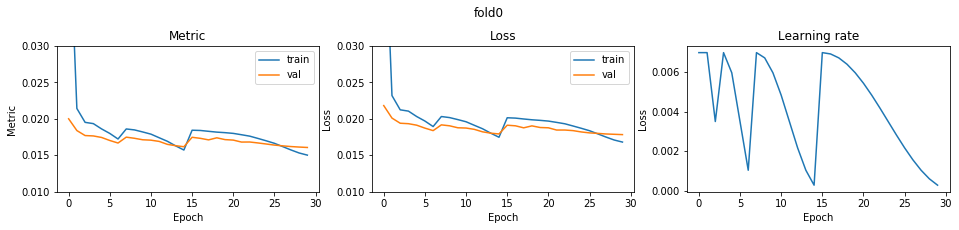

fold 1


epoch1 save best model... 0.019961307303142672
epoch2 save best model... 0.018681480476068702
epoch3 save best model... 0.0178039726273064
epoch5 save best model... 0.017710575130491207
epoch6 save best model... 0.01724279347992203
epoch7 save best model... 0.01686467671727409
epoch13 save best model... 0.01681285795107854
epoch14 save best model... 0.016616284604508775
epoch15 save best model... 0.016532206523795962
epoch27 save best model... 0.01651369402913759
epoch28 save best model... 0.01646420018253884
epoch29 save best model... 0.01638266066987705
fold1 score: 0.01638266055549177


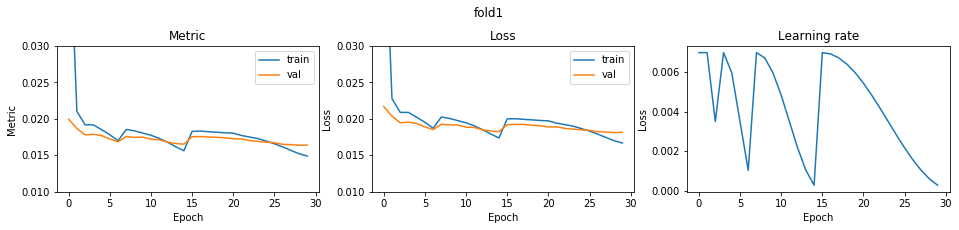

fold 2


epoch1 save best model... 0.02054571612691602
epoch2 save best model... 0.018626920732472827
epoch3 save best model... 0.01779496660751012
epoch5 save best model... 0.017590633734396947
epoch6 save best model... 0.017152242532679392
epoch7 save best model... 0.016766887883861343
epoch13 save best model... 0.016650306340795045
epoch14 save best model... 0.016364184886176376
epoch15 save best model... 0.01630100653239238
epoch28 save best model... 0.01626562744873033
epoch29 save best model... 0.016205673196409674
epoch30 save best model... 0.016171211670251512
fold2 score: 0.016171211719858698


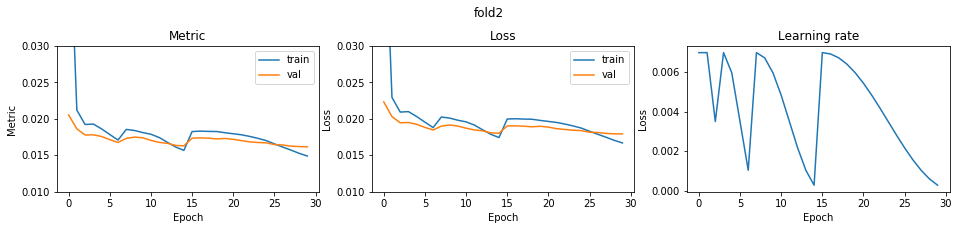

fold 3


epoch1 save best model... 0.02027473168316083
epoch2 save best model... 0.019017935262522014
epoch3 save best model... 0.018064591186312037
epoch5 save best model... 0.017780239541075087
epoch6 save best model... 0.01730763783173504
epoch7 save best model... 0.01700690071096385
epoch12 save best model... 0.016978899291493762
epoch13 save best model... 0.016765952697087392
epoch14 save best model... 0.016615033838346362
epoch15 save best model... 0.01648554113441081
epoch29 save best model... 0.016424713868876933
epoch30 save best model... 0.016424125198758546
fold3 score: 0.016424125252319167


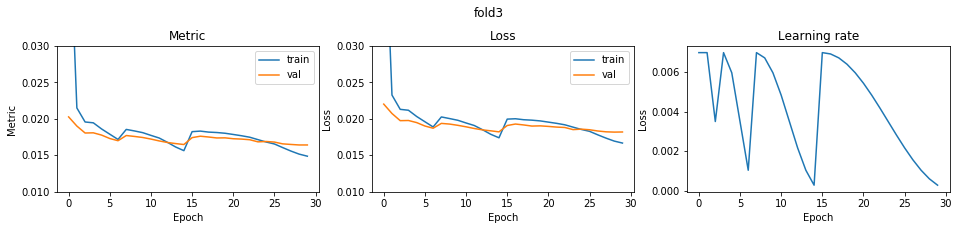

fold 4


epoch1 save best model... 0.01956353678976892
epoch2 save best model... 0.018453300775692783
epoch3 save best model... 0.017637565376020646
epoch5 save best model... 0.017469934146673097
epoch6 save best model... 0.017179603917112655
epoch7 save best model... 0.016856267582837297
epoch13 save best model... 0.01665872263686057
epoch14 save best model... 0.016485830902170755
epoch15 save best model... 0.016467533963212662
epoch28 save best model... 0.01642805533632127
epoch29 save best model... 0.01637667145130303
epoch30 save best model... 0.016359551019695055
fold4 score: 0.01635955091649413


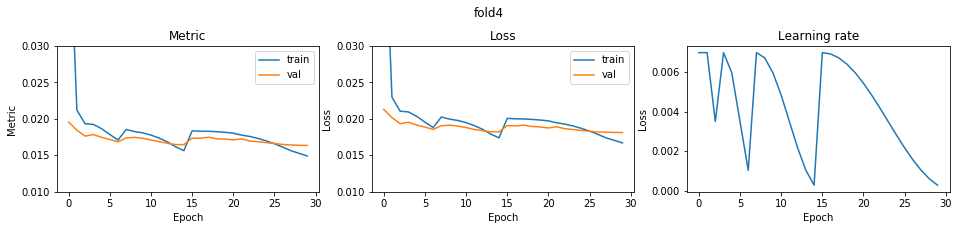

CV score: 0.016283605239075523

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.0200355836998561
epoch2 save best model... 0.01872089030666612
epoch3 save best model... 0.0179862808045806
epoch4 save best model... 0.017778441283622742
epoch5 save best model... 0.017312073348628904
epoch6 save best model... 0.01700860175446253
epoch7 save best model... 0.016701084457694262
epoch11 save best model... 0.01659313567865275
epoch12 save best model... 0.016429578142075168
epoch13 save best model... 0.016332703859360722
epoch14 save best model... 0.016190504630632988
epoch15 save best model... 0.016143636848853907
fold0 score: 0.016143636927650862


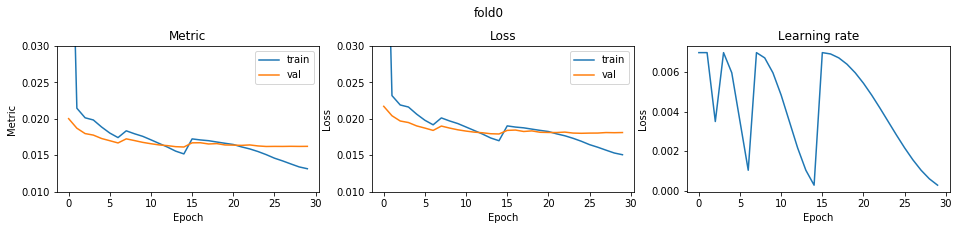

fold 1


epoch1 save best model... 0.020445671008921452
epoch2 save best model... 0.019158065862704122
epoch3 save best model... 0.01819255647174615
epoch4 save best model... 0.018040666002317615
epoch5 save best model... 0.017571401359217604
epoch6 save best model... 0.017256052077952225
epoch7 save best model... 0.016950426175282182
epoch11 save best model... 0.016877514056608464
epoch12 save best model... 0.016756317704511983
epoch13 save best model... 0.016511739646911106
epoch14 save best model... 0.016461883331645822
epoch15 save best model... 0.016397016419161015
fold1 score: 0.0163970162339987


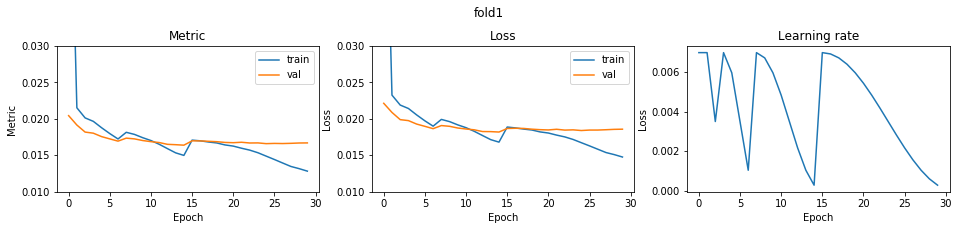

fold 2


epoch1 save best model... 0.020000269087776287
epoch2 save best model... 0.019276990980464998
epoch3 save best model... 0.018272845217978038
epoch4 save best model... 0.017947368739280187
epoch5 save best model... 0.017497081928528925
epoch6 save best model... 0.01710264996121945
epoch7 save best model... 0.01688706395987614
epoch11 save best model... 0.01678059713846664
epoch12 save best model... 0.016560878997210707
epoch13 save best model... 0.016355996003162687
epoch14 save best model... 0.016199642549593347
epoch15 save best model... 0.016153482665085227
fold2 score: 0.016153482594808803


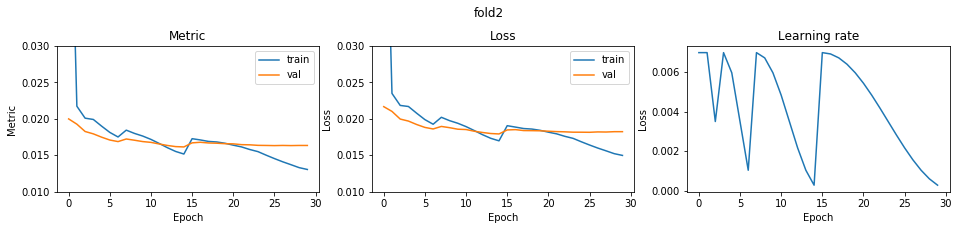

fold 3


epoch1 save best model... 0.020470394491555344
epoch2 save best model... 0.019088792044389357
epoch3 save best model... 0.018278022813090974
epoch4 save best model... 0.017995951208020805
epoch5 save best model... 0.017643788658455863
epoch6 save best model... 0.017257366487692726
epoch7 save best model... 0.017023163915512094
epoch11 save best model... 0.01700472092438396
epoch12 save best model... 0.01676909155880604
epoch13 save best model... 0.016604742566908547
epoch14 save best model... 0.016481040756309358
epoch15 save best model... 0.016429795100351537
fold3 score: 0.016429795009298993


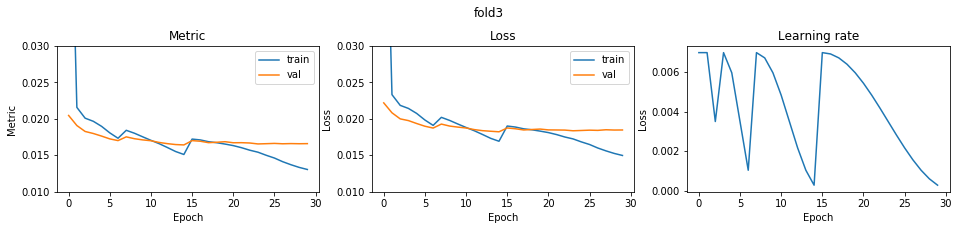

fold 4


epoch1 save best model... 0.020007941213379146
epoch2 save best model... 0.018895531432164287
epoch3 save best model... 0.017944968479912483
epoch4 save best model... 0.017809027048561868
epoch5 save best model... 0.01753005598308964
epoch6 save best model... 0.01713437223700904
epoch7 save best model... 0.016861540595481093
epoch11 save best model... 0.016782456901611797
epoch12 save best model... 0.016625271920445703
epoch13 save best model... 0.016463227311662634
epoch14 save best model... 0.016341826003596426
epoch15 save best model... 0.01629140398301744
fold4 score: 0.01629140386754881


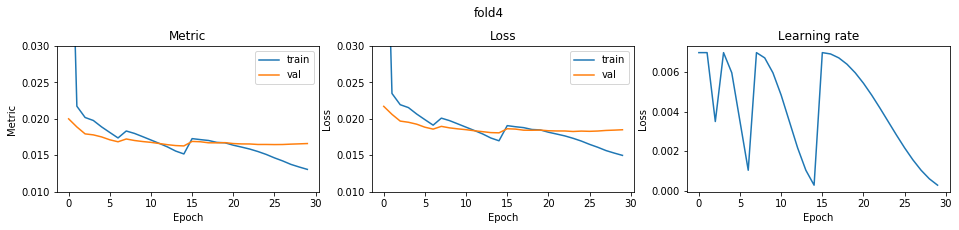

CV score: 0.016283067639027943

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.020734610712338147
epoch2 save best model... 0.019335730327187203
epoch3 save best model... 0.018661933773301186
epoch4 save best model... 0.01826499569354948
epoch5 save best model... 0.017684894722116293
epoch6 save best model... 0.01735240878083304
epoch7 save best model... 0.01718753286826176
epoch9 save best model... 0.017079346531106834
epoch10 save best model... 0.01684359121550053
epoch11 save best model... 0.016745121348521977
epoch12 save best model... 0.0164504792744926
epoch13 save best model... 0.016378059702371682
epoch14 save best model... 0.01627997301586804
epoch15 save best model... 0.01621586245172795
fold0 score: 0.016215862440196054


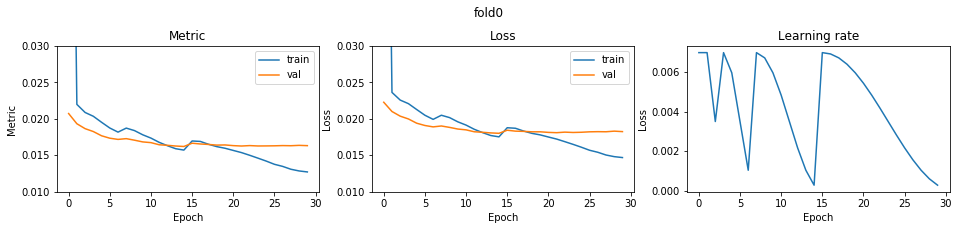

fold 1


epoch1 save best model... 0.020984581199097564
epoch2 save best model... 0.01957268212147619
epoch3 save best model... 0.019088335652273563
epoch4 save best model... 0.018511598986206634
epoch5 save best model... 0.017964053542562648
epoch6 save best model... 0.01756129210645502
epoch7 save best model... 0.017349146250495336
epoch10 save best model... 0.017089581840617915
epoch11 save best model... 0.016901059633201106
epoch12 save best model... 0.01662478694982112
epoch13 save best model... 0.01656195553289979
epoch14 save best model... 0.01644417267049987
epoch15 save best model... 0.01641746490258417
fold1 score: 0.01641746472644043


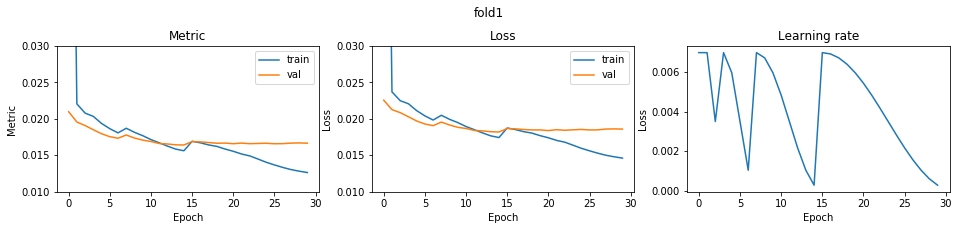

fold 2


epoch1 save best model... 0.02063120086926701
epoch2 save best model... 0.019702328804232762
epoch3 save best model... 0.018799444135999075
epoch4 save best model... 0.018311388104794154
epoch5 save best model... 0.017759167019928825
epoch6 save best model... 0.01740017082430991
epoch7 save best model... 0.01716103493924577
epoch9 save best model... 0.017043215268490782
epoch10 save best model... 0.016896395738230027
epoch11 save best model... 0.016774352629940408
epoch12 save best model... 0.01652103525985989
epoch13 save best model... 0.01642538656646759
epoch14 save best model... 0.016270917980562693
epoch15 save best model... 0.016254997750675047
fold2 score: 0.01625499771375678


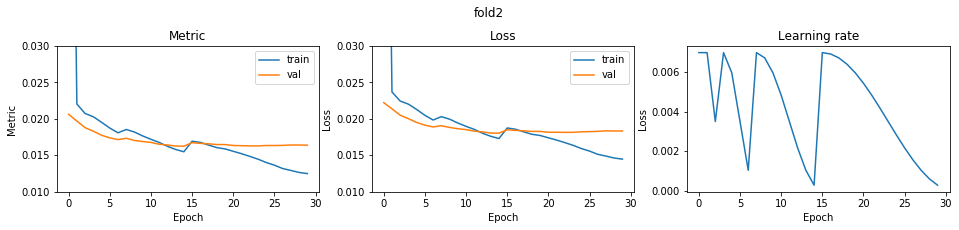

fold 3


epoch1 save best model... 0.020773528521808377
epoch2 save best model... 0.01959083022630364
epoch3 save best model... 0.019108812866948866
epoch4 save best model... 0.018385792936459353
epoch5 save best model... 0.017893328955969803
epoch6 save best model... 0.01754349905929628
epoch7 save best model... 0.017307581658769985
epoch10 save best model... 0.017128260742983268
epoch11 save best model... 0.01688790298353431
epoch12 save best model... 0.016701466215091304
epoch13 save best model... 0.016595962923656563
epoch14 save best model... 0.01649085999358284
epoch15 save best model... 0.016467946182707312
epoch26 save best model... 0.016458534726402074
fold3 score: 0.016458534644266876


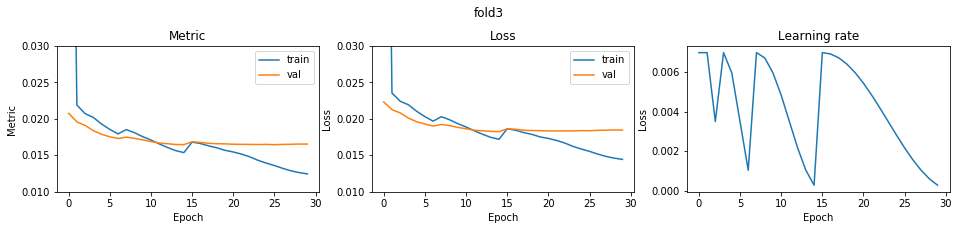

fold 4


epoch1 save best model... 0.020386206556391607
epoch2 save best model... 0.019345317661320974
epoch3 save best model... 0.01868339136225895
epoch4 save best model... 0.018253418484571175
epoch5 save best model... 0.017705270336996044
epoch6 save best model... 0.017347711996347187
epoch7 save best model... 0.017193312330302996
epoch10 save best model... 0.016880459633310047
epoch11 save best model... 0.016787601108312743
epoch12 save best model... 0.01667772593286423
epoch13 save best model... 0.016599523205233734
epoch14 save best model... 0.01641055047130191
fold4 score: 0.016410550480168068


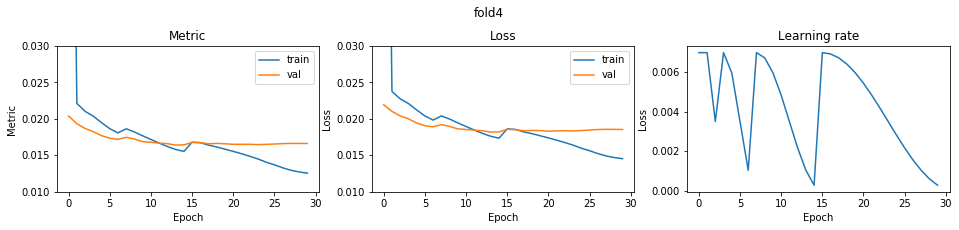

CV score: 0.01635148339068506

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.02217877148088399
epoch2 save best model... 0.020338701279430833
epoch3 save best model... 0.019773500421188417
epoch4 save best model... 0.01915207391430821
epoch5 save best model... 0.018662137210640656
epoch6 save best model... 0.018398450321787312
epoch7 save best model... 0.01830002684952322
epoch8 save best model... 0.018155776514143497
epoch9 save best model... 0.01787004272765342
epoch10 save best model... 0.01768731644932936
epoch11 save best model... 0.01754497180868933
epoch12 save best model... 0.01746334227943339
epoch13 save best model... 0.017430836170198978
epoch14 save best model... 0.01734938479892078
epoch16 save best model... 0.01731722425066936
epoch17 save best model... 0.017232879766333076
epoch18 save best model... 0.01714392634435368
epoch19 save best model... 0.017022654419268455
epoch20 save best model... 0.016987679600885354
epoch21 save best model... 0.016901067054590765
epoch22 save best model... 0.016800409066649938
epoch23 sav

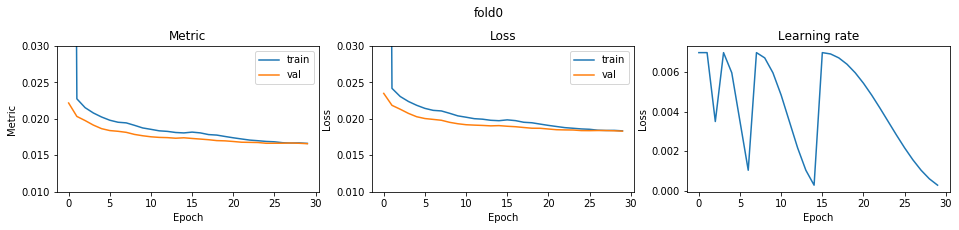

fold 1


epoch1 save best model... 0.02200192364905005
epoch2 save best model... 0.020206705742407616
epoch3 save best model... 0.01972728773338712
epoch4 save best model... 0.019085586221672647
epoch5 save best model... 0.018681962447490066
epoch6 save best model... 0.018419770610905585
epoch7 save best model... 0.01832380751519207
epoch8 save best model... 0.018143573679551092
epoch9 save best model... 0.0180036234241815
epoch10 save best model... 0.01783342700426998
epoch11 save best model... 0.01767680361632688
epoch12 save best model... 0.017615561941152665
epoch13 save best model... 0.017599747750265612
epoch14 save best model... 0.017545986130806466
epoch15 save best model... 0.017502906392113063
epoch16 save best model... 0.017449532540658935
epoch18 save best model... 0.017275947487114585
epoch19 save best model... 0.017223562839010033
epoch20 save best model... 0.01720895290996062
epoch21 save best model... 0.017156508510796947
epoch22 save best model... 0.01703355160976195
epoch24 sa

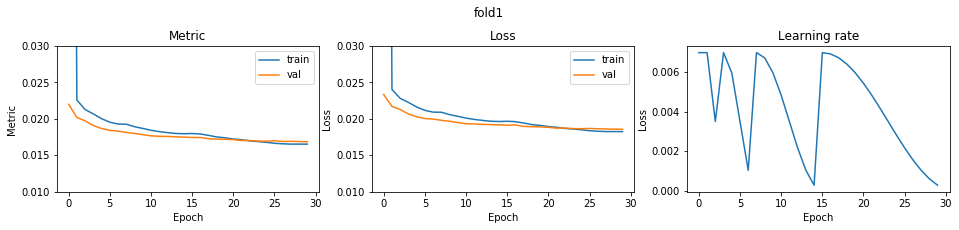

fold 2


epoch1 save best model... 0.021980512306674735
epoch2 save best model... 0.020220688336475154
epoch3 save best model... 0.019816158799419347
epoch4 save best model... 0.019060489682552414
epoch5 save best model... 0.01861784493308332
epoch6 save best model... 0.01840054686228991
epoch7 save best model... 0.01832988808675497
epoch8 save best model... 0.018133018852276677
epoch9 save best model... 0.01794708844365102
epoch10 save best model... 0.017729857002844785
epoch11 save best model... 0.017559310452752434
epoch12 save best model... 0.017486080352457162
epoch13 save best model... 0.017433477768079922
epoch14 save best model... 0.017394841841947627
epoch15 save best model... 0.017374256153638298
epoch16 save best model... 0.017348081421376116
epoch17 save best model... 0.017249223459991556
epoch18 save best model... 0.01714190777699302
epoch19 save best model... 0.017058725448443682
epoch20 save best model... 0.017011620941633214
epoch21 save best model... 0.016977187370642507
epoch2

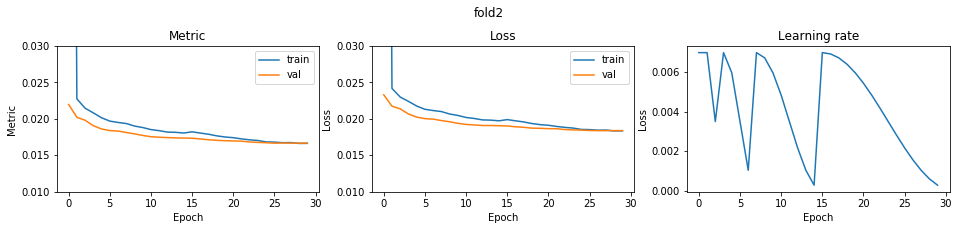

fold 3


epoch1 save best model... 0.02203834177268529
epoch2 save best model... 0.020240196227127843
epoch3 save best model... 0.019786159018720745
epoch4 save best model... 0.0191879419979039
epoch5 save best model... 0.018727917844060478
epoch6 save best model... 0.018499624559015104
epoch7 save best model... 0.018494731299409425
epoch8 save best model... 0.01821090266753438
epoch9 save best model... 0.01795046152653075
epoch10 save best model... 0.01786306901985529
epoch11 save best model... 0.017783653168835102
epoch12 save best model... 0.017652064377276528
epoch13 save best model... 0.017622559098845057
epoch14 save best model... 0.01759526831286711
epoch15 save best model... 0.017591216128769252
epoch16 save best model... 0.017506940348459947
epoch17 save best model... 0.017402957094268947
epoch18 save best model... 0.017378908878188062
epoch19 save best model... 0.01726733131083853
epoch20 save best model... 0.017241633138651184
epoch21 save best model... 0.017163348410083386
epoch22 s

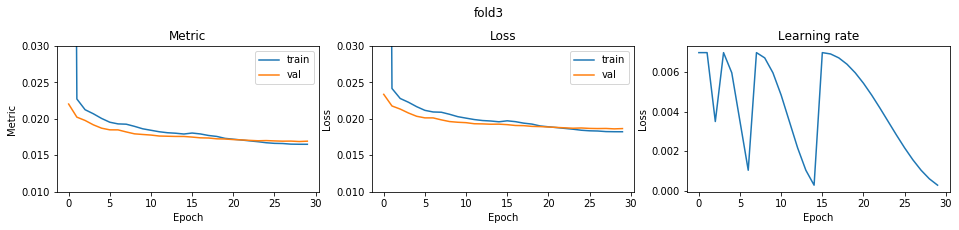

fold 4


epoch1 save best model... 0.022004489057563702
epoch2 save best model... 0.020007043411628532
epoch3 save best model... 0.019545942247932213
epoch4 save best model... 0.01884015650066265
epoch5 save best model... 0.01847894838958096
epoch6 save best model... 0.01824243633683287
epoch7 save best model... 0.018197138550646755
epoch8 save best model... 0.018062022819707767
epoch9 save best model... 0.017838998144420377
epoch10 save best model... 0.017667412767207975
epoch11 save best model... 0.01755346186535437
epoch12 save best model... 0.01745954924358526
epoch13 save best model... 0.017436835456189778
epoch14 save best model... 0.01742284592529568
epoch15 save best model... 0.017383036599971848
epoch16 save best model... 0.017329393841903275
epoch17 save best model... 0.017242198159116276
epoch18 save best model... 0.017225387684389915
epoch19 save best model... 0.017079340066158282
epoch20 save best model... 0.01707638320396389
epoch21 save best model... 0.01698450785393324
epoch22 s

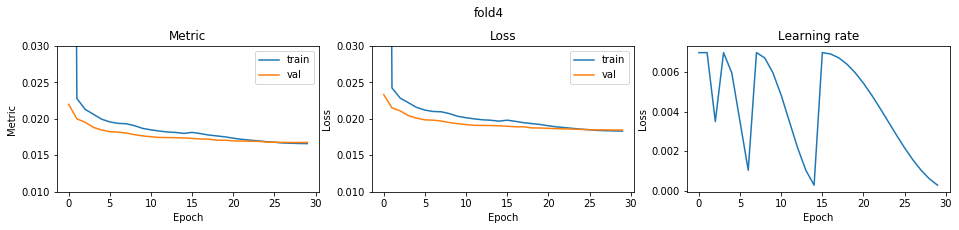

CV score: 0.01676093734226156


In [24]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
score_dict

{'AggMo': 0.018772749674498594,
 'Apollo': 0.46151709088008547,
 'PID': 0.4603730237187537,
 'QHM': 0.4661710125068649,
 'SGDP': 0.46113182102361994,
 'SGDW': 0.47079680819910535,
 'SGD': 0.4600020986042204,
 'AdaBelief': 0.01629292670330319,
 'AdaBound': 0.020365119479579148,
 'AdaMod': 0.016267329843387916,
 'AdamW': 0.016322633357578806,
 'AdamP': 0.01628982192205003,
 'DiffGrad': 0.016316505049212015,
 'Lamb': 0.01638363239984953,
 'NovoGrad': 0.016249114072042038,
 'PlainRAdam': 0.016355851635697787,
 'QHAdam': 0.01630334068519414,
 'RAdam': 0.016345630873483907,
 'Ranger': 0.016330848974756812,
 'RangerQH': 0.016277751719415385,
 'RangerVA': 0.018735586882880833,
 'SWATS': 0.016301794844580136,
 'Yogi': 0.01637811013844579,
 'Adam': 0.016283605239075405,
 'LookaheadAdam': 0.016283067639027992,
 'LookaheadDiffGrad': 0.016351483390685092,
 'LookaheadYogi': 0.01676093734226164}

In [27]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
AggMo              0.018773
Apollo             0.461517
PID                0.460373
QHM                0.466171
SGDP               0.461132
SGDW               0.470797
SGD                0.460002
AdaBelief          0.016293
AdaBound           0.020365
AdaMod             0.016267
AdamW              0.016323
AdamP              0.016290
DiffGrad           0.016317
Lamb               0.016384
NovoGrad           0.016249
PlainRAdam         0.016356
QHAdam             0.016303
RAdam              0.016346
Ranger             0.016331
RangerQH           0.016278
RangerVA           0.018736
SWATS              0.016302
Yogi               0.016378
Adam               0.016284
LookaheadAdam      0.016283
LookaheadDiffGrad  0.016351
LookaheadYogi      0.016761

In [28]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
AggMo              0.018773
Apollo             0.461517
PID                0.460373
QHM                0.466171
SGDP               0.461132
SGDW               0.470797
SGD                0.460002
AdaBelief          0.016293
AdaBound           0.020365
AdaMod             0.016267
AdamW              0.016323
AdamP              0.016290
DiffGrad           0.016317
Lamb               0.016384
NovoGrad           0.016249
PlainRAdam         0.016356
QHAdam             0.016303
RAdam              0.016346
Ranger             0.016331
RangerQH           0.016278
RangerVA           0.018736
SWATS              0.016302
Yogi               0.016378
Adam               0.016284
LookaheadAdam      0.016283
LookaheadDiffGrad  0.016351
LookaheadYogi      0.016761


In [29]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [30]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
RAdam              0.016346
LookaheadDiffGrad  0.016351
PlainRAdam         0.016356
Yogi               0.016378
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797

In [31]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
RAdam              0.016346
LookaheadDiffGrad  0.016351
PlainRAdam         0.016356
Yogi               0.016378
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797



optimizer: RangerLars
fold 0


epoch1 save best model... 0.021785440532690027
epoch2 save best model... 0.019591767477520776
epoch3 save best model... 0.01892230177132714
epoch4 save best model... 0.01879776779621636
epoch5 save best model... 0.017669695803305827
epoch6 save best model... 0.017350615667930225
epoch7 save best model... 0.017156345432874552
epoch9 save best model... 0.01703431568615529
epoch10 save best model... 0.016798021908263953
epoch11 save best model... 0.01656242695325192
epoch12 save best model... 0.016420606227595877
epoch13 save best model... 0.0163004474854415
epoch14 save best model... 0.016211117606330025
epoch15 save best model... 0.01620696203566765
epoch21 save best model... 0.016205322488735095
fold0 score: 0.01620532230400307


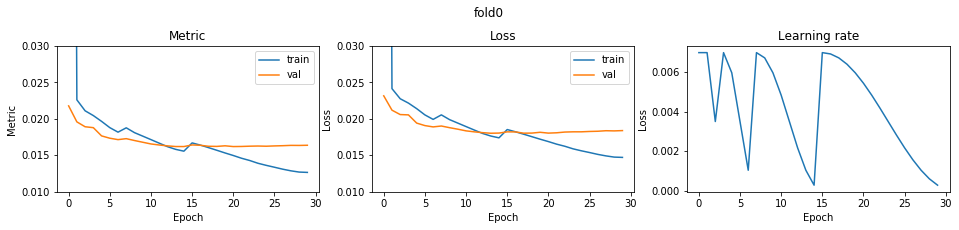

fold 1


epoch1 save best model... 0.021806224043262278
epoch2 save best model... 0.019682918669938987
epoch3 save best model... 0.018957012765640876
epoch4 save best model... 0.018477849849884046
epoch5 save best model... 0.017935943108422933
epoch6 save best model... 0.017533793286640027
epoch7 save best model... 0.017292639684958238
epoch9 save best model... 0.01721482436257754
epoch10 save best model... 0.016972458172537765
epoch11 save best model... 0.01692520339389099
epoch12 save best model... 0.016716449672776818
epoch13 save best model... 0.016649740162237844
epoch14 save best model... 0.016502557433572953
epoch20 save best model... 0.016489308295819436
fold1 score: 0.01648930814496035


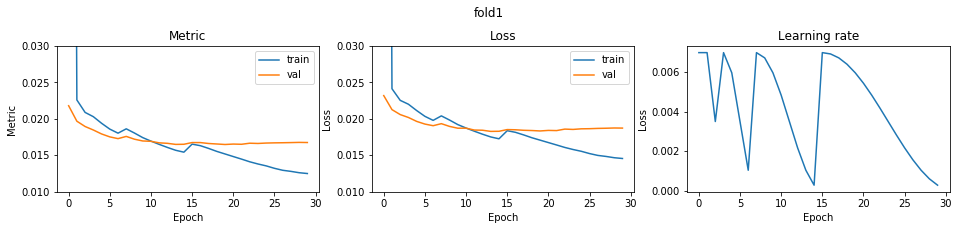

fold 2


epoch1 save best model... 0.021915726408219795
epoch2 save best model... 0.01976026743429754
epoch3 save best model... 0.019040176062022438
epoch4 save best model... 0.018288223712865707
epoch5 save best model... 0.017777351658484895
epoch6 save best model... 0.017491933009715604
epoch7 save best model... 0.01715999370702689
epoch9 save best model... 0.01711837396150428
epoch10 save best model... 0.016952586139381054
epoch11 save best model... 0.01673854092009982
epoch12 save best model... 0.01652758171593893
epoch13 save best model... 0.016405906111059684
epoch14 save best model... 0.016289293206464283
fold2 score: 0.016289293212150634


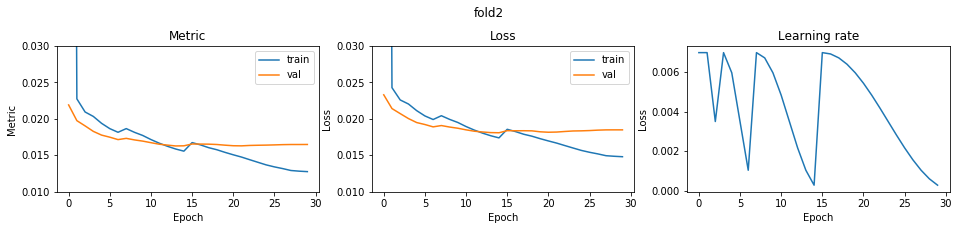

fold 3


epoch1 save best model... 0.021950368974400274
epoch2 save best model... 0.01985083598355022
epoch3 save best model... 0.019115060480027236
epoch4 save best model... 0.01845283247275885
epoch5 save best model... 0.018036168568888532
epoch6 save best model... 0.01761450711552877
epoch7 save best model... 0.01742194370114179
epoch9 save best model... 0.017285545818626475
epoch10 save best model... 0.017045201626362316
epoch11 save best model... 0.01686597121561239
epoch12 save best model... 0.016711148558977932
epoch13 save best model... 0.016554065321090553
epoch14 save best model... 0.016450620790124618
epoch22 save best model... 0.01643023620018044
fold3 score: 0.016430236024336683


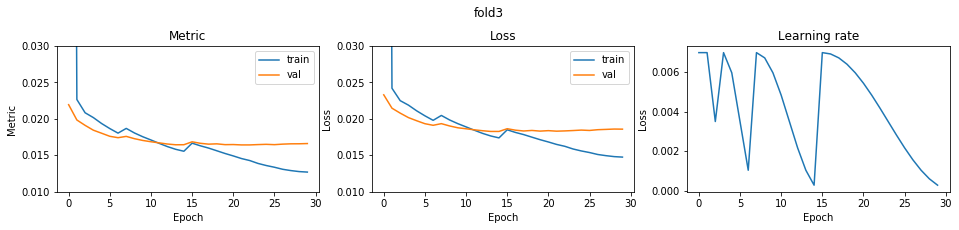

fold 4


epoch1 save best model... 0.021892614621915142
epoch2 save best model... 0.019569075589571022
epoch3 save best model... 0.018700602270476097
epoch4 save best model... 0.01840885085539557
epoch5 save best model... 0.017717541415235856
epoch6 save best model... 0.017428487764590828
epoch7 save best model... 0.017210696834926587
epoch9 save best model... 0.017135726850573185
epoch10 save best model... 0.016906992557770433
epoch11 save best model... 0.016766364745167774
epoch12 save best model... 0.016610356516593
epoch13 save best model... 0.01648027364096704
epoch14 save best model... 0.0164113979578731
epoch15 save best model... 0.01641088432010798
fold4 score: 0.01641088432125235


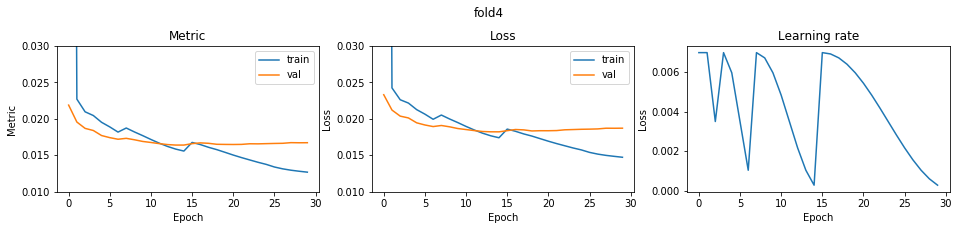

CV score: 0.016365006587756036


In [32]:
optimizer = RangerLars
CFG.optimizer = optimizer
logger.info('')
logger.info('optimizer: '+ optimizer.__name__)
oof, predictions = run_kfold_nn(CFG,
                                trn_df,
                                test_df,
                                CFG.feature_cols,
                                CFG.target_cols,
                                n_fold=5)

# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
score_dict[optimizer.__name__] = score

In [33]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
RAdam              0.016346
LookaheadDiffGrad  0.016351
PlainRAdam         0.016356
RangerLars         0.016365
Yogi               0.016378
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797


metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
RAdam              0.016346
LookaheadDiffGrad  0.016351
PlainRAdam         0.016356
RangerLars         0.016365
Yogi               0.016378
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.019750853968202933
epoch2 save best model... 0.01870237135143785
epoch3 save best model... 0.017723694053353372
epoch4 save best model... 0.017702960887401958
epoch5 save best model... 0.017286595893103062
epoch6 save best model... 0.016936550769691857
epoch7 save best model... 0.016622073836370047
epoch13 save best model... 0.016522972272170162
epoch14 save best model... 0.016318592435949755
epoch15 save best model... 0.01627174808998043
epoch28 save best model... 0.016219856290057608
epoch29 save best model... 0.016139513384847815
epoch30 save best model... 0.016103631834624703
fold0 score: 0.01610363174074402


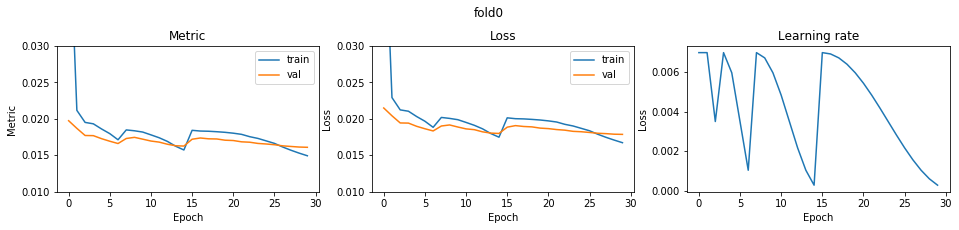

fold 1


epoch1 save best model... 0.019929505838388924
epoch2 save best model... 0.01856808400124916
epoch3 save best model... 0.017903601926004296
epoch5 save best model... 0.017491697459584572
epoch6 save best model... 0.01724021692371336
epoch7 save best model... 0.01695676879330495
epoch13 save best model... 0.01676889597702458
epoch14 save best model... 0.01652187054310954
epoch15 save best model... 0.016450071638616812
epoch30 save best model... 0.016448196424962813
fold1 score: 0.01644819631205647


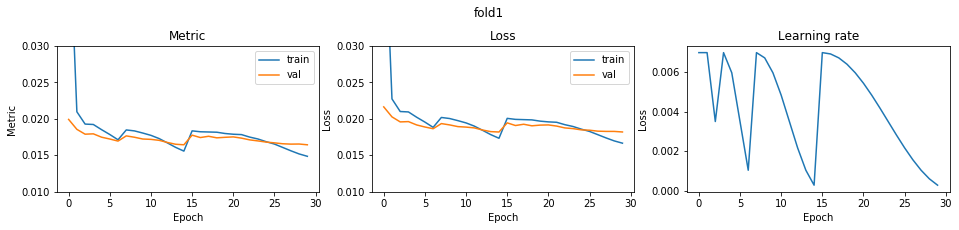

fold 2


epoch1 save best model... 0.019933930965720603
epoch2 save best model... 0.018520454348184424
epoch3 save best model... 0.01772094250941642
epoch5 save best model... 0.017475326100139826
epoch6 save best model... 0.0170321845370783
epoch7 save best model... 0.01674317603467822
epoch13 save best model... 0.01662359835898708
epoch14 save best model... 0.016399831537604603
epoch15 save best model... 0.01627562692871423
epoch30 save best model... 0.016262793668610925
fold2 score: 0.016262793615485126


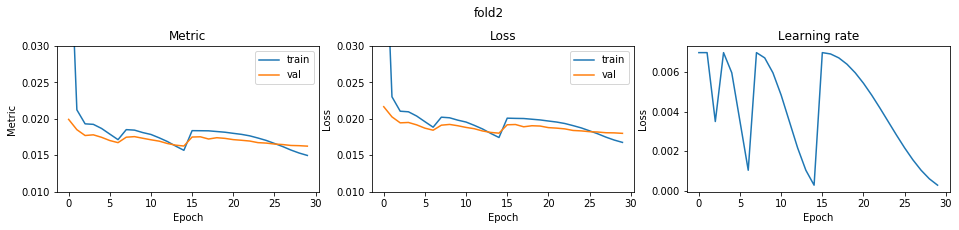

fold 3


epoch1 save best model... 0.0202321522179694
epoch2 save best model... 0.018889871124678836
epoch3 save best model... 0.017889036550897266
epoch5 save best model... 0.017561335857864256
epoch6 save best model... 0.017204940308453962
epoch7 save best model... 0.01692521958092147
epoch13 save best model... 0.01672531545230088
epoch14 save best model... 0.016509165394635435
epoch15 save best model... 0.016453679644657566
epoch28 save best model... 0.01645306381556059
epoch29 save best model... 0.016378636477867265
epoch30 save best model... 0.016339521748618413
fold3 score: 0.0163395217851888


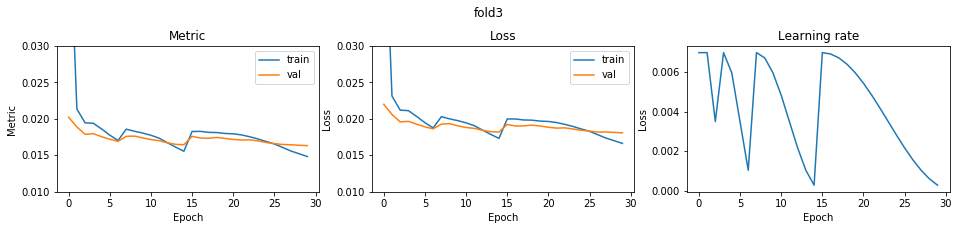

fold 4


epoch1 save best model... 0.01956550978752095
epoch2 save best model... 0.01857410990855824
epoch3 save best model... 0.01766342231134008
epoch5 save best model... 0.017484776212797756
epoch6 save best model... 0.01709026497086523
epoch7 save best model... 0.016793453893231777
epoch13 save best model... 0.01667249440120062
epoch14 save best model... 0.016504983923022458
epoch15 save best model... 0.016406395756438
epoch29 save best model... 0.016348759500322555
fold4 score: 0.016348759578516933


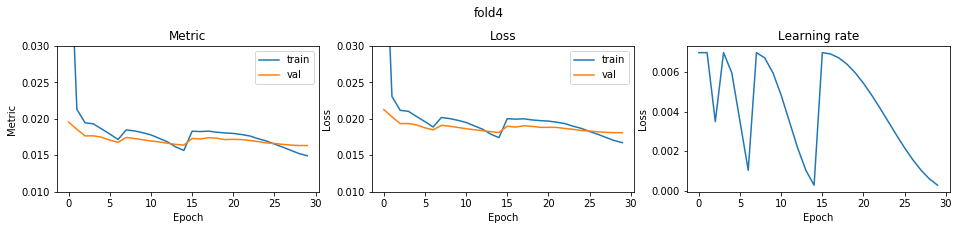

CV score: 0.01630057560235623

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.020371297069725524
epoch2 save best model... 0.018905846832281907
epoch3 save best model... 0.018076151671367516
epoch4 save best model... 0.01798852728870708
epoch5 save best model... 0.017647165152539154
epoch6 save best model... 0.017235834362804212
epoch7 save best model... 0.016938795061073434
epoch11 save best model... 0.016773158686070072
epoch12 save best model... 0.016591064949309908
epoch13 save best model... 0.016420586391061476
epoch14 save best model... 0.016309909943007527
epoch15 save best model... 0.016267520382338477
epoch22 save best model... 0.016221061318366023
epoch25 save best model... 0.016155466114453003
fold0 score: 0.01615546592239632


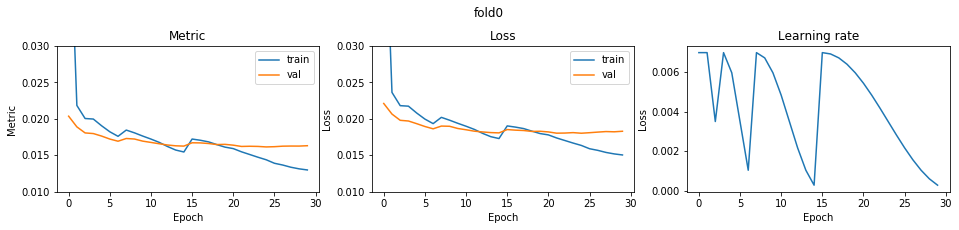

fold 1


epoch1 save best model... 0.02046426480958961
epoch2 save best model... 0.01918244783465888
epoch3 save best model... 0.018482923727099757
epoch4 save best model... 0.01837323295276321
epoch5 save best model... 0.01762919752387719
epoch6 save best model... 0.017424040455112266
epoch7 save best model... 0.01711980872069256
epoch11 save best model... 0.016898624034117637
epoch12 save best model... 0.016797651614850365
epoch13 save best model... 0.016650324119316485
epoch14 save best model... 0.016537458528283925
epoch15 save best model... 0.016463234030961393
fold1 score: 0.016463233931014797


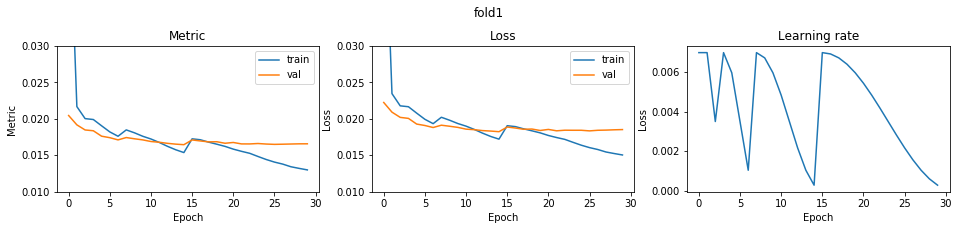

fold 2


epoch1 save best model... 0.0204388931037985
epoch2 save best model... 0.018794737391065196
epoch3 save best model... 0.018115726686414865
epoch4 save best model... 0.01805549729819157
epoch5 save best model... 0.01759522645035069
epoch6 save best model... 0.01722418581848333
epoch7 save best model... 0.01688968282813403
epoch11 save best model... 0.016778515591558792
epoch12 save best model... 0.016525131198930888
epoch13 save best model... 0.016429854584079067
epoch14 save best model... 0.016263592791760338
epoch15 save best model... 0.016244639257403246
fold2 score: 0.016244639077999144


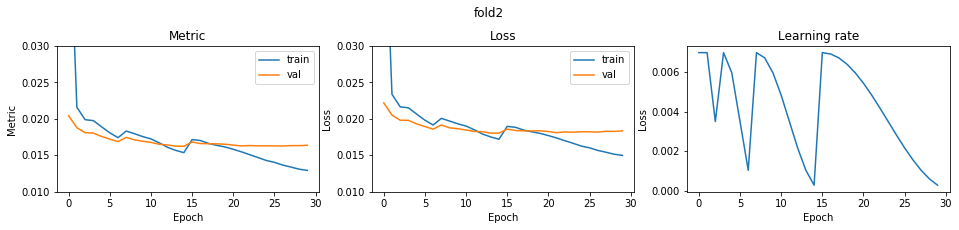

fold 3


epoch1 save best model... 0.02021965945568063
epoch2 save best model... 0.019219581966112308
epoch3 save best model... 0.018234810105404033
epoch4 save best model... 0.018134545129225303
epoch5 save best model... 0.017745139265267478
epoch6 save best model... 0.01739999374039556
epoch7 save best model... 0.017066044027753736
epoch11 save best model... 0.016918299618709602
epoch12 save best model... 0.016747028094234798
epoch13 save best model... 0.016617378609038568
epoch14 save best model... 0.016478803725000938
fold3 score: 0.01647880368609517


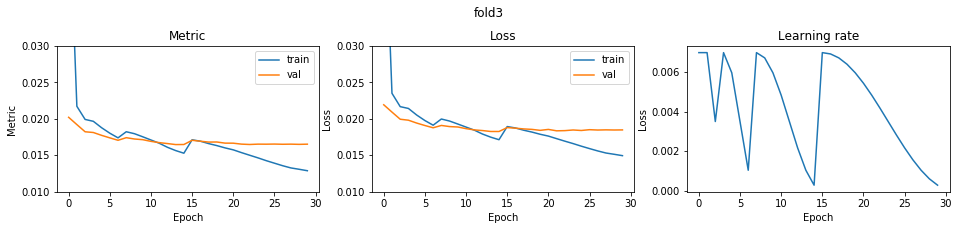

fold 4


epoch1 save best model... 0.02039824373222429
epoch2 save best model... 0.01909818357378584
epoch3 save best model... 0.018221748152701077
epoch4 save best model... 0.01813585365186859
epoch5 save best model... 0.017667375374288384
epoch6 save best model... 0.017214879541655743
epoch7 save best model... 0.016997990060113963
epoch11 save best model... 0.01690435914496694
epoch12 save best model... 0.016680052462362753
epoch13 save best model... 0.016599983042678828
epoch14 save best model... 0.01647742422709161
epoch15 save best model... 0.016436861561089415
epoch24 save best model... 0.016367601754742087
fold4 score: 0.0163676018165785


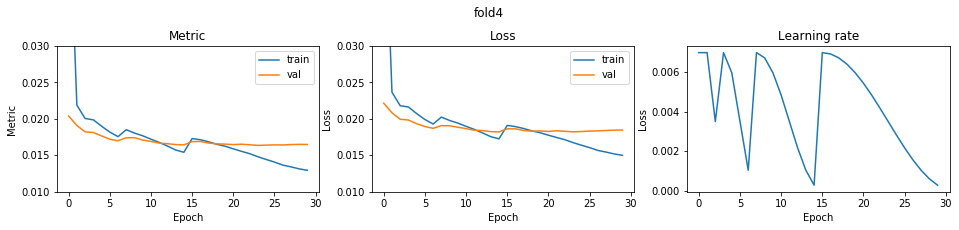

CV score: 0.016341947794451406

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.6985607451621384
epoch2 save best model... 0.6771247885221773
epoch3 save best model... 0.6678089071514938
epoch4 save best model... 0.6048510849340087
epoch5 save best model... 0.5207632168278878
epoch6 save best model... 0.48145574348934145
epoch7 save best model... 0.4777014721091625
epoch8 save best model... 0.3237106189776662
epoch9 save best model... 0.20476728544691428
epoch10 save best model... 0.1402057563321737
epoch11 save best model... 0.10913288101452087
epoch12 save best model... 0.09421647149297262
epoch13 save best model... 0.0907467538104785
epoch14 save best model... 0.0905534251404243
epoch15 save best model... 0.08893974653884328
epoch16 save best model... 0.05248819060946108
epoch17 save best model... 0.0381188831306943
epoch18 save best model... 0.030254814642267237
epoch19 save best model... 0.02618976049040336
epoch20 save best model... 0.024355753411057328
epoch21 save best model... 0.023248936084007892
epoch22 save best model... 0.0

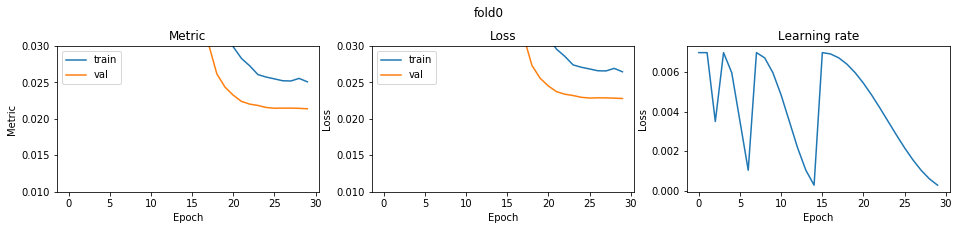

fold 1


epoch1 save best model... 0.6996023699481657
epoch2 save best model... 0.6792919193728689
epoch3 save best model... 0.6675536440510118
epoch4 save best model... 0.6064413803453244
epoch5 save best model... 0.5211242657366144
epoch6 save best model... 0.48315804813793073
epoch7 save best model... 0.4825544025461232
epoch8 save best model... 0.32247095897464445
epoch9 save best model... 0.2008513505304286
epoch10 save best model... 0.13863725040178415
epoch11 save best model... 0.10779963212720516
epoch12 save best model... 0.09423326218140426
epoch13 save best model... 0.08783461853580014
epoch16 save best model... 0.053004962665245944
epoch17 save best model... 0.03757667945183119
epoch18 save best model... 0.030386484884392783
epoch19 save best model... 0.026432037163813555
epoch20 save best model... 0.02438798093967569
epoch21 save best model... 0.02297282406852739
epoch22 save best model... 0.02254358669167894
epoch23 save best model... 0.021971832148987087
epoch24 save best model..

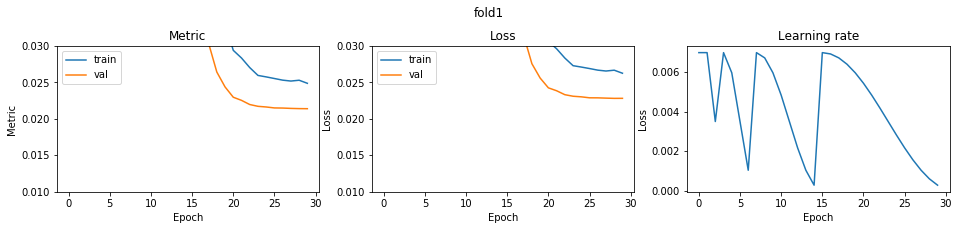

fold 2


epoch1 save best model... 0.696814711856038
epoch2 save best model... 0.6770464929368616
epoch3 save best model... 0.6698414134419733
epoch4 save best model... 0.6052526107924108
epoch5 save best model... 0.5211630694196392
epoch6 save best model... 0.48461098577525896
epoch7 save best model... 0.48027336133669873
epoch8 save best model... 0.3238401533762071
epoch9 save best model... 0.20306239057290687
epoch10 save best model... 0.14018225045159619
epoch11 save best model... 0.10904913305502922
epoch12 save best model... 0.09585839413882226
epoch13 save best model... 0.09190427202805215
epoch14 save best model... 0.08868069491141423
epoch15 save best model... 0.08787640620606123
epoch16 save best model... 0.05206833143142856
epoch17 save best model... 0.03827450427912748
epoch18 save best model... 0.030276566645392362
epoch19 save best model... 0.026709622659143947
epoch20 save best model... 0.024529488988969315
epoch21 save best model... 0.023280170118263492
epoch22 save best model..

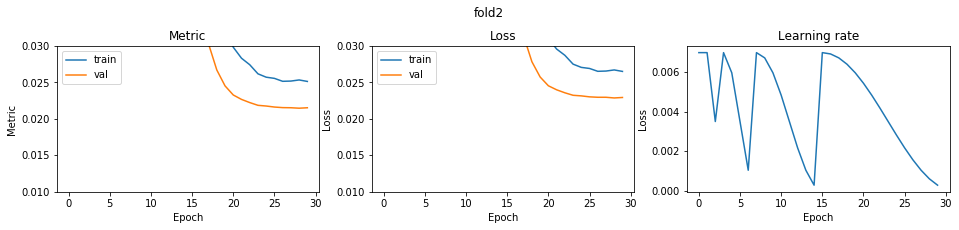

fold 3


epoch1 save best model... 0.6926757497233519
epoch2 save best model... 0.6731193234274219
epoch3 save best model... 0.6658032525916306
epoch4 save best model... 0.6018226876617293
epoch5 save best model... 0.5166865532381931
epoch6 save best model... 0.47797918861439126
epoch8 save best model... 0.32692750043369373
epoch9 save best model... 0.20316315987794437
epoch10 save best model... 0.13983459969587914
epoch11 save best model... 0.1084808279142836
epoch12 save best model... 0.09622134526593266
epoch13 save best model... 0.09181725858352179
epoch15 save best model... 0.09077773152899361
epoch16 save best model... 0.05342398557922291
epoch17 save best model... 0.038075095815647705
epoch18 save best model... 0.03111311413585325
epoch19 save best model... 0.026711778906184612
epoch20 save best model... 0.02460347606221337
epoch21 save best model... 0.023435161503748903
epoch22 save best model... 0.022625144201931215
epoch23 save best model... 0.022187750509904024
epoch24 save best mode

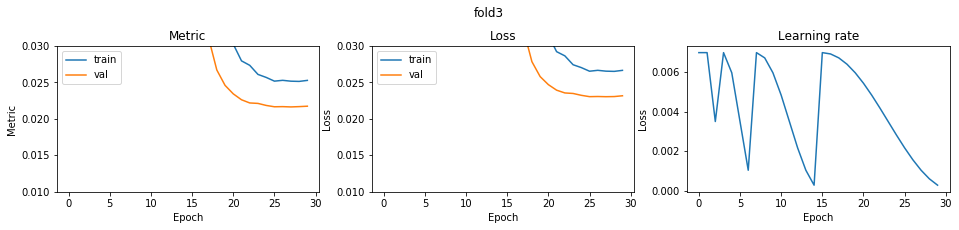

fold 4


epoch1 save best model... 0.6982540986260956
epoch2 save best model... 0.6775376318527517
epoch3 save best model... 0.667142317343953
epoch4 save best model... 0.6044738841219752
epoch5 save best model... 0.517107432333918
epoch6 save best model... 0.48235735701808624
epoch7 save best model... 0.4812773736028302
epoch8 save best model... 0.32351102919947855
epoch9 save best model... 0.20217664038130254
epoch10 save best model... 0.13888814657722898
epoch11 save best model... 0.10834509911257477
epoch12 save best model... 0.09533890205051469
epoch13 save best model... 0.09049669727852784
epoch14 save best model... 0.08835654986474943
epoch16 save best model... 0.053245615068152716
epoch17 save best model... 0.037702170813748936
epoch18 save best model... 0.030078473391864185
epoch19 save best model... 0.026746745186100516
epoch20 save best model... 0.023918562285720896
epoch21 save best model... 0.022943838477847516
epoch22 save best model... 0.02229363500545807
epoch23 save best model.

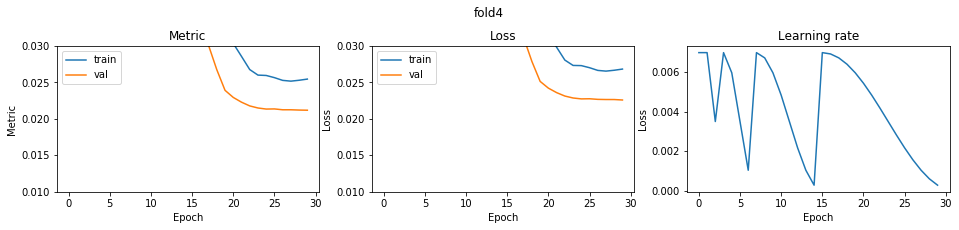

CV score: 0.0214174403404377

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.02046113463971501
epoch2 save best model... 0.0188556852264665
epoch3 save best model... 0.018049795926465804
epoch5 save best model... 0.01757012195206313
epoch6 save best model... 0.01710365413431426
epoch7 save best model... 0.016773448765685185
epoch11 save best model... 0.01669380406261441
epoch12 save best model... 0.016513853172234902
epoch13 save best model... 0.016322701297921037
epoch14 save best model... 0.016184789519799462
epoch15 save best model... 0.016149845198730264
fold0 score: 0.01614984520713728


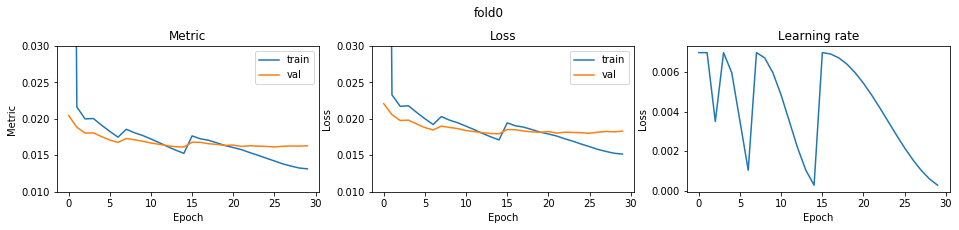

fold 1


epoch1 save best model... 0.020587040426743874
epoch2 save best model... 0.019158820494989053
epoch3 save best model... 0.01825626280628133
epoch4 save best model... 0.018224107179222904
epoch5 save best model... 0.017909305103973663
epoch6 save best model... 0.01737550466804576
epoch7 save best model... 0.017051780548207267
epoch11 save best model... 0.016999066277903856
epoch12 save best model... 0.016794009241119526
epoch13 save best model... 0.016623172932362797
epoch14 save best model... 0.016546635976577708
epoch15 save best model... 0.01653412168649891
epoch26 save best model... 0.01648423160384092
fold1 score: 0.016484231425881138


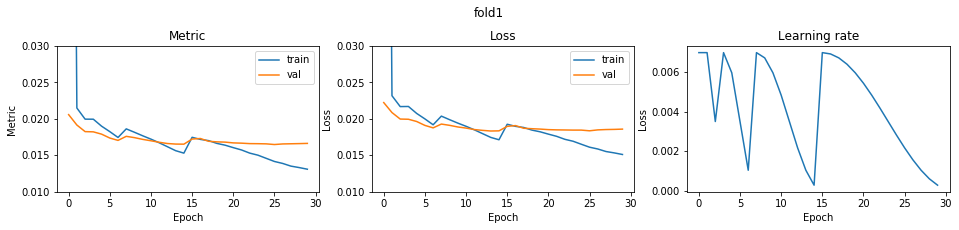

fold 2


epoch1 save best model... 0.020392906362533325
epoch2 save best model... 0.0191706470713549
epoch3 save best model... 0.01819993784907067
epoch4 save best model... 0.01804754337965152
epoch5 save best model... 0.01759135001185177
epoch6 save best model... 0.017184807114960066
epoch7 save best model... 0.016890030886870116
epoch12 save best model... 0.01655069743761592
epoch13 save best model... 0.016435721556204725
epoch14 save best model... 0.016258209864410542
epoch15 save best model... 0.016215343477947546
fold2 score: 0.016215343416207693


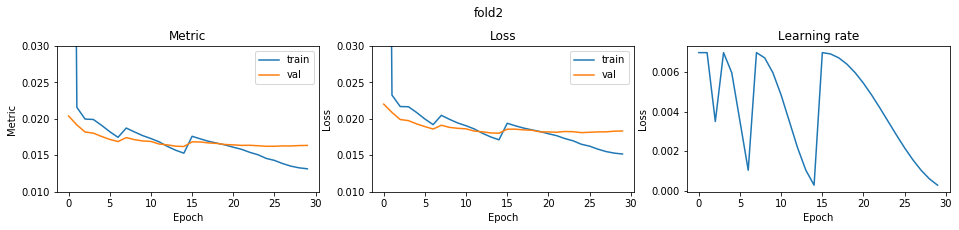

fold 3


epoch1 save best model... 0.02046755302468302
epoch2 save best model... 0.019347190391484453
epoch3 save best model... 0.018463189021211142
epoch4 save best model... 0.018081433812669714
epoch5 save best model... 0.017865654661538662
epoch6 save best model... 0.017421334958582235
epoch7 save best model... 0.01706380627854199
epoch11 save best model... 0.016961394193113394
epoch12 save best model... 0.016813782916949523
epoch13 save best model... 0.016624313696438197
epoch14 save best model... 0.01650704776651835
epoch15 save best model... 0.016459155728051903
fold3 score: 0.01645915564460736


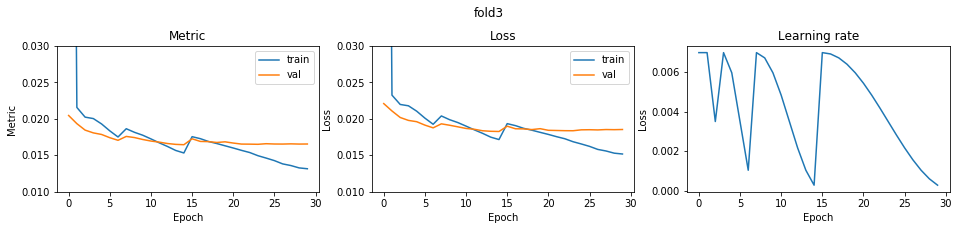

fold 4


epoch1 save best model... 0.020075391354315103
epoch2 save best model... 0.018819899845588316
epoch3 save best model... 0.018032464072753194
epoch4 save best model... 0.017927879453604884
epoch5 save best model... 0.017629178997833526
epoch6 save best model... 0.01725315781764194
epoch7 save best model... 0.01693693457854432
epoch11 save best model... 0.0169219591164779
epoch12 save best model... 0.016803475576272587
epoch13 save best model... 0.016617895922027445
epoch14 save best model... 0.016506362321589287
epoch15 save best model... 0.01646945789320594
fold4 score: 0.016469457820441243


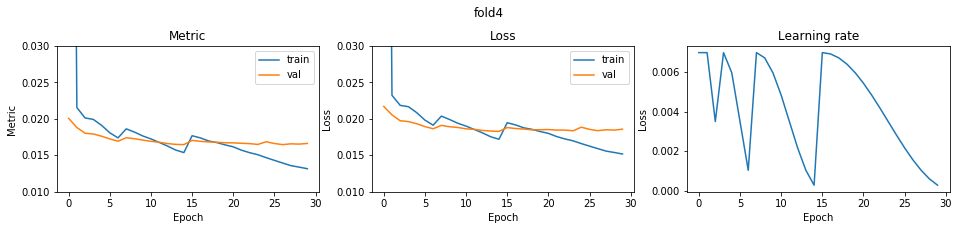

CV score: 0.016355607233133947

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021137349902395505
epoch2 save best model... 0.01968649937209073
epoch3 save best model... 0.018804438816116178
epoch4 save best model... 0.018093799486552663
epoch5 save best model... 0.017745588641774952
epoch6 save best model... 0.017316821610432007
epoch7 save best model... 0.017155755906109113
epoch9 save best model... 0.017046681085520834
epoch10 save best model... 0.01681338912618595
epoch11 save best model... 0.016671213303991766
epoch12 save best model... 0.016519977538453964
epoch13 save best model... 0.016345952755871286
epoch14 save best model... 0.016246566259575868
epoch15 save best model... 0.016201323444333462
fold0 score: 0.016201323461653722


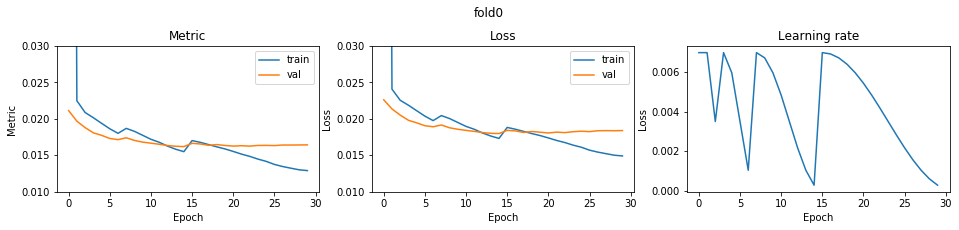

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02125923499493847
epoch2 save best model... 0.01954567854628595
epoch3 save best model... 0.01892629308733426
epoch4 save best model... 0.01827834239308072
epoch5 save best model... 0.01783464348173258
epoch6 save best model... 0.017484356504715394
epoch7 save best model... 0.017264442161654157
epoch10 save best model... 0.017107288404708435
epoch11 save best model... 0.016994026587801987
epoch12 save best model... 0.01682238435590422
epoch13 save best model... 0.01664162628050477
epoch14 save best model... 0.016604814214997314
epoch15 save best model... 0.016532380192857393
fold1 score: 0.016532379991430802


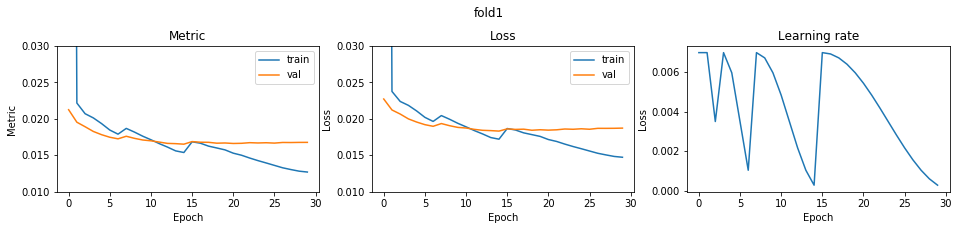

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02126438148009068
epoch2 save best model... 0.020182287219065582
epoch3 save best model... 0.018895650564084553
epoch4 save best model... 0.018470603666052063
epoch5 save best model... 0.01786595001251463
epoch6 save best model... 0.017448326824438764
epoch7 save best model... 0.017140233075667633
epoch10 save best model... 0.01688687905022443
epoch11 save best model... 0.016793438878931456
epoch12 save best model... 0.01659723954335938
epoch13 save best model... 0.016420547006956047
epoch14 save best model... 0.016294294859391528
epoch15 save best model... 0.01626159868774544
fold2 score: 0.016261598566020895


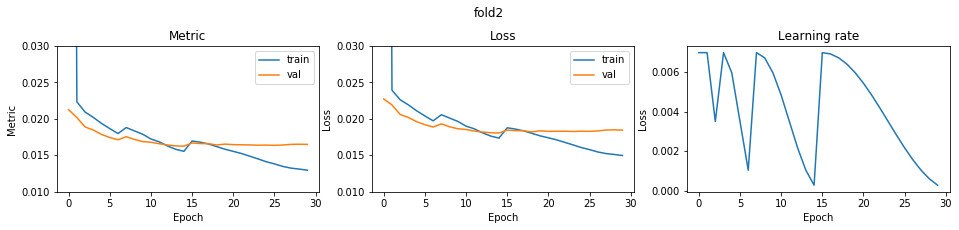

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021231528660940146
epoch2 save best model... 0.0198735503034331
epoch3 save best model... 0.01911336008442358
epoch4 save best model... 0.018308257017971986
epoch5 save best model... 0.01789368727373846
epoch6 save best model... 0.017557171619749692
epoch7 save best model... 0.01729399562348741
epoch10 save best model... 0.017143978947743874
epoch11 save best model... 0.016957634641600088
epoch12 save best model... 0.016743978820232024
epoch13 save best model... 0.016644398896511568
epoch14 save best model... 0.0165647392922796
epoch15 save best model... 0.016527847545582095
epoch23 save best model... 0.016517889478873962
fold3 score: 0.01651788936416469


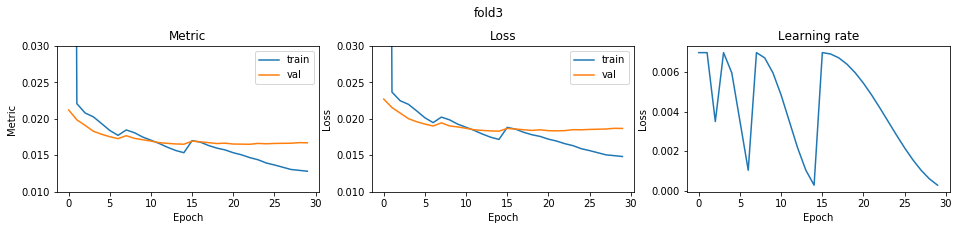

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020940913404242596
epoch2 save best model... 0.01950923061605059
epoch3 save best model... 0.018894668259066032
epoch4 save best model... 0.018190373289388242
epoch5 save best model... 0.017733184941927636
epoch6 save best model... 0.017429935950404013
epoch7 save best model... 0.01717543011925826
epoch10 save best model... 0.017021769165975763
epoch11 save best model... 0.016833749098240786
epoch12 save best model... 0.016631052975281904
epoch13 save best model... 0.016520348836186263
epoch14 save best model... 0.01642214181686588
epoch15 save best model... 0.016394321883101533
fold4 score: 0.01639432187184764


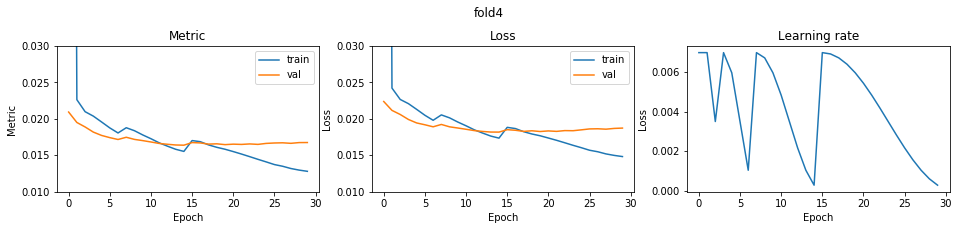

CV score: 0.016381501239812715
                     metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
Adam_CG            0.016301
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
AdamW_CG           0.016342
RAdam              0.016346
LookaheadDiffGrad  0.016351
RAdam_CG           0.016356
PlainRAdam         0.016356
RangerLars         0.016365
Yogi               0.016378
Ranger_CG          0.016382
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
PlainRAdam_CG      0.021417
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797


metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
Adam_CG            0.016301
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
AdamW_CG           0.016342
RAdam              0.016346
LookaheadDiffGrad  0.016351
RAdam_CG           0.016356
PlainRAdam         0.016356
RangerLars         0.016365
Yogi               0.016378
Ranger_CG          0.016382
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
PlainRAdam_CG      0.021417
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797

In [35]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
]

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score
    
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

In [49]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
Adam_CG            0.016301
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
AdamW_CG           0.016342
RAdam              0.016346
LookaheadDiffGrad  0.016351
RAdam_CG           0.016356
PlainRAdam         0.016356
RangerLars         0.016365
Yogi               0.016378
Ranger_CG          0.016382
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
PlainRAdam_CG      0.021417
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797


metric
NovoGrad           0.016249
AdaMod             0.016267
RangerQH           0.016278
LookaheadAdam      0.016283
Adam               0.016284
AdamP              0.016290
AdaBelief          0.016293
Adam_CG            0.016301
SWATS              0.016302
QHAdam             0.016303
DiffGrad           0.016317
AdamW              0.016323
Ranger             0.016331
AdamW_CG           0.016342
RAdam              0.016346
LookaheadDiffGrad  0.016351
RAdam_CG           0.016356
PlainRAdam         0.016356
RangerLars         0.016365
Yogi               0.016378
Ranger_CG          0.016382
Lamb               0.016384
LookaheadYogi      0.016761
RangerVA           0.018736
AggMo              0.018773
AdaBound           0.020365
PlainRAdam_CG      0.021417
SGD                0.460002
PID                0.460373
SGDP               0.461132
Apollo             0.461517
QHM                0.466171
SGDW               0.470797

In [50]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')